# Model T5 SMall

#### Connect to drive and authentification

In [ ]:
#Connect google colab and Google Cloud bucket for storage
#Link google account
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Installing dependencies


In [ ]:
# Installing dependencies
!pip install transformers datasets torch torchvision
!pip install tf-keras~=2.16
!pip install Rouge
!pip install sentence-transformers
!pip install codecarbon
!pip install fvcore
!pip install fvcore.nn
!pip install datasets
!pip install tensorflow
!pip install autoawq
!pip install -q -U https://github.com/casper-hansen/AutoAWQ/releases/download/v0.1.6/autoawq-0.1.6+cu118-cp310-cp310-linux_x86_64.whl
!pip install -q transformers accelerate
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#### Importing libraries

In [ ]:
#import libraries
import torch
import time
import psutil  # For memory usage
import os
import sys

import pandas as pd
import numpy as np
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.prune as prune

from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import GradScaler,
                           autocast

from torch.utils.data import DataLoader,
                             Dataset,
                             random_split

from sentence_transformers import SentenceTransformer,
                                  util
from transformers import T5Tokenizer,
                         T5ForConditionalGeneration,
                         TrainingArguments,
                         Trainer,
                         T5Model,
                         AutoTokenizer,
                         get_scheduler

from datasets import load_dataset
import argparse
from codecarbon import EmissionsTracker
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score,
                            precision_score,
                            recall_score,
                            f1_score
from rouge import Rouge
from google.colab import data_table


#### Importing Dataset

In [ ]:
#import dataset

dataset = load_dataset("google/Synthetic-Persona-Chat")

train_data = dataset["train"]
test_data = dataset["test"]

# Afficher quelques exemples
print(train_data["user 1 personas"][0:5])  # Afficher 5 exemples
print(train_data["user 2 personas"][0:5])
print(train_data["Best Generated Conversation"][0:5])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['I am 32.\nI do not want a job.\nI play video games all day.\nI still live at home with my parents.', 'I am 32.\nI play video games all day.\nI still live at home with my parents.\nI do not want a job.', 'I am 32.\nI play video games all day.\nI still live at home with my parents.\nI do not want a job.\nI eat all take out.', 'I write.\nI work at mcdonald s.\nI watch youtube videos.\nI have brown hair.', 'I am bald.\nI like to swim.\nMy favorite drink is chocolate milk.\nI don t work.']
['My favorite drink is iced coffee.\nI have a black belt in karate.\nI m in a jazz band and play the saxophone.\nI vacation along lake michigan every summer.', 'I have a ford f150.\nI like ford cars.\nMy truck is black.\nI also like ford trucks.\nI own a ford truck.', 'I can recite the movie young frankenstein word for word.\nI like to make my own clothes.\nI am partially blind.\nI do volunteer work for human rights organizations.\nI can do convincing bird calls.', 'I want to move.\nI don t like feeling

#### Importing and defining model

In [ ]:
#Define model from https://colab.research.google.com/github/google-research/text-to-text-transfer-transformer/blob/main/notebooks/t5-trivia.ipynb#scrollTo=DZhAd0U_4B_o
# Required to fix Colab flag parsing issue.

sys.argv = sys.argv[:1]

BASE_DIR = "gs://data_bucket_experimental_analysis" #@param { type: "string" }
if not BASE_DIR or BASE_DIR == "gs://":
  raise ValueError("You must enter a BASE_DIR.")
DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
ON_CLOUD = True

MODEL_SIZE = "small" #@param["small", "base", "large", "3B", "11B"]
PRETRAINED_DIR = "t5-small"
MODEL_DIR = os.path.join(MODELS_DIR, MODEL_SIZE)


# Set parallelism and batch size to fit on v2-8 TPU (if possible).
# Limit number of checkpoints to fit within 5GB (if possible).
model_parallelism, train_batch_size, keep_checkpoint_max = {
    "small": (1, 256, 16),
    "base": (2, 128, 8),
    "large": (8, 64, 4),
    "3B": (8, 16, 1),
    "11B": (8, 16, 1)}[MODEL_SIZE]

#tf.io.gfile.makedirs(MODEL_DIR)
# The models from our paper are based on the Mesh Tensorflow Transformer.
#Change to T5ForConditionalGeneration for finetuning task
model = T5ForConditionalGeneration.from_pretrained(PRETRAINED_DIR)



#### Tokenize entry points

In [ ]:
# Tokenize entry points ---------------------------------------------------------------
# Load Tokenizer (Ensure it Matches Model Version)
TOKENIZER = T5Tokenizer.from_pretrained("t5-small")

def preprocess_function(examples):
    # Combine personas into a single input string
    inputs = [p1 + " " + p2 for p1,
              p2 in zip(examples["user 1 personas"],
                        examples["user 2 personas"])
              ]

    # Tokenize inputs (Persona 1 + Persona 2)
    model_inputs = TOKENIZER(inputs,
                             max_length=256,
                             truncation=True,
                             padding="max_length")

    # Tokenize targets (best-generated conversations)
    conversations = [str(conv) for conv in examples["Best Generated Conversation"]]
    labels = TOKENIZER(text_target=conversations,
                       max_length=64,
                       truncation=True,
                       padding="max_length")["input_ids"]
    labels = torch.tensor(labels)
    labels[labels == TOKENIZER.pad_token_id] = -100  # Ignorer le padding


    # Assign label input_ids
    model_inputs["labels"] = labels

    return model_inputs

# Preprocess Dataset
tokenized_train_dataset = train_data.map(preprocess_function, batched=True, batch_size=16)
tokenized_test_dataset = test_data.map(preprocess_function, batched=True, batch_size=16)

# Example Usage (Access Tokenized Data)
print(tokenized_train_dataset[0]["input_ids"])
print(tokenized_train_dataset[0]["labels"])


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


[27, 183, 3538, 5, 27, 103, 59, 241, 3, 9, 613, 5, 27, 577, 671, 1031, 66, 239, 5, 27, 341, 619, 44, 234, 28, 82, 1362, 5, 499, 1305, 3281, 19, 3, 867, 26, 1975, 5, 27, 43, 3, 9, 1001, 6782, 16, 3, 4031, 342, 5, 27, 3, 51, 16, 3, 9, 9948, 1928, 11, 577, 8, 3, 7, 9, 226, 32, 6399, 5, 27, 4257, 590, 6957, 2278, 12588, 334, 1248, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[6674, 209, 10, 2018, 55, 27, 31, 51, 784, 10041, 209, 31, 7, 564, 4275, 6674, 204, 10, 2018, 784, 10041, 209, 31, 7, 564, 13

In [ ]:
#Create DataLoaders------------------------------------------------------------
#Transform Data for compatibility with pytorch

from torch.utils.data import DataLoader, random_split

# Create a custom Dataset class
class PersonaChatDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            'input_ids': torch.tensor(item['input_ids']),
            'attention_mask': torch.tensor(item['attention_mask']),
            'labels': torch.tensor(item['labels'])
        }

# Create DataLoaders
train_dataset = PersonaChatDataset(tokenized_train_dataset)
test_dataset = PersonaChatDataset(tokenized_test_dataset)

# Define the validation split ratio (e.g., 80% test, 20% validation)
val_size = int(0.2 * len(test_dataset))  # 20% for validation
test_size = len(test_dataset) - val_size  # 80% for testing

# Split the test dataset into validation and actual test sets
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=5) # Adjust batch size as needed
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=5) # Adjust batch size as needed
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=5)  # Validation data
print(train_dataset[0])


{'input_ids': tensor([   27,   183,  3538,     5,    27,   103,    59,   241,     3,     9,
          613,     5,    27,   577,   671,  1031,    66,   239,     5,    27,
          341,   619,    44,   234,    28,    82,  1362,     5,   499,  1305,
         3281,    19,     3,   867,    26,  1975,     5,    27,    43,     3,
            9,  1001,  6782,    16,     3,  4031,   342,     5,    27,     3,
           51,    16,     3,     9,  9948,  1928,    11,   577,     8,     3,
            7,     9,   226,    32,  6399,     5,    27,  4257,   590,  6957,
         2278, 12588,   334,  1248,     5,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

<ipython-input-9-6382b97fd407>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
[codecarbon INFO @ 03:12:16] [setup] RAM Tracking...
[codecarbon INFO @ 03:12:16] [setup] CPU Tracking...
[codecarbon WARNING @ 03:12:16] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



Epoch 1/3


[codecarbon INFO @ 03:12:17] CPU Model on constant consumption mode: AMD EPYC 7B12
[codecarbon INFO @ 03:12:17] [setup] GPU Tracking...
[codecarbon INFO @ 03:12:17] No GPU found.
[codecarbon INFO @ 03:12:17] >>> Tracker's metadata:
[codecarbon INFO @ 03:12:17]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 03:12:17]   Python version: 3.11.11
[codecarbon INFO @ 03:12:17]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 03:12:17]   Available RAM : 50.994 GB
[codecarbon INFO @ 03:12:17]   CPU count: 8
[codecarbon INFO @ 03:12:17]   CPU model: AMD EPYC 7B12
[codecarbon INFO @ 03:12:17]   GPU count: None
[codecarbon INFO @ 03:12:17]   GPU model: None
[codecarbon INFO @ 03:12:17] Saving emissions data to file /content/emissions.csv
  0%|          | 0/559 [00:00<?, ?it/s]<ipython-input-9-6382b97fd407>:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.

Batch 1/559 - Loss: 3.9774842262268066


[codecarbon INFO @ 03:12:32] Energy consumed for RAM : 0.000080 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:12:32] Energy consumed for all CPUs : 0.000500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:12:32] 0.000580 kWh of electricity used since the beginning.
  0%|          | 2/559 [00:16<1:15:23,  8.12s/it]

Batch 2/559 - Loss: 3.8805480003356934


  1%|          | 3/559 [00:22<1:04:05,  6.92s/it]

Batch 3/559 - Loss: 3.7999415397644043


  1%|          | 4/559 [00:27<57:50,  6.25s/it]  

Batch 4/559 - Loss: 3.7938005924224854


[codecarbon INFO @ 03:12:47] Energy consumed for RAM : 0.000159 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:12:47] Energy consumed for all CPUs : 0.001000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:12:47] 0.001159 kWh of electricity used since the beginning.
  1%|          | 5/559 [00:32<52:50,  5.72s/it]

Batch 5/559 - Loss: 3.7415928840637207


  1%|          | 6/559 [00:37<50:36,  5.49s/it]

Batch 6/559 - Loss: 3.941636800765991


  1%|▏         | 7/559 [00:42<49:23,  5.37s/it]

Batch 7/559 - Loss: 3.8879284858703613


[codecarbon INFO @ 03:13:02] Energy consumed for RAM : 0.000239 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:13:02] Energy consumed for all CPUs : 0.001500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:13:02] 0.001739 kWh of electricity used since the beginning.
  1%|▏         | 8/559 [00:47<48:28,  5.28s/it]

Batch 8/559 - Loss: 3.8241539001464844


  2%|▏         | 9/559 [00:52<46:45,  5.10s/it]

Batch 9/559 - Loss: 3.957876443862915


  2%|▏         | 10/559 [00:56<46:02,  5.03s/it]

Batch 10/559 - Loss: 4.0249457359313965


[codecarbon INFO @ 03:13:17] Energy consumed for RAM : 0.000319 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:13:17] Energy consumed for all CPUs : 0.002000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:13:17] 0.002319 kWh of electricity used since the beginning.
  2%|▏         | 11/559 [01:01<45:46,  5.01s/it]

Batch 11/559 - Loss: 3.9176688194274902


  2%|▏         | 12/559 [01:06<45:17,  4.97s/it]

Batch 12/559 - Loss: 3.936842679977417


  2%|▏         | 13/559 [01:11<45:08,  4.96s/it]

Batch 13/559 - Loss: 4.021329879760742


[codecarbon INFO @ 03:13:32] Energy consumed for RAM : 0.000398 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:13:32] Energy consumed for all CPUs : 0.002500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:13:32] 0.002898 kWh of electricity used since the beginning.
  3%|▎         | 14/559 [01:16<44:43,  4.92s/it]

Batch 14/559 - Loss: 3.783719301223755


  3%|▎         | 15/559 [01:21<44:30,  4.91s/it]

Batch 15/559 - Loss: 3.8297624588012695


  3%|▎         | 16/559 [01:26<43:51,  4.85s/it]

Batch 16/559 - Loss: 3.9404208660125732


[codecarbon INFO @ 03:13:47] Energy consumed for RAM : 0.000478 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:13:47] Energy consumed for all CPUs : 0.003000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:13:47] 0.003478 kWh of electricity used since the beginning.
  3%|▎         | 17/559 [01:31<43:47,  4.85s/it]

Batch 17/559 - Loss: 3.875140428543091


  3%|▎         | 18/559 [01:36<44:25,  4.93s/it]

Batch 18/559 - Loss: 3.7507917881011963


  3%|▎         | 19/559 [01:40<44:08,  4.91s/it]

Batch 19/559 - Loss: 3.979220151901245


[codecarbon INFO @ 03:14:02] Energy consumed for RAM : 0.000558 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:14:02] Energy consumed for all CPUs : 0.003500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:14:02] 0.004057 kWh of electricity used since the beginning.
  4%|▎         | 20/559 [01:45<44:05,  4.91s/it]

Batch 20/559 - Loss: 3.774066686630249


  4%|▍         | 21/559 [01:50<43:40,  4.87s/it]

Batch 21/559 - Loss: 3.8977537155151367


  4%|▍         | 22/559 [01:55<44:27,  4.97s/it]

Batch 22/559 - Loss: 3.8802051544189453


[codecarbon INFO @ 03:14:17] Energy consumed for RAM : 0.000637 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:14:17] Energy consumed for all CPUs : 0.004000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:14:17] 0.004637 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:14:17] 0.024821 g.CO2eq/s mean an estimation of 782.7594700824741 kg.CO2eq/year
  4%|▍         | 23/559 [02:00<43:57,  4.92s/it]

Batch 23/559 - Loss: 3.8279170989990234


  4%|▍         | 24/559 [02:05<43:51,  4.92s/it]

Batch 24/559 - Loss: 3.7739593982696533


  4%|▍         | 25/559 [02:10<43:58,  4.94s/it]

Batch 25/559 - Loss: 3.7834548950195312


[codecarbon INFO @ 03:14:32] Energy consumed for RAM : 0.000717 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:14:32] Energy consumed for all CPUs : 0.004500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:14:32] 0.005217 kWh of electricity used since the beginning.
  5%|▍         | 26/559 [02:15<43:34,  4.90s/it]

Batch 26/559 - Loss: 3.752838134765625


  5%|▍         | 27/559 [02:20<43:31,  4.91s/it]

Batch 27/559 - Loss: 4.046570301055908


  5%|▌         | 28/559 [02:25<42:59,  4.86s/it]

Batch 28/559 - Loss: 3.880495309829712


  5%|▌         | 29/559 [02:29<42:57,  4.86s/it][codecarbon INFO @ 03:14:47] Energy consumed for RAM : 0.000797 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:14:47] Energy consumed for all CPUs : 0.005000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:14:47] 0.005796 kWh of electricity used since the beginning.


Batch 29/559 - Loss: 3.8601572513580322


  5%|▌         | 30/559 [02:34<42:53,  4.87s/it]

Batch 30/559 - Loss: 3.969484329223633


  6%|▌         | 31/559 [02:39<42:34,  4.84s/it]

Batch 31/559 - Loss: 4.0317487716674805


  6%|▌         | 32/559 [02:44<42:32,  4.84s/it]

Batch 32/559 - Loss: 3.80362606048584


[codecarbon INFO @ 03:15:02] Energy consumed for RAM : 0.000876 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:15:02] Energy consumed for all CPUs : 0.005500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:15:02] 0.006376 kWh of electricity used since the beginning.
  6%|▌         | 33/559 [02:49<42:16,  4.82s/it]

Batch 33/559 - Loss: 3.8409459590911865


  6%|▌         | 34/559 [02:54<43:00,  4.91s/it]

Batch 34/559 - Loss: 3.896036148071289


  6%|▋         | 35/559 [02:59<42:30,  4.87s/it]

Batch 35/559 - Loss: 3.768298625946045


[codecarbon INFO @ 03:15:17] Energy consumed for RAM : 0.000956 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:15:17] Energy consumed for all CPUs : 0.006000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:15:17] 0.006956 kWh of electricity used since the beginning.
  6%|▋         | 36/559 [03:04<42:32,  4.88s/it]

Batch 36/559 - Loss: 3.983520269393921


  7%|▋         | 37/559 [03:08<42:41,  4.91s/it]

Batch 37/559 - Loss: 3.8282532691955566


  7%|▋         | 38/559 [03:13<42:33,  4.90s/it]

Batch 38/559 - Loss: 3.811196804046631


[codecarbon INFO @ 03:15:32] Energy consumed for RAM : 0.001036 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:15:32] Energy consumed for all CPUs : 0.006500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:15:32] 0.007535 kWh of electricity used since the beginning.
  7%|▋         | 39/559 [03:18<42:45,  4.93s/it]

Batch 39/559 - Loss: 3.8899362087249756


  7%|▋         | 40/559 [03:23<42:13,  4.88s/it]

Batch 40/559 - Loss: 3.9171671867370605


  7%|▋         | 41/559 [03:28<42:01,  4.87s/it]

Batch 41/559 - Loss: 3.8048884868621826


[codecarbon INFO @ 03:15:47] Energy consumed for RAM : 0.001115 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:15:47] Energy consumed for all CPUs : 0.007000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:15:47] 0.008115 kWh of electricity used since the beginning.
  8%|▊         | 42/559 [03:33<41:31,  4.82s/it]

Batch 42/559 - Loss: 3.797609567642212


  8%|▊         | 43/559 [03:37<41:07,  4.78s/it]

Batch 43/559 - Loss: 3.93273663520813


  8%|▊         | 44/559 [03:43<42:06,  4.91s/it]

Batch 44/559 - Loss: 3.8203015327453613


[codecarbon INFO @ 03:16:02] Energy consumed for RAM : 0.001195 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:16:02] Energy consumed for all CPUs : 0.007500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:16:02] 0.008694 kWh of electricity used since the beginning.
  8%|▊         | 45/559 [03:47<41:49,  4.88s/it]

Batch 45/559 - Loss: 3.6303069591522217


  8%|▊         | 46/559 [03:52<41:44,  4.88s/it]

Batch 46/559 - Loss: 3.6200172901153564


  8%|▊         | 47/559 [03:57<41:27,  4.86s/it]

Batch 47/559 - Loss: 3.931225538253784


[codecarbon INFO @ 03:16:17] Energy consumed for RAM : 0.001275 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:16:17] Energy consumed for all CPUs : 0.007999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:16:17] 0.009274 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:16:17] 0.024821 g.CO2eq/s mean an estimation of 782.7554812358145 kg.CO2eq/year
  9%|▊         | 48/559 [04:02<41:29,  4.87s/it]

Batch 48/559 - Loss: 3.793097496032715


  9%|▉         | 49/559 [04:07<41:35,  4.89s/it]

Batch 49/559 - Loss: 3.6602706909179688


  9%|▉         | 50/559 [04:12<41:06,  4.85s/it]

Batch 50/559 - Loss: 3.81447434425354


[codecarbon INFO @ 03:16:32] Energy consumed for RAM : 0.001354 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:16:32] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:16:32] 0.009854 kWh of electricity used since the beginning.
  9%|▉         | 51/559 [04:17<41:34,  4.91s/it]

Batch 51/559 - Loss: 3.799959421157837


  9%|▉         | 52/559 [04:21<41:06,  4.87s/it]

Batch 52/559 - Loss: 3.847055673599243


  9%|▉         | 53/559 [04:26<41:10,  4.88s/it]

Batch 53/559 - Loss: 3.7127938270568848


[codecarbon INFO @ 03:16:47] Energy consumed for RAM : 0.001434 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:16:47] Energy consumed for all CPUs : 0.008999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:16:47] 0.010433 kWh of electricity used since the beginning.
 10%|▉         | 54/559 [04:31<40:42,  4.84s/it]

Batch 54/559 - Loss: 3.5451478958129883


 10%|▉         | 55/559 [04:36<40:35,  4.83s/it]

Batch 55/559 - Loss: 3.861255407333374


 10%|█         | 56/559 [04:41<40:53,  4.88s/it]

Batch 56/559 - Loss: 3.776355504989624


[codecarbon INFO @ 03:17:02] Energy consumed for RAM : 0.001514 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:17:02] Energy consumed for all CPUs : 0.009499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:17:02] 0.011013 kWh of electricity used since the beginning.
 10%|█         | 57/559 [04:46<40:35,  4.85s/it]

Batch 57/559 - Loss: 3.8719444274902344


 10%|█         | 58/559 [04:51<40:31,  4.85s/it]

Batch 58/559 - Loss: 3.686537027359009


 11%|█         | 59/559 [04:55<40:10,  4.82s/it]

Batch 59/559 - Loss: 3.796657085418701


[codecarbon INFO @ 03:17:17] Energy consumed for RAM : 0.001593 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:17:17] Energy consumed for all CPUs : 0.009999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:17:17] 0.011592 kWh of electricity used since the beginning.
 11%|█         | 60/559 [05:00<40:28,  4.87s/it]

Batch 60/559 - Loss: 3.9564476013183594


 11%|█         | 61/559 [05:05<40:10,  4.84s/it]

Batch 61/559 - Loss: 3.763030529022217


 11%|█         | 62/559 [05:10<39:51,  4.81s/it]

Batch 62/559 - Loss: 3.797518730163574


[codecarbon INFO @ 03:17:32] Energy consumed for RAM : 0.001673 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:17:32] Energy consumed for all CPUs : 0.010499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:17:32] 0.012172 kWh of electricity used since the beginning.
 11%|█▏        | 63/559 [05:15<40:17,  4.87s/it]

Batch 63/559 - Loss: 3.8462469577789307


 11%|█▏        | 64/559 [05:20<39:48,  4.83s/it]

Batch 64/559 - Loss: 3.7645986080169678


 12%|█▏        | 65/559 [05:25<40:08,  4.87s/it]

Batch 65/559 - Loss: 3.5680620670318604


 12%|█▏        | 66/559 [05:29<39:45,  4.84s/it]

Batch 66/559 - Loss: 3.814695119857788


[codecarbon INFO @ 03:17:47] Energy consumed for RAM : 0.001752 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:17:47] Energy consumed for all CPUs : 0.010999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:17:47] 0.012752 kWh of electricity used since the beginning.
 12%|█▏        | 67/559 [05:34<39:37,  4.83s/it]

Batch 67/559 - Loss: 3.6642730236053467


 12%|█▏        | 68/559 [05:39<39:40,  4.85s/it]

Batch 68/559 - Loss: 3.845027446746826


 12%|█▏        | 69/559 [05:44<39:32,  4.84s/it]

Batch 69/559 - Loss: 3.756514549255371


[codecarbon INFO @ 03:18:02] Energy consumed for RAM : 0.001832 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:18:02] Energy consumed for all CPUs : 0.011499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:18:02] 0.013331 kWh of electricity used since the beginning.
 13%|█▎        | 70/559 [05:49<40:08,  4.92s/it]

Batch 70/559 - Loss: 3.642961025238037


 13%|█▎        | 71/559 [05:54<39:37,  4.87s/it]

Batch 71/559 - Loss: 3.800886869430542


 13%|█▎        | 72/559 [05:59<39:47,  4.90s/it]

Batch 72/559 - Loss: 3.6898787021636963


[codecarbon INFO @ 03:18:17] Energy consumed for RAM : 0.001912 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:18:17] Energy consumed for all CPUs : 0.011999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:18:17] 0.013911 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:18:17] 0.024820 g.CO2eq/s mean an estimation of 782.7392715058696 kg.CO2eq/year
 13%|█▎        | 73/559 [06:03<39:31,  4.88s/it]

Batch 73/559 - Loss: 3.648693561553955


 13%|█▎        | 74/559 [06:08<39:15,  4.86s/it]

Batch 74/559 - Loss: 3.676236867904663


 13%|█▎        | 75/559 [06:13<39:37,  4.91s/it]

Batch 75/559 - Loss: 3.6485984325408936


[codecarbon INFO @ 03:18:32] Energy consumed for RAM : 0.001991 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:18:32] Energy consumed for all CPUs : 0.012499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:18:32] 0.014490 kWh of electricity used since the beginning.
 14%|█▎        | 76/559 [06:18<39:38,  4.92s/it]

Batch 76/559 - Loss: 3.7906482219696045


 14%|█▍        | 77/559 [06:23<40:04,  4.99s/it]

Batch 77/559 - Loss: 3.2176687717437744


 14%|█▍        | 78/559 [06:28<39:59,  4.99s/it]

Batch 78/559 - Loss: 3.8603532314300537


[codecarbon INFO @ 03:18:47] Energy consumed for RAM : 0.002071 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:18:47] Energy consumed for all CPUs : 0.012999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:18:47] 0.015070 kWh of electricity used since the beginning.
 14%|█▍        | 79/559 [06:34<40:10,  5.02s/it]

Batch 79/559 - Loss: 3.60305118560791


 14%|█▍        | 80/559 [06:38<39:35,  4.96s/it]

Batch 80/559 - Loss: 3.8741471767425537


 14%|█▍        | 81/559 [06:43<39:32,  4.96s/it]

Batch 81/559 - Loss: 3.6406829357147217


[codecarbon INFO @ 03:19:02] Energy consumed for RAM : 0.002151 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:19:02] Energy consumed for all CPUs : 0.013499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:19:02] 0.015650 kWh of electricity used since the beginning.
 15%|█▍        | 82/559 [06:48<39:36,  4.98s/it]

Batch 82/559 - Loss: 3.885504722595215


 15%|█▍        | 83/559 [06:53<39:09,  4.94s/it]

Batch 83/559 - Loss: 3.4896435737609863


 15%|█▌        | 84/559 [06:58<39:16,  4.96s/it]

Batch 84/559 - Loss: 3.8195855617523193


[codecarbon INFO @ 03:19:17] Energy consumed for RAM : 0.002230 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:19:17] Energy consumed for all CPUs : 0.013999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:19:17] 0.016229 kWh of electricity used since the beginning.
 15%|█▌        | 85/559 [07:03<38:55,  4.93s/it]

Batch 85/559 - Loss: 3.7328379154205322


 15%|█▌        | 86/559 [07:08<39:04,  4.96s/it]

Batch 86/559 - Loss: 3.6109774112701416


 16%|█▌        | 87/559 [07:13<39:07,  4.97s/it]

Batch 87/559 - Loss: 3.7249042987823486


[codecarbon INFO @ 03:19:32] Energy consumed for RAM : 0.002310 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:19:32] Energy consumed for all CPUs : 0.014499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:19:32] 0.016809 kWh of electricity used since the beginning.
 16%|█▌        | 88/559 [07:18<39:06,  4.98s/it]

Batch 88/559 - Loss: 3.7848548889160156


 16%|█▌        | 89/559 [07:23<38:56,  4.97s/it]

Batch 89/559 - Loss: 3.616791248321533


 16%|█▌        | 90/559 [07:28<38:22,  4.91s/it]

Batch 90/559 - Loss: 3.5341827869415283


[codecarbon INFO @ 03:19:47] Energy consumed for RAM : 0.002390 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:19:47] Energy consumed for all CPUs : 0.014999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:19:47] 0.017389 kWh of electricity used since the beginning.
 16%|█▋        | 91/559 [07:33<38:35,  4.95s/it]

Batch 91/559 - Loss: 3.6349258422851562


 16%|█▋        | 92/559 [07:38<38:22,  4.93s/it]

Batch 92/559 - Loss: 3.7126290798187256


 17%|█▋        | 93/559 [07:43<38:18,  4.93s/it]

Batch 93/559 - Loss: 3.6579930782318115


[codecarbon INFO @ 03:20:02] Energy consumed for RAM : 0.002469 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:20:02] Energy consumed for all CPUs : 0.015499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:20:02] 0.017968 kWh of electricity used since the beginning.
 17%|█▋        | 94/559 [07:48<38:10,  4.93s/it]

Batch 94/559 - Loss: 3.6951613426208496


 17%|█▋        | 95/559 [07:52<37:50,  4.89s/it]

Batch 95/559 - Loss: 3.6322994232177734


 17%|█▋        | 96/559 [07:57<38:04,  4.93s/it]

Batch 96/559 - Loss: 3.6326048374176025


[codecarbon INFO @ 03:20:17] Energy consumed for RAM : 0.002549 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:20:17] Energy consumed for all CPUs : 0.015999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:20:17] 0.018548 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:20:17] 0.024821 g.CO2eq/s mean an estimation of 782.7677553742141 kg.CO2eq/year
 17%|█▋        | 97/559 [08:02<38:13,  4.96s/it]

Batch 97/559 - Loss: 3.6741209030151367


 18%|█▊        | 98/559 [08:08<38:26,  5.00s/it]

Batch 98/559 - Loss: 3.529409408569336


 18%|█▊        | 99/559 [08:12<38:10,  4.98s/it]

Batch 99/559 - Loss: 3.6443116664886475


[codecarbon INFO @ 03:20:32] Energy consumed for RAM : 0.002629 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:20:32] Energy consumed for all CPUs : 0.016499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:20:32] 0.019127 kWh of electricity used since the beginning.
 18%|█▊        | 100/559 [08:18<38:17,  5.00s/it]

Batch 100/559 - Loss: 3.6729648113250732


 18%|█▊        | 101/559 [08:23<38:49,  5.09s/it]

Batch 101/559 - Loss: 3.457833766937256


[codecarbon INFO @ 03:20:47] Energy consumed for RAM : 0.002708 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:20:47] Energy consumed for all CPUs : 0.016999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:20:47] 0.019707 kWh of electricity used since the beginning.
 18%|█▊        | 102/559 [08:31<46:57,  6.16s/it]

Batch 102/559 - Loss: 3.604196071624756


 18%|█▊        | 103/559 [08:39<51:01,  6.71s/it]

Batch 103/559 - Loss: 3.6497397422790527


[codecarbon INFO @ 03:21:02] Energy consumed for RAM : 0.002788 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:21:02] Energy consumed for all CPUs : 0.017499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:21:02] 0.020287 kWh of electricity used since the beginning.
 19%|█▊        | 104/559 [08:49<57:48,  7.62s/it]

Batch 104/559 - Loss: 3.6074953079223633


[codecarbon INFO @ 03:21:17] Energy consumed for RAM : 0.002868 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:21:17] Energy consumed for all CPUs : 0.017999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:21:17] 0.020866 kWh of electricity used since the beginning.
 19%|█▉        | 105/559 [09:00<1:04:00,  8.46s/it]

Batch 105/559 - Loss: 3.542682409286499


 19%|█▉        | 106/559 [09:06<59:47,  7.92s/it]  

Batch 106/559 - Loss: 3.5411698818206787


 19%|█▉        | 107/559 [09:12<54:08,  7.19s/it]

Batch 107/559 - Loss: 3.4723618030548096


[codecarbon INFO @ 03:21:32] Energy consumed for RAM : 0.002947 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:21:32] Energy consumed for all CPUs : 0.018498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:21:32] 0.021446 kWh of electricity used since the beginning.
 19%|█▉        | 108/559 [09:17<49:16,  6.56s/it]

Batch 108/559 - Loss: 3.364025592803955


 19%|█▉        | 109/559 [09:22<45:37,  6.08s/it]

Batch 109/559 - Loss: 3.5815412998199463


 20%|█▉        | 110/559 [09:27<42:53,  5.73s/it]

Batch 110/559 - Loss: 3.414792776107788


[codecarbon INFO @ 03:21:47] Energy consumed for RAM : 0.003027 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:21:47] Energy consumed for all CPUs : 0.018998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:21:47] 0.022025 kWh of electricity used since the beginning.
 20%|█▉        | 111/559 [09:32<41:12,  5.52s/it]

Batch 111/559 - Loss: 3.5099806785583496


 20%|██        | 112/559 [09:37<39:39,  5.32s/it]

Batch 112/559 - Loss: 3.369981288909912


 20%|██        | 113/559 [09:42<39:29,  5.31s/it]

Batch 113/559 - Loss: 3.2984402179718018


[codecarbon INFO @ 03:22:02] Energy consumed for RAM : 0.003107 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:22:02] Energy consumed for all CPUs : 0.019498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:22:02] 0.022605 kWh of electricity used since the beginning.
 20%|██        | 114/559 [09:47<38:46,  5.23s/it]

Batch 114/559 - Loss: 3.3193163871765137


 21%|██        | 115/559 [09:52<38:30,  5.20s/it]

Batch 115/559 - Loss: 3.5426061153411865


 21%|██        | 116/559 [09:57<38:26,  5.21s/it]

Batch 116/559 - Loss: 3.5044686794281006


[codecarbon INFO @ 03:22:17] Energy consumed for RAM : 0.003186 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:22:17] Energy consumed for all CPUs : 0.019998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:22:17] 0.023185 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:22:17] 0.024820 g.CO2eq/s mean an estimation of 782.7235058624476 kg.CO2eq/year
 21%|██        | 117/559 [10:02<37:45,  5.13s/it]

Batch 117/559 - Loss: 3.521087408065796


 21%|██        | 118/559 [10:07<37:31,  5.11s/it]

Batch 118/559 - Loss: 3.4843735694885254


 21%|██▏       | 119/559 [10:12<36:58,  5.04s/it]

Batch 119/559 - Loss: 3.449266195297241


[codecarbon INFO @ 03:22:32] Energy consumed for RAM : 0.003266 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:22:32] Energy consumed for all CPUs : 0.020498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:22:32] 0.023764 kWh of electricity used since the beginning.
 21%|██▏       | 120/559 [10:17<36:55,  5.05s/it]

Batch 120/559 - Loss: 3.2703821659088135


 22%|██▏       | 121/559 [10:23<37:17,  5.11s/it]

Batch 121/559 - Loss: 3.5127158164978027


 22%|██▏       | 122/559 [10:28<37:48,  5.19s/it]

Batch 122/559 - Loss: 3.44208025932312


[codecarbon INFO @ 03:22:47] Energy consumed for RAM : 0.003346 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:22:47] Energy consumed for all CPUs : 0.020998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:22:47] 0.024344 kWh of electricity used since the beginning.
 22%|██▏       | 123/559 [10:33<37:14,  5.12s/it]

Batch 123/559 - Loss: 3.4046950340270996


 22%|██▏       | 124/559 [10:38<36:38,  5.05s/it]

Batch 124/559 - Loss: 3.3077731132507324


 22%|██▏       | 125/559 [10:43<36:26,  5.04s/it]

Batch 125/559 - Loss: 3.4555041790008545


[codecarbon INFO @ 03:23:02] Energy consumed for RAM : 0.003425 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:23:02] Energy consumed for all CPUs : 0.021498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:23:02] 0.024923 kWh of electricity used since the beginning.
 23%|██▎       | 126/559 [10:48<36:01,  4.99s/it]

Batch 126/559 - Loss: 3.4951295852661133


 23%|██▎       | 127/559 [10:53<36:36,  5.08s/it]

Batch 127/559 - Loss: 3.2566280364990234


 23%|██▎       | 128/559 [10:58<36:18,  5.05s/it]

Batch 128/559 - Loss: 3.4252614974975586


[codecarbon INFO @ 03:23:17] Energy consumed for RAM : 0.003505 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:23:17] Energy consumed for all CPUs : 0.021998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:23:17] 0.025503 kWh of electricity used since the beginning.
 23%|██▎       | 129/559 [11:03<36:24,  5.08s/it]

Batch 129/559 - Loss: 3.4072887897491455


 23%|██▎       | 130/559 [11:08<36:08,  5.06s/it]

Batch 130/559 - Loss: 3.452619791030884


 23%|██▎       | 131/559 [11:13<35:43,  5.01s/it]

Batch 131/559 - Loss: 3.36019229888916


[codecarbon INFO @ 03:23:32] Energy consumed for RAM : 0.003585 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:23:32] Energy consumed for all CPUs : 0.022498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:23:32] 0.026083 kWh of electricity used since the beginning.
 24%|██▎       | 132/559 [11:18<35:48,  5.03s/it]

Batch 132/559 - Loss: 3.2733473777770996


 24%|██▍       | 133/559 [11:23<35:38,  5.02s/it]

Batch 133/559 - Loss: 3.2728145122528076


 24%|██▍       | 134/559 [11:28<36:03,  5.09s/it]

Batch 134/559 - Loss: 3.271864175796509


[codecarbon INFO @ 03:23:47] Energy consumed for RAM : 0.003664 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:23:47] Energy consumed for all CPUs : 0.022998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:23:47] 0.026662 kWh of electricity used since the beginning.
 24%|██▍       | 135/559 [11:33<35:53,  5.08s/it]

Batch 135/559 - Loss: 3.392101764678955


 24%|██▍       | 136/559 [11:38<35:51,  5.09s/it]

Batch 136/559 - Loss: 3.4833059310913086


 25%|██▍       | 137/559 [11:43<35:24,  5.04s/it]

Batch 137/559 - Loss: 3.314364433288574


[codecarbon INFO @ 03:24:02] Energy consumed for RAM : 0.003744 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:24:02] Energy consumed for all CPUs : 0.023498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:24:02] 0.027242 kWh of electricity used since the beginning.
 25%|██▍       | 138/559 [11:49<36:17,  5.17s/it]

Batch 138/559 - Loss: 3.195995569229126


 25%|██▍       | 139/559 [11:54<35:42,  5.10s/it]

Batch 139/559 - Loss: 3.2815403938293457


 25%|██▌       | 140/559 [11:59<35:15,  5.05s/it]

Batch 140/559 - Loss: 3.0543458461761475


[codecarbon INFO @ 03:24:17] Energy consumed for RAM : 0.003824 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:24:17] Energy consumed for all CPUs : 0.023998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:24:17] 0.027821 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:24:17] 0.024821 g.CO2eq/s mean an estimation of 782.7446427980543 kg.CO2eq/year
 25%|██▌       | 141/559 [12:04<35:15,  5.06s/it]

Batch 141/559 - Loss: 3.319570541381836


 25%|██▌       | 142/559 [12:09<34:51,  5.01s/it]

Batch 142/559 - Loss: 3.226905107498169


 26%|██▌       | 143/559 [12:14<35:11,  5.08s/it]

Batch 143/559 - Loss: 3.3832499980926514


[codecarbon INFO @ 03:24:32] Energy consumed for RAM : 0.003903 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:24:32] Energy consumed for all CPUs : 0.024498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:24:32] 0.028401 kWh of electricity used since the beginning.
 26%|██▌       | 144/559 [12:19<34:45,  5.03s/it]

Batch 144/559 - Loss: 3.1782124042510986


 26%|██▌       | 145/559 [12:24<35:06,  5.09s/it]

Batch 145/559 - Loss: 3.221489906311035


 26%|██▌       | 146/559 [12:29<34:33,  5.02s/it]

Batch 146/559 - Loss: 3.264896869659424


[codecarbon INFO @ 03:24:47] Energy consumed for RAM : 0.003983 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:24:47] Energy consumed for all CPUs : 0.024998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:24:47] 0.028981 kWh of electricity used since the beginning.
 26%|██▋       | 147/559 [12:34<34:33,  5.03s/it]

Batch 147/559 - Loss: 3.1756839752197266


 26%|██▋       | 148/559 [12:39<34:31,  5.04s/it]

Batch 148/559 - Loss: 3.191464424133301


 27%|██▋       | 149/559 [12:44<34:28,  5.05s/it]

Batch 149/559 - Loss: 3.1594698429107666


[codecarbon INFO @ 03:25:02] Energy consumed for RAM : 0.004063 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:25:02] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:25:02] 0.029560 kWh of electricity used since the beginning.
 27%|██▋       | 150/559 [12:49<34:46,  5.10s/it]

Batch 150/559 - Loss: 3.2240352630615234


 27%|██▋       | 151/559 [12:54<34:04,  5.01s/it]

Batch 151/559 - Loss: 3.1347248554229736


 27%|██▋       | 152/559 [12:59<34:01,  5.02s/it]

Batch 152/559 - Loss: 3.1254947185516357


[codecarbon INFO @ 03:25:17] Energy consumed for RAM : 0.004142 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:25:17] Energy consumed for all CPUs : 0.025998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:25:17] 0.030140 kWh of electricity used since the beginning.
 27%|██▋       | 153/559 [13:04<33:58,  5.02s/it]

Batch 153/559 - Loss: 3.183265447616577


 28%|██▊       | 154/559 [13:10<34:34,  5.12s/it]

Batch 154/559 - Loss: 3.1848299503326416


[codecarbon INFO @ 03:25:32] Energy consumed for RAM : 0.004222 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:25:32] Energy consumed for all CPUs : 0.026498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:25:32] 0.030719 kWh of electricity used since the beginning.
 28%|██▊       | 155/559 [13:15<34:14,  5.09s/it]

Batch 155/559 - Loss: 3.1867055892944336


 28%|██▊       | 156/559 [13:20<34:08,  5.08s/it]

Batch 156/559 - Loss: 3.246953248977661


 28%|██▊       | 157/559 [13:25<33:53,  5.06s/it]

Batch 157/559 - Loss: 3.2039921283721924


 28%|██▊       | 158/559 [13:29<33:24,  5.00s/it][codecarbon INFO @ 03:25:47] Energy consumed for RAM : 0.004302 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:25:47] Energy consumed for all CPUs : 0.026997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:25:47] 0.031299 kWh of electricity used since the beginning.


Batch 158/559 - Loss: 3.1459360122680664


 28%|██▊       | 159/559 [13:35<33:27,  5.02s/it]

Batch 159/559 - Loss: 3.1641018390655518


 29%|██▊       | 160/559 [13:39<33:12,  4.99s/it]

Batch 160/559 - Loss: 3.164604425430298


[codecarbon INFO @ 03:26:02] Energy consumed for RAM : 0.004381 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:26:02] Energy consumed for all CPUs : 0.027497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:26:02] 0.031879 kWh of electricity used since the beginning.
 29%|██▉       | 161/559 [13:45<33:43,  5.08s/it]

Batch 161/559 - Loss: 3.166950225830078


 29%|██▉       | 162/559 [13:50<33:14,  5.02s/it]

Batch 162/559 - Loss: 3.043226718902588


 29%|██▉       | 163/559 [13:55<33:22,  5.06s/it]

Batch 163/559 - Loss: 3.126011610031128


[codecarbon INFO @ 03:26:17] Energy consumed for RAM : 0.004461 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:26:17] Energy consumed for all CPUs : 0.027997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:26:17] 0.032458 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:26:17] 0.024821 g.CO2eq/s mean an estimation of 782.7560614123714 kg.CO2eq/year
 29%|██▉       | 164/559 [14:00<33:28,  5.08s/it]

Batch 164/559 - Loss: 3.1325745582580566


 30%|██▉       | 165/559 [14:05<33:36,  5.12s/it]

Batch 165/559 - Loss: 3.076960802078247


 30%|██▉       | 166/559 [14:10<33:33,  5.12s/it]

Batch 166/559 - Loss: 3.1697778701782227


[codecarbon INFO @ 03:26:32] Energy consumed for RAM : 0.004541 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:26:32] Energy consumed for all CPUs : 0.028497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:26:32] 0.033038 kWh of electricity used since the beginning.
 30%|██▉       | 167/559 [14:15<33:13,  5.09s/it]

Batch 167/559 - Loss: 2.8774783611297607


 30%|███       | 168/559 [14:20<33:15,  5.10s/it]

Batch 168/559 - Loss: 3.116769313812256


 30%|███       | 169/559 [14:25<32:42,  5.03s/it]

Batch 169/559 - Loss: 3.064133644104004


[codecarbon INFO @ 03:26:47] Energy consumed for RAM : 0.004620 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:26:47] Energy consumed for all CPUs : 0.028997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:26:47] 0.033617 kWh of electricity used since the beginning.
 30%|███       | 170/559 [14:30<32:37,  5.03s/it]

Batch 170/559 - Loss: 2.95986008644104


 31%|███       | 171/559 [14:35<32:17,  4.99s/it]

Batch 171/559 - Loss: 3.0063955783843994


 31%|███       | 172/559 [14:40<32:09,  4.99s/it]

Batch 172/559 - Loss: 3.105968475341797


[codecarbon INFO @ 03:27:02] Energy consumed for RAM : 0.004700 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:27:02] Energy consumed for all CPUs : 0.029497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:27:02] 0.034197 kWh of electricity used since the beginning.
 31%|███       | 173/559 [14:46<32:42,  5.08s/it]

Batch 173/559 - Loss: 3.0916097164154053


 31%|███       | 174/559 [14:51<32:30,  5.07s/it]

Batch 174/559 - Loss: 2.965517520904541


 31%|███▏      | 175/559 [14:56<32:32,  5.08s/it]

Batch 175/559 - Loss: 3.0302743911743164


[codecarbon INFO @ 03:27:17] Energy consumed for RAM : 0.004780 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:27:17] Energy consumed for all CPUs : 0.029997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:27:17] 0.034777 kWh of electricity used since the beginning.
 31%|███▏      | 176/559 [15:01<32:14,  5.05s/it]

Batch 176/559 - Loss: 2.9867231845855713


 32%|███▏      | 177/559 [15:06<32:19,  5.08s/it]

Batch 177/559 - Loss: 2.7813496589660645


 32%|███▏      | 178/559 [15:11<31:55,  5.03s/it]

Batch 178/559 - Loss: 2.9813241958618164


[codecarbon INFO @ 03:27:32] Energy consumed for RAM : 0.004859 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:27:32] Energy consumed for all CPUs : 0.030497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:27:32] 0.035356 kWh of electricity used since the beginning.
 32%|███▏      | 179/559 [15:16<31:43,  5.01s/it]

Batch 179/559 - Loss: 3.0052883625030518


 32%|███▏      | 180/559 [15:21<31:50,  5.04s/it]

Batch 180/559 - Loss: 3.0575385093688965


 32%|███▏      | 181/559 [15:26<31:39,  5.03s/it]

Batch 181/559 - Loss: 2.974762439727783


[codecarbon INFO @ 03:27:47] Energy consumed for RAM : 0.004939 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:27:47] Energy consumed for all CPUs : 0.030997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:27:47] 0.035936 kWh of electricity used since the beginning.
 33%|███▎      | 182/559 [15:31<31:39,  5.04s/it]

Batch 182/559 - Loss: 3.031034469604492


 33%|███▎      | 183/559 [15:36<31:14,  4.99s/it]

Batch 183/559 - Loss: 2.932082414627075


 33%|███▎      | 184/559 [15:41<31:25,  5.03s/it]

Batch 184/559 - Loss: 3.0454347133636475


[codecarbon INFO @ 03:28:02] Energy consumed for RAM : 0.005019 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:28:02] Energy consumed for all CPUs : 0.031497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:28:02] 0.036516 kWh of electricity used since the beginning.
 33%|███▎      | 185/559 [15:46<31:15,  5.02s/it]

Batch 185/559 - Loss: 2.948651075363159


 33%|███▎      | 186/559 [15:51<31:05,  5.00s/it]

Batch 186/559 - Loss: 2.905385971069336


 33%|███▎      | 187/559 [15:56<30:56,  4.99s/it]

Batch 187/559 - Loss: 3.004185914993286


[codecarbon INFO @ 03:28:17] Energy consumed for RAM : 0.005098 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:28:17] Energy consumed for all CPUs : 0.031997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:28:17] 0.037095 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:28:17] 0.024821 g.CO2eq/s mean an estimation of 782.7482157386215 kg.CO2eq/year
 34%|███▎      | 188/559 [16:01<30:35,  4.95s/it]

Batch 188/559 - Loss: 2.9145991802215576


 34%|███▍      | 189/559 [16:06<30:42,  4.98s/it]

Batch 189/559 - Loss: 2.8480899333953857


 34%|███▍      | 190/559 [16:11<30:28,  4.95s/it]

Batch 190/559 - Loss: 3.0019378662109375


[codecarbon INFO @ 03:28:32] Energy consumed for RAM : 0.005178 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:28:32] Energy consumed for all CPUs : 0.032497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:28:32] 0.037675 kWh of electricity used since the beginning.
 34%|███▍      | 191/559 [16:16<30:31,  4.98s/it]

Batch 191/559 - Loss: 2.7999355792999268


 34%|███▍      | 192/559 [16:20<30:09,  4.93s/it]

Batch 192/559 - Loss: 2.8198649883270264


 35%|███▍      | 193/559 [16:25<30:12,  4.95s/it]

Batch 193/559 - Loss: 2.853569507598877


[codecarbon INFO @ 03:28:47] Energy consumed for RAM : 0.005257 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:28:47] Energy consumed for all CPUs : 0.032997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:28:47] 0.038255 kWh of electricity used since the beginning.
 35%|███▍      | 194/559 [16:31<30:28,  5.01s/it]

Batch 194/559 - Loss: 2.9143805503845215


 35%|███▍      | 195/559 [16:35<30:15,  4.99s/it]

Batch 195/559 - Loss: 2.847736120223999


 35%|███▌      | 196/559 [16:41<30:29,  5.04s/it]

Batch 196/559 - Loss: 2.9650654792785645


[codecarbon INFO @ 03:29:02] Energy consumed for RAM : 0.005337 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:29:02] Energy consumed for all CPUs : 0.033497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:29:02] 0.038834 kWh of electricity used since the beginning.
 35%|███▌      | 197/559 [16:46<30:33,  5.06s/it]

Batch 197/559 - Loss: 2.812464952468872


 35%|███▌      | 198/559 [16:51<30:22,  5.05s/it]

Batch 198/559 - Loss: 2.884866952896118


 36%|███▌      | 199/559 [16:56<30:03,  5.01s/it]

Batch 199/559 - Loss: 2.824549436569214


[codecarbon INFO @ 03:29:17] Energy consumed for RAM : 0.005417 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:29:17] Energy consumed for all CPUs : 0.033997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:29:17] 0.039414 kWh of electricity used since the beginning.
 36%|███▌      | 200/559 [17:01<29:57,  5.01s/it]

Batch 200/559 - Loss: 2.8146097660064697


 36%|███▌      | 201/559 [17:06<29:56,  5.02s/it]

Batch 201/559 - Loss: 2.8948748111724854


 36%|███▌      | 202/559 [17:11<29:52,  5.02s/it]

Batch 202/559 - Loss: 2.8398308753967285


[codecarbon INFO @ 03:29:32] Energy consumed for RAM : 0.005496 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:29:32] Energy consumed for all CPUs : 0.034497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:29:32] 0.039993 kWh of electricity used since the beginning.
 36%|███▋      | 203/559 [17:16<30:15,  5.10s/it]

Batch 203/559 - Loss: 3.014986753463745


 36%|███▋      | 204/559 [17:21<29:55,  5.06s/it]

Batch 204/559 - Loss: 3.008390188217163


 37%|███▋      | 205/559 [17:26<30:00,  5.09s/it]

Batch 205/559 - Loss: 2.9827818870544434


[codecarbon INFO @ 03:29:47] Energy consumed for RAM : 0.005576 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:29:47] Energy consumed for all CPUs : 0.034997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:29:47] 0.040573 kWh of electricity used since the beginning.
 37%|███▋      | 206/559 [17:31<29:49,  5.07s/it]

Batch 206/559 - Loss: 2.8552706241607666


 37%|███▋      | 207/559 [17:36<30:04,  5.13s/it]

Batch 207/559 - Loss: 2.8244094848632812


 37%|███▋      | 208/559 [17:42<30:11,  5.16s/it]

Batch 208/559 - Loss: 2.651447296142578


[codecarbon INFO @ 03:30:02] Energy consumed for RAM : 0.005656 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:30:02] Energy consumed for all CPUs : 0.035497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:30:02] 0.041153 kWh of electricity used since the beginning.
 37%|███▋      | 209/559 [17:47<30:00,  5.14s/it]

Batch 209/559 - Loss: 2.9374029636383057


 38%|███▊      | 210/559 [17:52<29:54,  5.14s/it]

Batch 210/559 - Loss: 2.772692918777466


 38%|███▊      | 211/559 [17:57<29:37,  5.11s/it]

Batch 211/559 - Loss: 2.6077523231506348


[codecarbon INFO @ 03:30:17] Energy consumed for RAM : 0.005735 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:30:17] Energy consumed for all CPUs : 0.035997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:30:17] 0.041732 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:30:17] 0.024821 g.CO2eq/s mean an estimation of 782.7521328085849 kg.CO2eq/year
 38%|███▊      | 212/559 [18:02<29:46,  5.15s/it]

Batch 212/559 - Loss: 2.8491051197052


 38%|███▊      | 213/559 [18:07<29:41,  5.15s/it]

Batch 213/559 - Loss: 2.8665883541107178


 38%|███▊      | 214/559 [18:12<29:30,  5.13s/it]

Batch 214/559 - Loss: 2.752615451812744


[codecarbon INFO @ 03:30:32] Energy consumed for RAM : 0.005815 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:30:32] Energy consumed for all CPUs : 0.036497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:30:32] 0.042312 kWh of electricity used since the beginning.
 38%|███▊      | 215/559 [18:17<29:05,  5.07s/it]

Batch 215/559 - Loss: 2.701277494430542


 39%|███▊      | 216/559 [18:22<28:56,  5.06s/it]

Batch 216/559 - Loss: 2.734212875366211


 39%|███▉      | 217/559 [18:27<28:36,  5.02s/it]

Batch 217/559 - Loss: 2.8701236248016357


[codecarbon INFO @ 03:30:47] Energy consumed for RAM : 0.005895 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:30:47] Energy consumed for all CPUs : 0.036997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:30:47] 0.042891 kWh of electricity used since the beginning.
 39%|███▉      | 218/559 [18:32<28:37,  5.04s/it]

Batch 218/559 - Loss: 2.833407402038574


 39%|███▉      | 219/559 [18:38<28:46,  5.08s/it]

Batch 219/559 - Loss: 2.8391497135162354


 39%|███▉      | 220/559 [18:43<28:51,  5.11s/it]

Batch 220/559 - Loss: 2.8073439598083496


[codecarbon INFO @ 03:31:02] Energy consumed for RAM : 0.005974 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:31:02] Energy consumed for all CPUs : 0.037497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:31:02] 0.043471 kWh of electricity used since the beginning.
 40%|███▉      | 221/559 [18:48<28:49,  5.12s/it]

Batch 221/559 - Loss: 2.8011770248413086


 40%|███▉      | 222/559 [18:53<28:25,  5.06s/it]

Batch 222/559 - Loss: 2.779405117034912


 40%|███▉      | 223/559 [18:58<28:24,  5.07s/it]

Batch 223/559 - Loss: 2.803481340408325


[codecarbon INFO @ 03:31:17] Energy consumed for RAM : 0.006054 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:31:17] Energy consumed for all CPUs : 0.037997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:31:17] 0.044051 kWh of electricity used since the beginning.
 40%|████      | 224/559 [19:03<28:19,  5.07s/it]

Batch 224/559 - Loss: 2.878160238265991


 40%|████      | 225/559 [19:10<31:47,  5.71s/it]

Batch 225/559 - Loss: 2.786581516265869


[codecarbon INFO @ 03:31:32] Energy consumed for RAM : 0.006134 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:31:32] Energy consumed for all CPUs : 0.038497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:31:32] 0.044630 kWh of electricity used since the beginning.
 40%|████      | 226/559 [19:19<36:54,  6.65s/it]

Batch 226/559 - Loss: 2.6955513954162598


 41%|████      | 227/559 [19:27<39:44,  7.18s/it]

Batch 227/559 - Loss: 2.7433953285217285


[codecarbon INFO @ 03:31:47] Energy consumed for RAM : 0.006213 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:31:47] Energy consumed for all CPUs : 0.038996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:31:47] 0.045210 kWh of electricity used since the beginning.
 41%|████      | 228/559 [19:36<41:10,  7.46s/it]

Batch 228/559 - Loss: 2.753584861755371


 41%|████      | 229/559 [19:43<41:14,  7.50s/it]

Batch 229/559 - Loss: 2.8849170207977295


[codecarbon INFO @ 03:32:02] Energy consumed for RAM : 0.006293 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:32:02] Energy consumed for all CPUs : 0.039497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:32:02] 0.045790 kWh of electricity used since the beginning.
 41%|████      | 230/559 [19:51<40:58,  7.47s/it]

Batch 230/559 - Loss: 2.7135307788848877


 41%|████▏     | 231/559 [19:57<39:05,  7.15s/it]

Batch 231/559 - Loss: 2.7539584636688232


[codecarbon INFO @ 03:32:17] Energy consumed for RAM : 0.006373 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:32:17] Energy consumed for all CPUs : 0.039996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:32:17] 0.046369 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:32:17] 0.024821 g.CO2eq/s mean an estimation of 782.7528228428177 kg.CO2eq/year
 42%|████▏     | 232/559 [20:02<36:06,  6.62s/it]

Batch 232/559 - Loss: 2.85502028465271


 42%|████▏     | 233/559 [20:08<33:42,  6.20s/it]

Batch 233/559 - Loss: 2.8970189094543457


 42%|████▏     | 234/559 [20:13<32:09,  5.94s/it]

Batch 234/559 - Loss: 2.720510959625244


[codecarbon INFO @ 03:32:32] Energy consumed for RAM : 0.006452 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:32:32] Energy consumed for all CPUs : 0.040496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:32:32] 0.046949 kWh of electricity used since the beginning.
 42%|████▏     | 235/559 [20:18<30:24,  5.63s/it]

Batch 235/559 - Loss: 2.691218137741089


 42%|████▏     | 236/559 [20:23<29:30,  5.48s/it]

Batch 236/559 - Loss: 2.6006224155426025


 42%|████▏     | 237/559 [20:28<28:21,  5.28s/it]

Batch 237/559 - Loss: 2.7592148780822754


[codecarbon INFO @ 03:32:47] Energy consumed for RAM : 0.006532 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:32:47] Energy consumed for all CPUs : 0.040996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:32:47] 0.047528 kWh of electricity used since the beginning.
 43%|████▎     | 238/559 [20:33<27:47,  5.19s/it]

Batch 238/559 - Loss: 2.7147154808044434


 43%|████▎     | 239/559 [20:38<27:26,  5.14s/it]

Batch 239/559 - Loss: 2.7316980361938477


 43%|████▎     | 240/559 [20:43<27:03,  5.09s/it]

Batch 240/559 - Loss: 2.603286027908325


[codecarbon INFO @ 03:33:02] Energy consumed for RAM : 0.006612 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:33:02] Energy consumed for all CPUs : 0.041496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:33:02] 0.048108 kWh of electricity used since the beginning.
 43%|████▎     | 241/559 [20:48<26:54,  5.08s/it]

Batch 241/559 - Loss: 2.642218828201294


 43%|████▎     | 242/559 [20:53<26:40,  5.05s/it]

Batch 242/559 - Loss: 2.745156764984131


 43%|████▎     | 243/559 [20:58<26:53,  5.11s/it]

Batch 243/559 - Loss: 2.672229290008545


[codecarbon INFO @ 03:33:17] Energy consumed for RAM : 0.006691 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:33:17] Energy consumed for all CPUs : 0.041996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:33:17] 0.048687 kWh of electricity used since the beginning.
 44%|████▎     | 244/559 [21:03<26:24,  5.03s/it]

Batch 244/559 - Loss: 2.528062343597412


 44%|████▍     | 245/559 [21:08<26:14,  5.02s/it]

Batch 245/559 - Loss: 2.7278711795806885


 44%|████▍     | 246/559 [21:13<26:13,  5.03s/it]

Batch 246/559 - Loss: 2.5228536128997803


[codecarbon INFO @ 03:33:32] Energy consumed for RAM : 0.006771 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:33:32] Energy consumed for all CPUs : 0.042496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:33:32] 0.049267 kWh of electricity used since the beginning.
 44%|████▍     | 247/559 [21:18<26:02,  5.01s/it]

Batch 247/559 - Loss: 2.688004732131958


 44%|████▍     | 248/559 [21:23<26:13,  5.06s/it]

Batch 248/559 - Loss: 2.5065174102783203


 45%|████▍     | 249/559 [21:28<25:54,  5.01s/it]

Batch 249/559 - Loss: 2.6275815963745117


[codecarbon INFO @ 03:33:47] Energy consumed for RAM : 0.006851 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:33:47] Energy consumed for all CPUs : 0.042996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:33:47] 0.049847 kWh of electricity used since the beginning.
 45%|████▍     | 250/559 [21:33<25:53,  5.03s/it]

Batch 250/559 - Loss: 2.5868725776672363


 45%|████▍     | 251/559 [21:38<26:00,  5.07s/it]

Batch 251/559 - Loss: 2.6436853408813477


 45%|████▌     | 252/559 [21:43<25:56,  5.07s/it]

Batch 252/559 - Loss: 2.5025389194488525


[codecarbon INFO @ 03:34:02] Energy consumed for RAM : 0.006930 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:34:02] Energy consumed for all CPUs : 0.043496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:34:02] 0.050426 kWh of electricity used since the beginning.
 45%|████▌     | 253/559 [21:48<25:38,  5.03s/it]

Batch 253/559 - Loss: 2.551313638687134


 45%|████▌     | 254/559 [21:53<25:33,  5.03s/it]

Batch 254/559 - Loss: 2.604828357696533


 46%|████▌     | 255/559 [21:58<25:40,  5.07s/it]

Batch 255/559 - Loss: 2.596792459487915


[codecarbon INFO @ 03:34:17] Energy consumed for RAM : 0.007010 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:34:17] Energy consumed for all CPUs : 0.043996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:34:17] 0.051006 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:34:17] 0.024820 g.CO2eq/s mean an estimation of 782.7285074062854 kg.CO2eq/year
 46%|████▌     | 256/559 [22:03<25:22,  5.02s/it]

Batch 256/559 - Loss: 2.6162962913513184


 46%|████▌     | 257/559 [22:09<25:36,  5.09s/it]

Batch 257/559 - Loss: 2.5812623500823975


 46%|████▌     | 258/559 [22:14<25:22,  5.06s/it]

Batch 258/559 - Loss: 2.638093948364258


[codecarbon INFO @ 03:34:32] Energy consumed for RAM : 0.007090 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:34:32] Energy consumed for all CPUs : 0.044496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:34:32] 0.051585 kWh of electricity used since the beginning.
 46%|████▋     | 259/559 [22:19<25:31,  5.10s/it]

Batch 259/559 - Loss: 2.5998551845550537


 47%|████▋     | 260/559 [22:24<25:04,  5.03s/it]

Batch 260/559 - Loss: 2.7070114612579346


 47%|████▋     | 261/559 [22:29<25:09,  5.07s/it]

Batch 261/559 - Loss: 2.7505171298980713


[codecarbon INFO @ 03:34:47] Energy consumed for RAM : 0.007169 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:34:47] Energy consumed for all CPUs : 0.044996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:34:47] 0.052165 kWh of electricity used since the beginning.
 47%|████▋     | 262/559 [22:34<25:14,  5.10s/it]

Batch 262/559 - Loss: 2.6372008323669434


 47%|████▋     | 263/559 [22:39<24:55,  5.05s/it]

Batch 263/559 - Loss: 2.671954393386841


 47%|████▋     | 264/559 [22:44<25:04,  5.10s/it]

Batch 264/559 - Loss: 2.6213133335113525


[codecarbon INFO @ 03:35:02] Energy consumed for RAM : 0.007249 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:35:02] Energy consumed for all CPUs : 0.045496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:35:02] 0.052745 kWh of electricity used since the beginning.
 47%|████▋     | 265/559 [22:49<24:54,  5.08s/it]

Batch 265/559 - Loss: 2.7439310550689697


 48%|████▊     | 266/559 [22:54<24:48,  5.08s/it]

Batch 266/559 - Loss: 2.671581745147705


 48%|████▊     | 267/559 [22:59<24:33,  5.05s/it]

Batch 267/559 - Loss: 2.5049424171447754


[codecarbon INFO @ 03:35:17] Energy consumed for RAM : 0.007329 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:35:17] Energy consumed for all CPUs : 0.045996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:35:17] 0.053324 kWh of electricity used since the beginning.
 48%|████▊     | 268/559 [23:04<24:26,  5.04s/it]

Batch 268/559 - Loss: 2.7366113662719727


 48%|████▊     | 269/559 [23:09<24:11,  5.01s/it]

Batch 269/559 - Loss: 2.6072824001312256


 48%|████▊     | 270/559 [23:14<24:10,  5.02s/it]

Batch 270/559 - Loss: 2.5489416122436523


[codecarbon INFO @ 03:35:32] Energy consumed for RAM : 0.007408 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:35:32] Energy consumed for all CPUs : 0.046496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:35:32] 0.053904 kWh of electricity used since the beginning.
 48%|████▊     | 271/559 [23:19<24:12,  5.04s/it]

Batch 271/559 - Loss: 2.599076747894287


 49%|████▊     | 272/559 [23:24<23:57,  5.01s/it]

Batch 272/559 - Loss: 2.6125214099884033


 49%|████▉     | 273/559 [23:29<24:03,  5.05s/it]

Batch 273/559 - Loss: 2.642688751220703


[codecarbon INFO @ 03:35:47] Energy consumed for RAM : 0.007488 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:35:47] Energy consumed for all CPUs : 0.046995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:35:47] 0.054483 kWh of electricity used since the beginning.
 49%|████▉     | 274/559 [23:34<24:05,  5.07s/it]

Batch 274/559 - Loss: 2.6472296714782715


 49%|████▉     | 275/559 [23:40<24:19,  5.14s/it]

Batch 275/559 - Loss: 2.6547322273254395


[codecarbon INFO @ 03:36:02] Energy consumed for RAM : 0.007568 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:36:02] Energy consumed for all CPUs : 0.047495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:36:02] 0.055063 kWh of electricity used since the beginning.
 49%|████▉     | 276/559 [23:45<23:49,  5.05s/it]

Batch 276/559 - Loss: 2.3940224647521973


 50%|████▉     | 277/559 [23:50<23:53,  5.08s/it]

Batch 277/559 - Loss: 2.64734148979187


 50%|████▉     | 278/559 [23:55<23:44,  5.07s/it]

Batch 278/559 - Loss: 2.6354215145111084


[codecarbon INFO @ 03:36:17] Energy consumed for RAM : 0.007647 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:36:17] Energy consumed for all CPUs : 0.047995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:36:17] 0.055643 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:36:17] 0.024820 g.CO2eq/s mean an estimation of 782.7167065952334 kg.CO2eq/year
 50%|████▉     | 279/559 [24:00<23:42,  5.08s/it]

Batch 279/559 - Loss: 2.4069888591766357


 50%|█████     | 280/559 [24:05<23:44,  5.10s/it]

Batch 280/559 - Loss: 2.509718656539917


 50%|█████     | 281/559 [24:10<23:24,  5.05s/it]

Batch 281/559 - Loss: 2.620603561401367


[codecarbon INFO @ 03:36:32] Energy consumed for RAM : 0.007727 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:36:32] Energy consumed for all CPUs : 0.048495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:36:32] 0.056222 kWh of electricity used since the beginning.
 50%|█████     | 282/559 [24:15<23:43,  5.14s/it]

Batch 282/559 - Loss: 2.607198476791382


 51%|█████     | 283/559 [24:20<23:32,  5.12s/it]

Batch 283/559 - Loss: 2.5200045108795166


 51%|█████     | 284/559 [24:25<23:16,  5.08s/it]

Batch 284/559 - Loss: 2.343294858932495


[codecarbon INFO @ 03:36:47] Energy consumed for RAM : 0.007807 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:36:47] Energy consumed for all CPUs : 0.048995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:36:47] 0.056802 kWh of electricity used since the beginning.
 51%|█████     | 285/559 [24:30<23:00,  5.04s/it]

Batch 285/559 - Loss: 2.5945069789886475


 51%|█████     | 286/559 [24:35<22:54,  5.03s/it]

Batch 286/559 - Loss: 2.508167028427124


 51%|█████▏    | 287/559 [24:40<22:56,  5.06s/it]

Batch 287/559 - Loss: 2.5089504718780518


[codecarbon INFO @ 03:37:02] Energy consumed for RAM : 0.007886 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:37:02] Energy consumed for all CPUs : 0.049495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:37:02] 0.057381 kWh of electricity used since the beginning.
 52%|█████▏    | 288/559 [24:45<22:46,  5.04s/it]

Batch 288/559 - Loss: 2.4668772220611572


 52%|█████▏    | 289/559 [24:51<22:49,  5.07s/it]

Batch 289/559 - Loss: 2.4076738357543945


 52%|█████▏    | 290/559 [24:56<22:38,  5.05s/it]

Batch 290/559 - Loss: 2.385625123977661


[codecarbon INFO @ 03:37:17] Energy consumed for RAM : 0.007966 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:37:17] Energy consumed for all CPUs : 0.049995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:37:17] 0.057961 kWh of electricity used since the beginning.
 52%|█████▏    | 291/559 [25:01<22:45,  5.10s/it]

Batch 291/559 - Loss: 2.5224835872650146


 52%|█████▏    | 292/559 [25:06<22:36,  5.08s/it]

Batch 292/559 - Loss: 2.4476194381713867


 52%|█████▏    | 293/559 [25:11<22:35,  5.10s/it]

Batch 293/559 - Loss: 2.4177491664886475


[codecarbon INFO @ 03:37:32] Energy consumed for RAM : 0.008045 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:37:32] Energy consumed for all CPUs : 0.050495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:37:32] 0.058541 kWh of electricity used since the beginning.
 53%|█████▎    | 294/559 [25:16<22:34,  5.11s/it]

Batch 294/559 - Loss: 2.423100233078003


 53%|█████▎    | 295/559 [25:21<22:16,  5.06s/it]

Batch 295/559 - Loss: 2.4926931858062744


 53%|█████▎    | 296/559 [25:26<22:16,  5.08s/it]

Batch 296/559 - Loss: 2.4694864749908447


[codecarbon INFO @ 03:37:47] Energy consumed for RAM : 0.008125 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:37:47] Energy consumed for all CPUs : 0.050995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:37:47] 0.059120 kWh of electricity used since the beginning.
 53%|█████▎    | 297/559 [25:31<22:10,  5.08s/it]

Batch 297/559 - Loss: 2.490525007247925


 53%|█████▎    | 298/559 [25:36<22:11,  5.10s/it]

Batch 298/559 - Loss: 2.2824883460998535


 53%|█████▎    | 299/559 [25:41<22:01,  5.08s/it]

Batch 299/559 - Loss: 2.6322453022003174


[codecarbon INFO @ 03:38:02] Energy consumed for RAM : 0.008205 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:38:02] Energy consumed for all CPUs : 0.051495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:38:02] 0.059700 kWh of electricity used since the beginning.
 54%|█████▎    | 300/559 [25:47<21:57,  5.09s/it]

Batch 300/559 - Loss: 2.317182779312134


 54%|█████▍    | 301/559 [25:52<22:10,  5.16s/it]

Batch 301/559 - Loss: 2.4589431285858154


 54%|█████▍    | 302/559 [25:57<21:47,  5.09s/it]

Batch 302/559 - Loss: 2.5377914905548096


[codecarbon INFO @ 03:38:17] Energy consumed for RAM : 0.008284 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:38:17] Energy consumed for all CPUs : 0.051995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:38:17] 0.060279 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:38:17] 0.024821 g.CO2eq/s mean an estimation of 782.7697042971156 kg.CO2eq/year
 54%|█████▍    | 303/559 [26:02<21:53,  5.13s/it]

Batch 303/559 - Loss: 2.5943715572357178


 54%|█████▍    | 304/559 [26:07<21:51,  5.14s/it]

Batch 304/559 - Loss: 2.482342004776001


 55%|█████▍    | 305/559 [26:13<21:57,  5.19s/it]

Batch 305/559 - Loss: 2.6537082195281982


[codecarbon INFO @ 03:38:32] Energy consumed for RAM : 0.008364 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:38:32] Energy consumed for all CPUs : 0.052495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:38:32] 0.060859 kWh of electricity used since the beginning.
 55%|█████▍    | 306/559 [26:18<21:42,  5.15s/it]

Batch 306/559 - Loss: 2.424837589263916


 55%|█████▍    | 307/559 [26:23<21:35,  5.14s/it]

Batch 307/559 - Loss: 2.414883852005005


 55%|█████▌    | 308/559 [26:28<21:25,  5.12s/it]

Batch 308/559 - Loss: 2.5548386573791504


[codecarbon INFO @ 03:38:47] Energy consumed for RAM : 0.008444 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:38:47] Energy consumed for all CPUs : 0.052995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:38:47] 0.061439 kWh of electricity used since the beginning.
 55%|█████▌    | 309/559 [26:33<21:34,  5.18s/it]

Batch 309/559 - Loss: 2.366436719894409


 55%|█████▌    | 310/559 [26:38<21:14,  5.12s/it]

Batch 310/559 - Loss: 2.309398889541626


 56%|█████▌    | 311/559 [26:43<21:05,  5.10s/it]

Batch 311/559 - Loss: 2.4960379600524902


[codecarbon INFO @ 03:39:02] Energy consumed for RAM : 0.008523 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:39:02] Energy consumed for all CPUs : 0.053495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:39:02] 0.062018 kWh of electricity used since the beginning.
 56%|█████▌    | 312/559 [26:48<21:06,  5.13s/it]

Batch 312/559 - Loss: 2.4410367012023926


 56%|█████▌    | 313/559 [26:56<23:56,  5.84s/it]

Batch 313/559 - Loss: 2.4390153884887695


[codecarbon INFO @ 03:39:17] Energy consumed for RAM : 0.008603 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:39:17] Energy consumed for all CPUs : 0.053995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:39:17] 0.062598 kWh of electricity used since the beginning.
 56%|█████▌    | 314/559 [27:02<24:31,  6.01s/it]

Batch 314/559 - Loss: 2.327317237854004


 56%|█████▋    | 315/559 [27:08<23:59,  5.90s/it]

Batch 315/559 - Loss: 2.3665924072265625


 57%|█████▋    | 316/559 [27:13<23:06,  5.71s/it]

Batch 316/559 - Loss: 2.3417153358459473


[codecarbon INFO @ 03:39:32] Energy consumed for RAM : 0.008683 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:39:32] Energy consumed for all CPUs : 0.054495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:39:32] 0.063178 kWh of electricity used since the beginning.
 57%|█████▋    | 317/559 [27:18<22:07,  5.49s/it]

Batch 317/559 - Loss: 2.398878812789917


 57%|█████▋    | 318/559 [27:23<21:47,  5.43s/it]

Batch 318/559 - Loss: 2.470184564590454


 57%|█████▋    | 319/559 [27:28<21:07,  5.28s/it]

Batch 319/559 - Loss: 2.4753482341766357


[codecarbon INFO @ 03:39:47] Energy consumed for RAM : 0.008762 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:39:47] Energy consumed for all CPUs : 0.054995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:39:47] 0.063757 kWh of electricity used since the beginning.
 57%|█████▋    | 320/559 [27:33<20:41,  5.19s/it]

Batch 320/559 - Loss: 2.3741559982299805


 57%|█████▋    | 321/559 [27:38<20:26,  5.15s/it]

Batch 321/559 - Loss: 2.270263671875


 58%|█████▊    | 322/559 [27:43<20:17,  5.14s/it]

Batch 322/559 - Loss: 2.427734136581421


[codecarbon INFO @ 03:40:02] Energy consumed for RAM : 0.008842 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:40:02] Energy consumed for all CPUs : 0.055495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:40:02] 0.064337 kWh of electricity used since the beginning.
 58%|█████▊    | 323/559 [27:49<20:10,  5.13s/it]

Batch 323/559 - Loss: 2.416951894760132


 58%|█████▊    | 324/559 [27:54<19:51,  5.07s/it]

Batch 324/559 - Loss: 2.4047229290008545


 58%|█████▊    | 325/559 [27:59<20:01,  5.13s/it]

Batch 325/559 - Loss: 2.262807846069336


[codecarbon INFO @ 03:40:17] Energy consumed for RAM : 0.008922 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:40:17] Energy consumed for all CPUs : 0.055995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:40:17] 0.064916 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:40:17] 0.024821 g.CO2eq/s mean an estimation of 782.7557642468006 kg.CO2eq/year
 58%|█████▊    | 326/559 [28:04<19:49,  5.10s/it]

Batch 326/559 - Loss: 2.4242501258850098


 58%|█████▊    | 327/559 [28:09<19:37,  5.08s/it]

Batch 327/559 - Loss: 2.2965164184570312


 59%|█████▊    | 328/559 [28:14<19:28,  5.06s/it]

Batch 328/559 - Loss: 2.2682461738586426


[codecarbon INFO @ 03:40:32] Energy consumed for RAM : 0.009001 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:40:32] Energy consumed for all CPUs : 0.056495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:40:32] 0.065496 kWh of electricity used since the beginning.
 59%|█████▉    | 329/559 [28:19<19:29,  5.09s/it]

Batch 329/559 - Loss: 2.394599676132202


 59%|█████▉    | 330/559 [28:24<19:21,  5.07s/it]

Batch 330/559 - Loss: 2.2547075748443604


 59%|█████▉    | 331/559 [28:29<19:04,  5.02s/it]

Batch 331/559 - Loss: 2.242837905883789


[codecarbon INFO @ 03:40:47] Energy consumed for RAM : 0.009081 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:40:47] Energy consumed for all CPUs : 0.056995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:40:47] 0.066076 kWh of electricity used since the beginning.
 59%|█████▉    | 332/559 [28:34<19:06,  5.05s/it]

Batch 332/559 - Loss: 2.2401113510131836


 60%|█████▉    | 333/559 [28:39<18:57,  5.03s/it]

Batch 333/559 - Loss: 2.277651071548462


 60%|█████▉    | 334/559 [28:44<18:49,  5.02s/it]

Batch 334/559 - Loss: 2.264216899871826


[codecarbon INFO @ 03:41:02] Energy consumed for RAM : 0.009161 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:41:02] Energy consumed for all CPUs : 0.057495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:41:02] 0.066655 kWh of electricity used since the beginning.
 60%|█████▉    | 335/559 [28:49<18:40,  5.00s/it]

Batch 335/559 - Loss: 2.3605732917785645


 60%|██████    | 336/559 [28:54<18:44,  5.04s/it]

Batch 336/559 - Loss: 2.3222320079803467


 60%|██████    | 337/559 [28:59<18:31,  5.01s/it]

Batch 337/559 - Loss: 2.205686092376709


[codecarbon INFO @ 03:41:17] Energy consumed for RAM : 0.009240 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:41:17] Energy consumed for all CPUs : 0.057994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:41:17] 0.067235 kWh of electricity used since the beginning.
 60%|██████    | 338/559 [29:04<18:36,  5.05s/it]

Batch 338/559 - Loss: 2.1997172832489014


 61%|██████    | 339/559 [29:09<18:37,  5.08s/it]

Batch 339/559 - Loss: 2.242107391357422


 61%|██████    | 340/559 [29:14<18:28,  5.06s/it][codecarbon INFO @ 03:41:32] Energy consumed for RAM : 0.009320 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:41:32] Energy consumed for all CPUs : 0.058494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:41:32] 0.067814 kWh of electricity used since the beginning.


Batch 340/559 - Loss: 2.3433785438537598


 61%|██████    | 341/559 [29:20<18:27,  5.08s/it]

Batch 341/559 - Loss: 2.2674365043640137


 61%|██████    | 342/559 [29:24<18:15,  5.05s/it]

Batch 342/559 - Loss: 2.323458671569824


[codecarbon INFO @ 03:41:47] Energy consumed for RAM : 0.009400 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:41:47] Energy consumed for all CPUs : 0.058994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:41:47] 0.068394 kWh of electricity used since the beginning.
 61%|██████▏   | 343/559 [29:30<18:14,  5.07s/it]

Batch 343/559 - Loss: 2.329286813735962


 62%|██████▏   | 344/559 [29:35<18:00,  5.03s/it]

Batch 344/559 - Loss: 2.386719226837158


 62%|██████▏   | 345/559 [29:40<17:51,  5.01s/it]

Batch 345/559 - Loss: 2.2495059967041016


[codecarbon INFO @ 03:42:02] Energy consumed for RAM : 0.009479 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:42:02] Energy consumed for all CPUs : 0.059494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:42:02] 0.068974 kWh of electricity used since the beginning.
 62%|██████▏   | 346/559 [29:45<17:53,  5.04s/it]

Batch 346/559 - Loss: 2.3001997470855713


 62%|██████▏   | 347/559 [29:50<17:43,  5.02s/it]

Batch 347/559 - Loss: 2.2152044773101807


 62%|██████▏   | 348/559 [29:56<19:21,  5.51s/it]

Batch 348/559 - Loss: 2.274256944656372


[codecarbon INFO @ 03:42:17] Energy consumed for RAM : 0.009559 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:42:17] Energy consumed for all CPUs : 0.059994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:42:17] 0.069553 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:42:17] 0.024822 g.CO2eq/s mean an estimation of 782.7716905973051 kg.CO2eq/year
 62%|██████▏   | 349/559 [30:05<22:47,  6.51s/it]

Batch 349/559 - Loss: 2.217798948287964


 63%|██████▎   | 350/559 [30:13<24:29,  7.03s/it]

Batch 350/559 - Loss: 2.2767984867095947


[codecarbon INFO @ 03:42:32] Energy consumed for RAM : 0.009639 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:42:32] Energy consumed for all CPUs : 0.060494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:42:32] 0.070133 kWh of electricity used since the beginning.
 63%|██████▎   | 351/559 [30:21<25:05,  7.24s/it]

Batch 351/559 - Loss: 2.3057942390441895


 63%|██████▎   | 352/559 [30:29<25:46,  7.47s/it]

Batch 352/559 - Loss: 2.288464069366455


[codecarbon INFO @ 03:42:47] Energy consumed for RAM : 0.009718 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:42:47] Energy consumed for all CPUs : 0.060994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:42:47] 0.070713 kWh of electricity used since the beginning.
 63%|██████▎   | 353/559 [30:37<25:47,  7.51s/it]

Batch 353/559 - Loss: 2.1265509128570557


 63%|██████▎   | 354/559 [30:43<24:35,  7.20s/it]

Batch 354/559 - Loss: 2.206505537033081


[codecarbon INFO @ 03:43:02] Energy consumed for RAM : 0.009798 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:43:02] Energy consumed for all CPUs : 0.061494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:43:02] 0.071292 kWh of electricity used since the beginning.
 64%|██████▎   | 355/559 [30:49<22:48,  6.71s/it]

Batch 355/559 - Loss: 2.136441230773926


 64%|██████▎   | 356/559 [30:54<21:00,  6.21s/it]

Batch 356/559 - Loss: 2.233819007873535


 64%|██████▍   | 357/559 [30:59<19:34,  5.82s/it]

Batch 357/559 - Loss: 2.287172317504883


[codecarbon INFO @ 03:43:17] Energy consumed for RAM : 0.009878 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:43:17] Energy consumed for all CPUs : 0.061994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:43:17] 0.071872 kWh of electricity used since the beginning.
 64%|██████▍   | 358/559 [31:04<18:48,  5.61s/it]

Batch 358/559 - Loss: 2.317770004272461


 64%|██████▍   | 359/559 [31:09<17:59,  5.40s/it]

Batch 359/559 - Loss: 2.1640243530273438


 64%|██████▍   | 360/559 [31:14<17:20,  5.23s/it]

Batch 360/559 - Loss: 2.2068703174591064


[codecarbon INFO @ 03:43:32] Energy consumed for RAM : 0.009957 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:43:32] Energy consumed for all CPUs : 0.062494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:43:32] 0.072451 kWh of electricity used since the beginning.
 65%|██████▍   | 361/559 [31:19<17:02,  5.16s/it]

Batch 361/559 - Loss: 2.2768406867980957


 65%|██████▍   | 362/559 [31:23<16:39,  5.07s/it]

Batch 362/559 - Loss: 2.2813525199890137


 65%|██████▍   | 363/559 [31:28<16:30,  5.05s/it]

Batch 363/559 - Loss: 2.0419979095458984


[codecarbon INFO @ 03:43:47] Energy consumed for RAM : 0.010037 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:43:47] Energy consumed for all CPUs : 0.062994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:43:47] 0.073031 kWh of electricity used since the beginning.
 65%|██████▌   | 364/559 [31:33<16:10,  4.98s/it]

Batch 364/559 - Loss: 2.1764166355133057


 65%|██████▌   | 365/559 [31:38<16:11,  5.01s/it]

Batch 365/559 - Loss: 2.3292744159698486


 65%|██████▌   | 366/559 [31:43<16:03,  4.99s/it]

Batch 366/559 - Loss: 2.031172513961792


[codecarbon INFO @ 03:44:02] Energy consumed for RAM : 0.010117 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:44:02] Energy consumed for all CPUs : 0.063494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:44:02] 0.073610 kWh of electricity used since the beginning.
 66%|██████▌   | 367/559 [31:48<15:50,  4.95s/it]

Batch 367/559 - Loss: 2.1092185974121094


 66%|██████▌   | 368/559 [31:53<15:50,  4.98s/it]

Batch 368/559 - Loss: 2.1912336349487305


 66%|██████▌   | 369/559 [31:58<15:46,  4.98s/it]

Batch 369/559 - Loss: 2.0370054244995117


[codecarbon INFO @ 03:44:17] Energy consumed for RAM : 0.010196 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:44:17] Energy consumed for all CPUs : 0.063994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:44:17] 0.074190 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:44:17] 0.024820 g.CO2eq/s mean an estimation of 782.7212534222967 kg.CO2eq/year
 66%|██████▌   | 370/559 [32:03<15:44,  5.00s/it]

Batch 370/559 - Loss: 2.3437485694885254


 66%|██████▋   | 371/559 [32:08<15:33,  4.97s/it]

Batch 371/559 - Loss: 2.279365301132202


 67%|██████▋   | 372/559 [32:13<15:35,  5.00s/it]

Batch 372/559 - Loss: 2.1984496116638184


[codecarbon INFO @ 03:44:32] Energy consumed for RAM : 0.010276 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:44:32] Energy consumed for all CPUs : 0.064494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:44:32] 0.074770 kWh of electricity used since the beginning.
 67%|██████▋   | 373/559 [32:18<15:28,  4.99s/it]

Batch 373/559 - Loss: 2.152949810028076


 67%|██████▋   | 374/559 [32:23<15:17,  4.96s/it]

Batch 374/559 - Loss: 2.2223994731903076


 67%|██████▋   | 375/559 [32:28<15:32,  5.07s/it]

Batch 375/559 - Loss: 2.188375234603882


[codecarbon INFO @ 03:44:47] Energy consumed for RAM : 0.010356 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:44:47] Energy consumed for all CPUs : 0.064994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:44:47] 0.075349 kWh of electricity used since the beginning.
 67%|██████▋   | 376/559 [32:33<15:18,  5.02s/it]

Batch 376/559 - Loss: 2.1122350692749023


 67%|██████▋   | 377/559 [32:38<15:16,  5.03s/it]

Batch 377/559 - Loss: 2.239635944366455


 68%|██████▊   | 378/559 [32:43<15:05,  5.00s/it]

Batch 378/559 - Loss: 2.2083113193511963


[codecarbon INFO @ 03:45:02] Energy consumed for RAM : 0.010435 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:45:02] Energy consumed for all CPUs : 0.065494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:45:02] 0.075929 kWh of electricity used since the beginning.
 68%|██████▊   | 379/559 [32:48<15:01,  5.01s/it]

Batch 379/559 - Loss: 2.180694818496704


 68%|██████▊   | 380/559 [32:53<15:01,  5.04s/it]

Batch 380/559 - Loss: 2.313020944595337


 68%|██████▊   | 381/559 [32:58<14:52,  5.02s/it]

Batch 381/559 - Loss: 2.175297737121582


[codecarbon INFO @ 03:45:17] Energy consumed for RAM : 0.010515 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:45:17] Energy consumed for all CPUs : 0.065994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:45:17] 0.076509 kWh of electricity used since the beginning.
 68%|██████▊   | 382/559 [33:04<14:59,  5.08s/it]

Batch 382/559 - Loss: 2.0306756496429443


 69%|██████▊   | 383/559 [33:09<14:51,  5.06s/it]

Batch 383/559 - Loss: 2.1296896934509277


 69%|██████▊   | 384/559 [33:14<14:59,  5.14s/it]

Batch 384/559 - Loss: 2.1619369983673096


[codecarbon INFO @ 03:45:32] Energy consumed for RAM : 0.010595 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:45:32] Energy consumed for all CPUs : 0.066494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:45:32] 0.077088 kWh of electricity used since the beginning.
 69%|██████▉   | 385/559 [33:19<14:46,  5.10s/it]

Batch 385/559 - Loss: 2.2592945098876953


 69%|██████▉   | 386/559 [33:24<14:50,  5.15s/it]

Batch 386/559 - Loss: 2.0779576301574707


 69%|██████▉   | 387/559 [33:29<14:42,  5.13s/it]

Batch 387/559 - Loss: 2.175471782684326


[codecarbon INFO @ 03:45:47] Energy consumed for RAM : 0.010674 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:45:47] Energy consumed for all CPUs : 0.066994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:45:47] 0.077668 kWh of electricity used since the beginning.
 69%|██████▉   | 388/559 [33:35<14:45,  5.18s/it]

Batch 388/559 - Loss: 2.2172505855560303


 70%|██████▉   | 389/559 [33:39<14:28,  5.11s/it]

Batch 389/559 - Loss: 2.1484668254852295


 70%|██████▉   | 390/559 [33:44<14:14,  5.05s/it][codecarbon INFO @ 03:46:02] Energy consumed for RAM : 0.010754 kWh. RAM Power : 19.122615337371826 W


Batch 390/559 - Loss: 2.1502859592437744


[codecarbon INFO @ 03:46:02] Energy consumed for all CPUs : 0.067493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:46:02] 0.078247 kWh of electricity used since the beginning.
 70%|██████▉   | 391/559 [33:50<14:24,  5.15s/it]

Batch 391/559 - Loss: 2.2041046619415283


 70%|███████   | 392/559 [33:55<14:20,  5.15s/it]

Batch 392/559 - Loss: 2.2299671173095703


[codecarbon INFO @ 03:46:17] Energy consumed for RAM : 0.010834 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:46:17] Energy consumed for all CPUs : 0.067993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:46:17] 0.078827 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:46:17] 0.024821 g.CO2eq/s mean an estimation of 782.7663896849263 kg.CO2eq/year
 70%|███████   | 393/559 [34:00<14:13,  5.14s/it]

Batch 393/559 - Loss: 2.0127315521240234


 70%|███████   | 394/559 [34:05<13:59,  5.09s/it]

Batch 394/559 - Loss: 2.2202346324920654


 71%|███████   | 395/559 [34:10<13:59,  5.12s/it]

Batch 395/559 - Loss: 2.222846508026123


[codecarbon INFO @ 03:46:32] Energy consumed for RAM : 0.010913 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:46:32] Energy consumed for all CPUs : 0.068493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:46:32] 0.079407 kWh of electricity used since the beginning.
 71%|███████   | 396/559 [34:15<13:46,  5.07s/it]

Batch 396/559 - Loss: 2.265416145324707


 71%|███████   | 397/559 [34:20<13:36,  5.04s/it]

Batch 397/559 - Loss: 2.149278163909912


 71%|███████   | 398/559 [34:25<13:29,  5.03s/it]

Batch 398/559 - Loss: 1.9386262893676758


[codecarbon INFO @ 03:46:47] Energy consumed for RAM : 0.010993 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:46:47] Energy consumed for all CPUs : 0.068993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:46:47] 0.079986 kWh of electricity used since the beginning.
 71%|███████▏  | 399/559 [34:30<13:17,  4.98s/it]

Batch 399/559 - Loss: 2.0678372383117676


 72%|███████▏  | 400/559 [34:35<13:13,  4.99s/it]

Batch 400/559 - Loss: 2.0070526599884033


 72%|███████▏  | 401/559 [34:40<13:09,  4.99s/it]

Batch 401/559 - Loss: 2.040008306503296


[codecarbon INFO @ 03:47:02] Energy consumed for RAM : 0.011073 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:47:02] Energy consumed for all CPUs : 0.069493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:47:02] 0.080566 kWh of electricity used since the beginning.
 72%|███████▏  | 402/559 [34:45<13:07,  5.02s/it]

Batch 402/559 - Loss: 2.191052198410034


 72%|███████▏  | 403/559 [34:50<12:56,  4.97s/it]

Batch 403/559 - Loss: 2.1591968536376953


 72%|███████▏  | 404/559 [34:55<12:49,  4.96s/it]

Batch 404/559 - Loss: 2.1873562335968018


[codecarbon INFO @ 03:47:17] Energy consumed for RAM : 0.011152 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:47:17] Energy consumed for all CPUs : 0.069993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:47:17] 0.081146 kWh of electricity used since the beginning.
 72%|███████▏  | 405/559 [35:00<12:46,  4.98s/it]

Batch 405/559 - Loss: 2.217569351196289


 73%|███████▎  | 406/559 [35:05<12:44,  5.00s/it]

Batch 406/559 - Loss: 2.255192518234253


 73%|███████▎  | 407/559 [35:10<12:46,  5.04s/it]

Batch 407/559 - Loss: 2.185415029525757


[codecarbon INFO @ 03:47:32] Energy consumed for RAM : 0.011232 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:47:32] Energy consumed for all CPUs : 0.070493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:47:32] 0.081725 kWh of electricity used since the beginning.
 73%|███████▎  | 408/559 [35:15<12:32,  4.98s/it]

Batch 408/559 - Loss: 2.106633424758911


 73%|███████▎  | 409/559 [35:20<12:31,  5.01s/it]

Batch 409/559 - Loss: 2.0282578468322754


 73%|███████▎  | 410/559 [35:25<12:24,  5.00s/it]

Batch 410/559 - Loss: 2.1283037662506104


[codecarbon INFO @ 03:47:47] Energy consumed for RAM : 0.011312 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:47:47] Energy consumed for all CPUs : 0.070993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:47:47] 0.082305 kWh of electricity used since the beginning.
 74%|███████▎  | 411/559 [35:30<12:22,  5.02s/it]

Batch 411/559 - Loss: 2.0590529441833496


 74%|███████▎  | 412/559 [35:35<12:16,  5.01s/it]

Batch 412/559 - Loss: 1.960231900215149


 74%|███████▍  | 413/559 [35:40<12:02,  4.95s/it]

Batch 413/559 - Loss: 1.9834929704666138


[codecarbon INFO @ 03:48:02] Energy consumed for RAM : 0.011391 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:48:02] Energy consumed for all CPUs : 0.071493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:48:02] 0.082884 kWh of electricity used since the beginning.
 74%|███████▍  | 414/559 [35:45<12:02,  4.98s/it]

Batch 414/559 - Loss: 2.0288383960723877


 74%|███████▍  | 415/559 [35:50<11:54,  4.96s/it]

Batch 415/559 - Loss: 2.3852970600128174


 74%|███████▍  | 416/559 [35:55<11:54,  5.00s/it]

Batch 416/559 - Loss: 1.9995805025100708


[codecarbon INFO @ 03:48:17] Energy consumed for RAM : 0.011471 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:48:17] Energy consumed for all CPUs : 0.071993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:48:17] 0.083464 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:48:17] 0.024822 g.CO2eq/s mean an estimation of 782.775432787573 kg.CO2eq/year
 75%|███████▍  | 417/559 [36:00<11:51,  5.01s/it]

Batch 417/559 - Loss: 2.016937732696533


 75%|███████▍  | 418/559 [36:05<11:49,  5.03s/it]

Batch 418/559 - Loss: 2.0717813968658447


 75%|███████▍  | 419/559 [36:10<11:39,  5.00s/it]

Batch 419/559 - Loss: 1.9692206382751465


[codecarbon INFO @ 03:48:32] Energy consumed for RAM : 0.011551 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:48:32] Energy consumed for all CPUs : 0.072493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:48:32] 0.084044 kWh of electricity used since the beginning.
 75%|███████▌  | 420/559 [36:15<11:42,  5.05s/it]

Batch 420/559 - Loss: 2.180840253829956


 75%|███████▌  | 421/559 [36:20<11:39,  5.07s/it]

Batch 421/559 - Loss: 2.151397705078125


 75%|███████▌  | 422/559 [36:25<11:27,  5.02s/it]

Batch 422/559 - Loss: 1.9412124156951904


[codecarbon INFO @ 03:48:47] Energy consumed for RAM : 0.011630 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:48:47] Energy consumed for all CPUs : 0.072993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:48:47] 0.084623 kWh of electricity used since the beginning.
 76%|███████▌  | 423/559 [36:30<11:19,  4.99s/it]

Batch 423/559 - Loss: 2.0075583457946777


 76%|███████▌  | 424/559 [36:35<11:12,  4.98s/it]

Batch 424/559 - Loss: 2.1242640018463135


 76%|███████▌  | 425/559 [36:40<11:12,  5.02s/it]

Batch 425/559 - Loss: 2.100156545639038


[codecarbon INFO @ 03:49:02] Energy consumed for RAM : 0.011710 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:49:02] Energy consumed for all CPUs : 0.073493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:49:02] 0.085203 kWh of electricity used since the beginning.
 76%|███████▌  | 426/559 [36:45<10:59,  4.96s/it]

Batch 426/559 - Loss: 1.8710904121398926


 76%|███████▋  | 427/559 [36:50<10:52,  4.95s/it]

Batch 427/559 - Loss: 2.0300943851470947


 77%|███████▋  | 428/559 [36:55<10:55,  5.01s/it]

Batch 428/559 - Loss: 1.9450219869613647


[codecarbon INFO @ 03:49:17] Energy consumed for RAM : 0.011789 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:49:17] Energy consumed for all CPUs : 0.073993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:49:17] 0.085783 kWh of electricity used since the beginning.
 77%|███████▋  | 429/559 [37:00<10:51,  5.01s/it]

Batch 429/559 - Loss: 1.9108400344848633


 77%|███████▋  | 430/559 [37:05<10:53,  5.07s/it]

Batch 430/559 - Loss: 1.9414182901382446


 77%|███████▋  | 431/559 [37:10<10:40,  5.00s/it]

Batch 431/559 - Loss: 2.038163185119629


[codecarbon INFO @ 03:49:32] Energy consumed for RAM : 0.011869 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:49:32] Energy consumed for all CPUs : 0.074493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:49:32] 0.086362 kWh of electricity used since the beginning.
 77%|███████▋  | 432/559 [37:15<10:48,  5.10s/it]

Batch 432/559 - Loss: 1.958248257637024


 77%|███████▋  | 433/559 [37:20<10:38,  5.06s/it]

Batch 433/559 - Loss: 1.9333018064498901


 78%|███████▊  | 434/559 [37:25<10:27,  5.02s/it]

Batch 434/559 - Loss: 1.9648959636688232


[codecarbon INFO @ 03:49:47] Energy consumed for RAM : 0.011949 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:49:47] Energy consumed for all CPUs : 0.074993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:49:47] 0.086942 kWh of electricity used since the beginning.
 78%|███████▊  | 435/559 [37:30<10:26,  5.06s/it]

Batch 435/559 - Loss: 2.0713236331939697


 78%|███████▊  | 436/559 [37:35<10:20,  5.05s/it]

Batch 436/559 - Loss: 1.892199158668518


 78%|███████▊  | 437/559 [37:40<10:13,  5.03s/it]

Batch 437/559 - Loss: 1.8961652517318726


[codecarbon INFO @ 03:50:02] Energy consumed for RAM : 0.012028 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:50:02] Energy consumed for all CPUs : 0.075493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:50:02] 0.087521 kWh of electricity used since the beginning.
 78%|███████▊  | 438/559 [37:46<10:09,  5.04s/it]

Batch 438/559 - Loss: 2.0965170860290527


 79%|███████▊  | 439/559 [37:51<10:09,  5.08s/it]

Batch 439/559 - Loss: 1.8270777463912964


 79%|███████▊  | 440/559 [37:56<10:02,  5.06s/it]

Batch 440/559 - Loss: 1.9479345083236694


[codecarbon INFO @ 03:50:17] Energy consumed for RAM : 0.012108 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:50:17] Energy consumed for all CPUs : 0.075993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:50:17] 0.088101 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:50:17] 0.024819 g.CO2eq/s mean an estimation of 782.6815288806079 kg.CO2eq/year
 79%|███████▉  | 441/559 [38:01<09:56,  5.06s/it]

Batch 441/559 - Loss: 1.9934262037277222


 79%|███████▉  | 442/559 [38:06<09:48,  5.03s/it]

Batch 442/559 - Loss: 1.9431339502334595


 79%|███████▉  | 443/559 [38:11<09:44,  5.04s/it]

Batch 443/559 - Loss: 1.9973804950714111


[codecarbon INFO @ 03:50:32] Energy consumed for RAM : 0.012188 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:50:32] Energy consumed for all CPUs : 0.076492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:50:32] 0.088680 kWh of electricity used since the beginning.
 79%|███████▉  | 444/559 [38:16<09:38,  5.03s/it]

Batch 444/559 - Loss: 1.7826870679855347


 80%|███████▉  | 445/559 [38:21<09:31,  5.02s/it]

Batch 445/559 - Loss: 2.076826333999634


 80%|███████▉  | 446/559 [38:26<09:32,  5.07s/it]

Batch 446/559 - Loss: 1.9365962743759155


[codecarbon INFO @ 03:50:47] Energy consumed for RAM : 0.012267 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:50:47] Energy consumed for all CPUs : 0.076992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:50:47] 0.089260 kWh of electricity used since the beginning.
 80%|███████▉  | 447/559 [38:31<09:25,  5.05s/it]

Batch 447/559 - Loss: 1.900582194328308


 80%|████████  | 448/559 [38:36<09:22,  5.06s/it]

Batch 448/559 - Loss: 1.8500713109970093


 80%|████████  | 449/559 [38:41<09:12,  5.02s/it]

Batch 449/559 - Loss: 1.824639916419983


[codecarbon INFO @ 03:51:02] Energy consumed for RAM : 0.012347 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:51:02] Energy consumed for all CPUs : 0.077492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:51:02] 0.089839 kWh of electricity used since the beginning.
 81%|████████  | 450/559 [38:46<09:09,  5.04s/it]

Batch 450/559 - Loss: 1.8500407934188843


 81%|████████  | 451/559 [38:51<09:05,  5.06s/it]

Batch 451/559 - Loss: 2.0449302196502686


 81%|████████  | 452/559 [38:56<08:59,  5.04s/it]

Batch 452/559 - Loss: 1.777612328529358


[codecarbon INFO @ 03:51:17] Energy consumed for RAM : 0.012427 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:51:17] Energy consumed for all CPUs : 0.077992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:51:17] 0.090419 kWh of electricity used since the beginning.
 81%|████████  | 453/559 [39:01<08:54,  5.04s/it]

Batch 453/559 - Loss: 1.837022304534912


 81%|████████  | 454/559 [39:06<08:50,  5.05s/it]

Batch 454/559 - Loss: 2.0286595821380615


 81%|████████▏ | 455/559 [39:11<08:47,  5.07s/it]

Batch 455/559 - Loss: 1.846831202507019


[codecarbon INFO @ 03:51:32] Energy consumed for RAM : 0.012506 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:51:32] Energy consumed for all CPUs : 0.078492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:51:32] 0.090999 kWh of electricity used since the beginning.
 82%|████████▏ | 456/559 [39:16<08:39,  5.04s/it]

Batch 456/559 - Loss: 2.157813549041748


 82%|████████▏ | 457/559 [39:21<08:34,  5.05s/it]

Batch 457/559 - Loss: 1.8550374507904053


 82%|████████▏ | 458/559 [39:26<08:29,  5.04s/it]

Batch 458/559 - Loss: 1.8169851303100586


[codecarbon INFO @ 03:51:47] Energy consumed for RAM : 0.012586 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:51:47] Energy consumed for all CPUs : 0.078992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:51:47] 0.091578 kWh of electricity used since the beginning.
 82%|████████▏ | 459/559 [39:31<08:20,  5.00s/it]

Batch 459/559 - Loss: 1.86821711063385


 82%|████████▏ | 460/559 [39:36<08:17,  5.03s/it]

Batch 460/559 - Loss: 1.8780995607376099


 82%|████████▏ | 461/559 [39:41<08:11,  5.02s/it]

Batch 461/559 - Loss: 2.047971725463867


[codecarbon INFO @ 03:52:02] Energy consumed for RAM : 0.012666 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:52:02] Energy consumed for all CPUs : 0.079492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:52:02] 0.092158 kWh of electricity used since the beginning.
 83%|████████▎ | 462/559 [39:47<08:09,  5.05s/it]

Batch 462/559 - Loss: 1.959970235824585


 83%|████████▎ | 463/559 [39:52<08:02,  5.03s/it]

Batch 463/559 - Loss: 1.956606388092041


 83%|████████▎ | 464/559 [39:57<08:04,  5.10s/it]

Batch 464/559 - Loss: 1.873391032218933


[codecarbon INFO @ 03:52:17] Energy consumed for RAM : 0.012745 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:52:17] Energy consumed for all CPUs : 0.079992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:52:17] 0.092738 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:52:17] 0.024821 g.CO2eq/s mean an estimation of 782.7665900742093 kg.CO2eq/year
 83%|████████▎ | 465/559 [40:02<07:58,  5.09s/it]

Batch 465/559 - Loss: 1.9826338291168213


 83%|████████▎ | 466/559 [40:07<07:50,  5.06s/it]

Batch 466/559 - Loss: 1.9350658655166626


 84%|████████▎ | 467/559 [40:12<07:48,  5.09s/it]

Batch 467/559 - Loss: 1.905773639678955


[codecarbon INFO @ 03:52:32] Energy consumed for RAM : 0.012825 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:52:32] Energy consumed for all CPUs : 0.080492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:52:32] 0.093317 kWh of electricity used since the beginning.
 84%|████████▎ | 468/559 [40:17<07:38,  5.04s/it]

Batch 468/559 - Loss: 1.831846833229065


 84%|████████▍ | 469/559 [40:22<07:37,  5.08s/it]

Batch 469/559 - Loss: 1.9041022062301636


 84%|████████▍ | 470/559 [40:27<07:28,  5.03s/it]

Batch 470/559 - Loss: 1.837071418762207


[codecarbon INFO @ 03:52:47] Energy consumed for RAM : 0.012905 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:52:47] Energy consumed for all CPUs : 0.080992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:52:47] 0.093897 kWh of electricity used since the beginning.
 84%|████████▍ | 471/559 [40:32<07:25,  5.07s/it]

Batch 471/559 - Loss: 1.9833612442016602


 84%|████████▍ | 472/559 [40:37<07:16,  5.02s/it]

Batch 472/559 - Loss: 1.9806932210922241


 85%|████████▍ | 473/559 [40:44<07:54,  5.52s/it]

Batch 473/559 - Loss: 1.7507696151733398


[codecarbon INFO @ 03:53:02] Energy consumed for RAM : 0.012984 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:53:02] Energy consumed for all CPUs : 0.081492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:53:02] 0.094476 kWh of electricity used since the beginning.
 85%|████████▍ | 474/559 [40:53<09:13,  6.51s/it]

Batch 474/559 - Loss: 1.9060935974121094


[codecarbon INFO @ 03:53:17] Energy consumed for RAM : 0.013064 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:53:17] Energy consumed for all CPUs : 0.081992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:53:17] 0.095056 kWh of electricity used since the beginning.
 85%|████████▍ | 475/559 [41:01<10:03,  7.18s/it]

Batch 475/559 - Loss: 1.9731693267822266


 85%|████████▌ | 476/559 [41:09<10:12,  7.38s/it]

Batch 476/559 - Loss: 1.6967135667800903


[codecarbon INFO @ 03:53:32] Energy consumed for RAM : 0.013144 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:53:32] Energy consumed for all CPUs : 0.082492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:53:32] 0.095636 kWh of electricity used since the beginning.
 85%|████████▌ | 477/559 [41:17<10:18,  7.54s/it]

Batch 477/559 - Loss: 1.7421150207519531


 86%|████████▌ | 478/559 [41:25<10:15,  7.60s/it]

Batch 478/559 - Loss: 1.780090570449829


[codecarbon INFO @ 03:53:47] Energy consumed for RAM : 0.013223 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:53:47] Energy consumed for all CPUs : 0.082992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:53:47] 0.096215 kWh of electricity used since the beginning.
 86%|████████▌ | 479/559 [41:31<09:31,  7.14s/it]

Batch 479/559 - Loss: 1.832097053527832


 86%|████████▌ | 480/559 [41:36<08:40,  6.59s/it]

Batch 480/559 - Loss: 1.7124172449111938


 86%|████████▌ | 481/559 [41:41<07:59,  6.15s/it]

Batch 481/559 - Loss: 1.8260090351104736


[codecarbon INFO @ 03:54:02] Energy consumed for RAM : 0.013303 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:54:02] Energy consumed for all CPUs : 0.083492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:54:02] 0.096795 kWh of electricity used since the beginning.
 86%|████████▌ | 482/559 [41:46<07:29,  5.83s/it]

Batch 482/559 - Loss: 1.8628759384155273


 86%|████████▋ | 483/559 [41:51<07:04,  5.58s/it]

Batch 483/559 - Loss: 2.024339199066162


 87%|████████▋ | 484/559 [41:57<06:50,  5.47s/it]

Batch 484/559 - Loss: 1.9572819471359253


[codecarbon INFO @ 03:54:17] Energy consumed for RAM : 0.013383 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:54:17] Energy consumed for all CPUs : 0.083992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:54:17] 0.097374 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:54:17] 0.024820 g.CO2eq/s mean an estimation of 782.7252541934338 kg.CO2eq/year
 87%|████████▋ | 485/559 [42:02<06:32,  5.31s/it]

Batch 485/559 - Loss: 1.8042197227478027


 87%|████████▋ | 486/559 [42:07<06:21,  5.22s/it]

Batch 486/559 - Loss: 1.8267686367034912


 87%|████████▋ | 487/559 [42:12<06:15,  5.21s/it]

Batch 487/559 - Loss: 1.6351321935653687


[codecarbon INFO @ 03:54:32] Energy consumed for RAM : 0.013462 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:54:32] Energy consumed for all CPUs : 0.084492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:54:32] 0.097954 kWh of electricity used since the beginning.
 87%|████████▋ | 488/559 [42:17<06:04,  5.13s/it]

Batch 488/559 - Loss: 1.9094797372817993


 87%|████████▋ | 489/559 [42:22<05:54,  5.07s/it]

Batch 489/559 - Loss: 1.7006975412368774


 88%|████████▊ | 490/559 [42:27<05:46,  5.02s/it]

Batch 490/559 - Loss: 1.7053658962249756


[codecarbon INFO @ 03:54:47] Energy consumed for RAM : 0.013542 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:54:47] Energy consumed for all CPUs : 0.084992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:54:47] 0.098534 kWh of electricity used since the beginning.
 88%|████████▊ | 491/559 [42:32<05:40,  5.00s/it]

Batch 491/559 - Loss: 1.7252264022827148


 88%|████████▊ | 492/559 [42:36<05:34,  4.99s/it]

Batch 492/559 - Loss: 1.5791730880737305


 88%|████████▊ | 493/559 [42:41<05:27,  4.96s/it]

Batch 493/559 - Loss: 1.8125849962234497


[codecarbon INFO @ 03:55:02] Energy consumed for RAM : 0.013622 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:55:02] Energy consumed for all CPUs : 0.085492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:55:02] 0.099113 kWh of electricity used since the beginning.
 88%|████████▊ | 494/559 [42:46<05:24,  5.00s/it]

Batch 494/559 - Loss: 1.7764196395874023


 89%|████████▊ | 495/559 [42:51<05:16,  4.94s/it]

Batch 495/559 - Loss: 2.0095198154449463


 89%|████████▊ | 496/559 [42:56<05:16,  5.02s/it]

Batch 496/559 - Loss: 1.5196589231491089


[codecarbon INFO @ 03:55:17] Energy consumed for RAM : 0.013701 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:55:17] Energy consumed for all CPUs : 0.085992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:55:17] 0.099693 kWh of electricity used since the beginning.
 89%|████████▉ | 497/559 [43:01<05:07,  4.97s/it]

Batch 497/559 - Loss: 1.9287551641464233


 89%|████████▉ | 498/559 [43:06<05:03,  4.98s/it]

Batch 498/559 - Loss: 1.6965065002441406


 89%|████████▉ | 499/559 [43:12<05:10,  5.17s/it]

Batch 499/559 - Loss: 2.119029998779297


[codecarbon INFO @ 03:55:32] Energy consumed for RAM : 0.013781 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:55:32] Energy consumed for all CPUs : 0.086492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:55:32] 0.100273 kWh of electricity used since the beginning.
 89%|████████▉ | 500/559 [43:18<05:25,  5.52s/it]

Batch 500/559 - Loss: 1.8453961610794067


 90%|████████▉ | 501/559 [43:23<05:11,  5.37s/it]

Batch 501/559 - Loss: 1.759737253189087


 90%|████████▉ | 502/559 [43:28<04:59,  5.25s/it]

Batch 502/559 - Loss: 2.018052101135254


[codecarbon INFO @ 03:55:47] Energy consumed for RAM : 0.013861 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:55:47] Energy consumed for all CPUs : 0.086992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:55:47] 0.100852 kWh of electricity used since the beginning.
 90%|████████▉ | 503/559 [43:34<04:54,  5.26s/it]

Batch 503/559 - Loss: 1.9059382677078247


 90%|█████████ | 504/559 [43:39<04:47,  5.22s/it]

Batch 504/559 - Loss: 1.7414824962615967


 90%|█████████ | 505/559 [43:44<04:37,  5.14s/it]

Batch 505/559 - Loss: 1.9070290327072144


[codecarbon INFO @ 03:56:02] Energy consumed for RAM : 0.013940 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:56:02] Energy consumed for all CPUs : 0.087492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:56:02] 0.101432 kWh of electricity used since the beginning.
 91%|█████████ | 506/559 [43:49<04:31,  5.12s/it]

Batch 506/559 - Loss: 1.7190446853637695


 91%|█████████ | 507/559 [43:54<04:27,  5.14s/it]

Batch 507/559 - Loss: 1.8217114210128784


 91%|█████████ | 508/559 [43:59<04:22,  5.14s/it]

Batch 508/559 - Loss: 1.7802038192749023


[codecarbon INFO @ 03:56:17] Energy consumed for RAM : 0.014020 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:56:17] Energy consumed for all CPUs : 0.087992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:56:17] 0.102011 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:56:17] 0.024820 g.CO2eq/s mean an estimation of 782.7366983667793 kg.CO2eq/year
 91%|█████████ | 509/559 [44:04<04:19,  5.19s/it]

Batch 509/559 - Loss: 1.8640528917312622


 91%|█████████ | 510/559 [44:09<04:12,  5.15s/it]

Batch 510/559 - Loss: 1.9233084917068481


 91%|█████████▏| 511/559 [44:14<04:05,  5.11s/it]

Batch 511/559 - Loss: 1.9652906656265259


[codecarbon INFO @ 03:56:32] Energy consumed for RAM : 0.014100 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:56:32] Energy consumed for all CPUs : 0.088491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:56:32] 0.102591 kWh of electricity used since the beginning.
 92%|█████████▏| 512/559 [44:20<04:00,  5.12s/it]

Batch 512/559 - Loss: 1.7178094387054443


 92%|█████████▏| 513/559 [44:25<03:56,  5.14s/it]

Batch 513/559 - Loss: 1.7469310760498047


[codecarbon INFO @ 03:56:47] Energy consumed for RAM : 0.014179 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:56:47] Energy consumed for all CPUs : 0.088991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:56:47] 0.103171 kWh of electricity used since the beginning.
 92%|█████████▏| 514/559 [44:30<03:51,  5.14s/it]

Batch 514/559 - Loss: 1.8761948347091675


 92%|█████████▏| 515/559 [44:35<03:42,  5.05s/it]

Batch 515/559 - Loss: 1.8509238958358765


 92%|█████████▏| 516/559 [44:40<03:36,  5.04s/it]

Batch 516/559 - Loss: 1.7524209022521973


[codecarbon INFO @ 03:57:02] Energy consumed for RAM : 0.014259 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:57:02] Energy consumed for all CPUs : 0.089491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:57:02] 0.103750 kWh of electricity used since the beginning.
 92%|█████████▏| 517/559 [44:45<03:31,  5.05s/it]

Batch 517/559 - Loss: 1.7639042139053345


 93%|█████████▎| 518/559 [44:50<03:26,  5.04s/it]

Batch 518/559 - Loss: 1.8065040111541748


 93%|█████████▎| 519/559 [44:55<03:21,  5.03s/it]

Batch 519/559 - Loss: 1.5139570236206055


[codecarbon INFO @ 03:57:17] Energy consumed for RAM : 0.014338 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:57:17] Energy consumed for all CPUs : 0.089991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:57:17] 0.104330 kWh of electricity used since the beginning.
 93%|█████████▎| 520/559 [45:00<03:14,  4.98s/it]

Batch 520/559 - Loss: 1.6871005296707153


 93%|█████████▎| 521/559 [45:05<03:08,  4.97s/it]

Batch 521/559 - Loss: 1.7425061464309692


 93%|█████████▎| 522/559 [45:10<03:02,  4.93s/it]

Batch 522/559 - Loss: 1.7734196186065674


[codecarbon INFO @ 03:57:32] Energy consumed for RAM : 0.014418 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:57:32] Energy consumed for all CPUs : 0.090491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:57:32] 0.104909 kWh of electricity used since the beginning.
 94%|█████████▎| 523/559 [45:15<03:01,  5.04s/it]

Batch 523/559 - Loss: 1.6666858196258545


 94%|█████████▎| 524/559 [45:20<02:54,  4.99s/it]

Batch 524/559 - Loss: 1.716902256011963


 94%|█████████▍| 525/559 [45:25<02:49,  4.98s/it]

Batch 525/559 - Loss: 1.784629464149475


[codecarbon INFO @ 03:57:47] Energy consumed for RAM : 0.014498 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:57:47] Energy consumed for all CPUs : 0.090991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:57:47] 0.105489 kWh of electricity used since the beginning.
 94%|█████████▍| 526/559 [45:30<02:45,  5.01s/it]

Batch 526/559 - Loss: 1.6227976083755493


 94%|█████████▍| 527/559 [45:35<02:40,  5.02s/it]

Batch 527/559 - Loss: 1.7973185777664185


 94%|█████████▍| 528/559 [45:40<02:36,  5.04s/it]

Batch 528/559 - Loss: 1.773848533630371


[codecarbon INFO @ 03:58:02] Energy consumed for RAM : 0.014577 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:58:02] Energy consumed for all CPUs : 0.091491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:58:02] 0.106069 kWh of electricity used since the beginning.
 95%|█████████▍| 529/559 [45:45<02:31,  5.04s/it]

Batch 529/559 - Loss: 1.8501099348068237


 95%|█████████▍| 530/559 [45:50<02:26,  5.05s/it]

Batch 530/559 - Loss: 1.7939643859863281


 95%|█████████▍| 531/559 [45:55<02:21,  5.05s/it]

Batch 531/559 - Loss: 1.6784456968307495


[codecarbon INFO @ 03:58:17] Energy consumed for RAM : 0.014657 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:58:17] Energy consumed for all CPUs : 0.091991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:58:17] 0.106648 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:58:17] 0.024821 g.CO2eq/s mean an estimation of 782.7402160692056 kg.CO2eq/year
 95%|█████████▌| 532/559 [46:00<02:16,  5.05s/it]

Batch 532/559 - Loss: 1.7350831031799316


 95%|█████████▌| 533/559 [46:05<02:10,  5.03s/it]

Batch 533/559 - Loss: 1.7344181537628174


 96%|█████████▌| 534/559 [46:10<02:05,  5.02s/it]

Batch 534/559 - Loss: 1.7095178365707397


[codecarbon INFO @ 03:58:32] Energy consumed for RAM : 0.014737 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:58:32] Energy consumed for all CPUs : 0.092491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:58:32] 0.107228 kWh of electricity used since the beginning.
 96%|█████████▌| 535/559 [46:15<02:00,  5.04s/it]

Batch 535/559 - Loss: 1.7616506814956665


 96%|█████████▌| 536/559 [46:20<01:55,  5.01s/it]

Batch 536/559 - Loss: 1.6315431594848633


 96%|█████████▌| 537/559 [46:25<01:50,  5.00s/it]

Batch 537/559 - Loss: 1.7712805271148682


[codecarbon INFO @ 03:58:47] Energy consumed for RAM : 0.014816 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:58:47] Energy consumed for all CPUs : 0.092991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:58:47] 0.107807 kWh of electricity used since the beginning.
 96%|█████████▌| 538/559 [46:30<01:44,  4.95s/it]

Batch 538/559 - Loss: 1.7302794456481934


 96%|█████████▋| 539/559 [46:35<01:39,  4.98s/it]

Batch 539/559 - Loss: 1.8700053691864014


 97%|█████████▋| 540/559 [46:40<01:35,  5.01s/it]

Batch 540/559 - Loss: 1.7327361106872559


[codecarbon INFO @ 03:59:02] Energy consumed for RAM : 0.014896 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:59:02] Energy consumed for all CPUs : 0.093491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:59:02] 0.108387 kWh of electricity used since the beginning.
 97%|█████████▋| 541/559 [46:45<01:29,  4.97s/it]

Batch 541/559 - Loss: 1.8291624784469604


 97%|█████████▋| 542/559 [46:50<01:25,  5.00s/it]

Batch 542/559 - Loss: 1.6480532884597778


 97%|█████████▋| 543/559 [46:55<01:19,  4.97s/it]

Batch 543/559 - Loss: 1.7055706977844238


[codecarbon INFO @ 03:59:17] Energy consumed for RAM : 0.014976 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:59:17] Energy consumed for all CPUs : 0.093991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:59:17] 0.108967 kWh of electricity used since the beginning.
 97%|█████████▋| 544/559 [47:00<01:15,  5.01s/it]

Batch 544/559 - Loss: 1.6000813245773315


 97%|█████████▋| 545/559 [47:05<01:09,  4.98s/it]

Batch 545/559 - Loss: 1.884480357170105


 98%|█████████▊| 546/559 [47:10<01:04,  4.97s/it]

Batch 546/559 - Loss: 1.5755460262298584


[codecarbon INFO @ 03:59:32] Energy consumed for RAM : 0.015055 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:59:32] Energy consumed for all CPUs : 0.094491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:59:32] 0.109546 kWh of electricity used since the beginning.
 98%|█████████▊| 547/559 [47:15<00:59,  4.93s/it]

Batch 547/559 - Loss: 1.8025908470153809


 98%|█████████▊| 548/559 [47:20<00:54,  4.91s/it]

Batch 548/559 - Loss: 1.6943913698196411


 98%|█████████▊| 549/559 [47:25<00:50,  5.00s/it]

Batch 549/559 - Loss: 1.6680883169174194


[codecarbon INFO @ 03:59:47] Energy consumed for RAM : 0.015135 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 03:59:47] Energy consumed for all CPUs : 0.094991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 03:59:47] 0.110126 kWh of electricity used since the beginning.
 98%|█████████▊| 550/559 [47:30<00:44,  4.97s/it]

Batch 550/559 - Loss: 1.829634189605713


 99%|█████████▊| 551/559 [47:35<00:40,  5.03s/it]

Batch 551/559 - Loss: 1.8469622135162354


 99%|█████████▊| 552/559 [47:40<00:35,  5.01s/it]

Batch 552/559 - Loss: 1.7712748050689697


[codecarbon INFO @ 04:00:02] Energy consumed for RAM : 0.015215 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:00:02] Energy consumed for all CPUs : 0.095491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:00:02] 0.110705 kWh of electricity used since the beginning.
 99%|█████████▉| 553/559 [47:45<00:30,  5.07s/it]

Batch 553/559 - Loss: 1.7774720191955566


 99%|█████████▉| 554/559 [47:50<00:25,  5.01s/it]

Batch 554/559 - Loss: 1.6131290197372437


 99%|█████████▉| 555/559 [47:55<00:20,  5.02s/it]

Batch 555/559 - Loss: 1.840816855430603


[codecarbon INFO @ 04:00:17] Energy consumed for RAM : 0.015294 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:00:17] Energy consumed for all CPUs : 0.095991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:00:17] 0.111285 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:00:17] 0.024821 g.CO2eq/s mean an estimation of 782.7544679690142 kg.CO2eq/year
 99%|█████████▉| 556/559 [48:00<00:15,  5.06s/it]

Batch 556/559 - Loss: 1.725930094718933


100%|█████████▉| 557/559 [48:05<00:10,  5.04s/it]

Batch 557/559 - Loss: 1.8249331712722778


100%|█████████▉| 558/559 [48:10<00:05,  5.05s/it]

Batch 558/559 - Loss: 1.45774507522583


100%|██████████| 559/559 [48:13<00:00,  5.18s/it]

Batch 559/559 - Loss: 1.8304029703140259
Epoch 1/3, Avg Loss: 2.6627076241539287
Epoch 1/3, Perplexity: 14.34



[codecarbon INFO @ 04:00:32] Energy consumed for RAM : 0.015374 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:00:32] Energy consumed for all CPUs : 0.096491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:00:32] 0.111865 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:00:47] Energy consumed for RAM : 0.015454 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:00:47] Energy consumed for all CPUs : 0.096991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:00:47] 0.112444 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:00:51] Energy consumed for RAM : 0.015474 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:00:51] Energy consumed for all CPUs : 0.097117 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:00:51] 0.112591 kWh of electricity used since the beginning.
/usr/local/lib/python3.11/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty 

Epoch 1/3, Validation Loss: 1.392319945188669
Epoch 1/3, Memory Usage: 6032.6796875 MB
Epoch 1/3, Total Training Time: 48.57 minutes
Epoch 1/3, Energy Consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7ac1082e3150>
Epoch 2/3


[codecarbon INFO @ 04:00:52] CPU Model on constant consumption mode: AMD EPYC 7B12
[codecarbon INFO @ 04:00:52] [setup] GPU Tracking...
[codecarbon INFO @ 04:00:52] No GPU found.
[codecarbon INFO @ 04:00:52] >>> Tracker's metadata:
[codecarbon INFO @ 04:00:52]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 04:00:52]   Python version: 3.11.11
[codecarbon INFO @ 04:00:52]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 04:00:52]   Available RAM : 50.994 GB
[codecarbon INFO @ 04:00:52]   CPU count: 8
[codecarbon INFO @ 04:00:52]   CPU model: AMD EPYC 7B12
[codecarbon INFO @ 04:00:52]   GPU count: None
[codecarbon INFO @ 04:00:52]   GPU model: None
[codecarbon INFO @ 04:00:53] Saving emissions data to file /content/emissions.csv
  0%|          | 0/559 [00:00<?, ?it/s]<ipython-input-9-6382b97fd407>:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.

Batch 1/559 - Loss: 1.5632238388061523


[codecarbon INFO @ 04:01:08] Energy consumed for RAM : 0.000080 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:01:08] Energy consumed for all CPUs : 0.000500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:01:08] 0.000580 kWh of electricity used since the beginning.
  0%|          | 2/559 [00:19<1:22:34,  8.90s/it]

Batch 2/559 - Loss: 1.8891584873199463


  1%|          | 3/559 [00:23<1:04:36,  6.97s/it]

Batch 3/559 - Loss: 1.89194655418396


  1%|          | 4/559 [00:28<56:36,  6.12s/it]  

Batch 4/559 - Loss: 1.6254935264587402


[codecarbon INFO @ 04:01:23] Energy consumed for RAM : 0.000159 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:01:23] Energy consumed for all CPUs : 0.001000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:01:23] 0.001159 kWh of electricity used since the beginning.
  1%|          | 5/559 [00:33<52:37,  5.70s/it]

Batch 5/559 - Loss: 1.725604772567749


  1%|          | 6/559 [00:38<49:26,  5.36s/it]

Batch 6/559 - Loss: 1.6715681552886963


  1%|▏         | 7/559 [00:43<48:08,  5.23s/it]

Batch 7/559 - Loss: 1.6170521974563599


[codecarbon INFO @ 04:01:38] Energy consumed for RAM : 0.000239 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:01:38] Energy consumed for all CPUs : 0.001500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:01:38] 0.001739 kWh of electricity used since the beginning.
  1%|▏         | 8/559 [00:48<46:49,  5.10s/it]

Batch 8/559 - Loss: 1.431812047958374


  2%|▏         | 9/559 [00:52<45:47,  5.00s/it]

Batch 9/559 - Loss: 1.7998054027557373


  2%|▏         | 10/559 [00:57<45:42,  5.00s/it]

Batch 10/559 - Loss: 1.5417503118515015


[codecarbon INFO @ 04:01:53] Energy consumed for RAM : 0.000319 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:01:53] Energy consumed for all CPUs : 0.002000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:01:53] 0.002319 kWh of electricity used since the beginning.
  2%|▏         | 11/559 [01:02<44:56,  4.92s/it]

Batch 11/559 - Loss: 1.7418268918991089


  2%|▏         | 12/559 [01:07<44:45,  4.91s/it]

Batch 12/559 - Loss: 1.589754343032837


  2%|▏         | 13/559 [01:12<44:21,  4.87s/it]

Batch 13/559 - Loss: 1.6510881185531616


[codecarbon INFO @ 04:02:08] Energy consumed for RAM : 0.000398 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:02:08] Energy consumed for all CPUs : 0.002500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:02:08] 0.002898 kWh of electricity used since the beginning.
  3%|▎         | 14/559 [01:17<44:28,  4.90s/it]

Batch 14/559 - Loss: 1.7403664588928223


  3%|▎         | 15/559 [01:22<44:27,  4.90s/it]

Batch 15/559 - Loss: 1.803606629371643


  3%|▎         | 16/559 [01:27<44:49,  4.95s/it]

Batch 16/559 - Loss: 1.6827383041381836


[codecarbon INFO @ 04:02:23] Energy consumed for RAM : 0.000478 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:02:23] Energy consumed for all CPUs : 0.003000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:02:23] 0.003478 kWh of electricity used since the beginning.
  3%|▎         | 17/559 [01:32<45:17,  5.01s/it]

Batch 17/559 - Loss: 1.6011112928390503


  3%|▎         | 18/559 [01:37<44:32,  4.94s/it]

Batch 18/559 - Loss: 1.487166166305542


  3%|▎         | 19/559 [01:41<44:22,  4.93s/it]

Batch 19/559 - Loss: 1.6656321287155151


[codecarbon INFO @ 04:02:38] Energy consumed for RAM : 0.000558 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:02:38] Energy consumed for all CPUs : 0.003500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:02:38] 0.004057 kWh of electricity used since the beginning.
  4%|▎         | 20/559 [01:46<43:43,  4.87s/it]

Batch 20/559 - Loss: 1.6675482988357544


  4%|▍         | 21/559 [01:51<43:31,  4.85s/it]

Batch 21/559 - Loss: 1.69059419631958


  4%|▍         | 22/559 [01:56<43:55,  4.91s/it]

Batch 22/559 - Loss: 1.8193320035934448


[codecarbon INFO @ 04:02:53] Energy consumed for RAM : 0.000637 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:02:53] Energy consumed for all CPUs : 0.004000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:02:53] 0.004637 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:02:53] 0.024821 g.CO2eq/s mean an estimation of 782.7479259040227 kg.CO2eq/year
  4%|▍         | 23/559 [02:01<43:49,  4.91s/it]

Batch 23/559 - Loss: 1.5103896856307983


  4%|▍         | 24/559 [02:06<44:10,  4.95s/it]

Batch 24/559 - Loss: 1.5858498811721802


  4%|▍         | 25/559 [02:11<43:42,  4.91s/it]

Batch 25/559 - Loss: 1.593741536140442


[codecarbon INFO @ 04:03:08] Energy consumed for RAM : 0.000717 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:03:08] Energy consumed for all CPUs : 0.004500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:03:08] 0.005217 kWh of electricity used since the beginning.
  5%|▍         | 26/559 [02:16<43:35,  4.91s/it]

Batch 26/559 - Loss: 1.6416765451431274


  5%|▍         | 27/559 [02:21<43:20,  4.89s/it]

Batch 27/559 - Loss: 1.7199422121047974


  5%|▌         | 28/559 [02:25<42:56,  4.85s/it]

Batch 28/559 - Loss: 1.5661990642547607


[codecarbon INFO @ 04:03:23] Energy consumed for RAM : 0.000797 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:03:23] Energy consumed for all CPUs : 0.005000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:03:23] 0.005796 kWh of electricity used since the beginning.
  5%|▌         | 29/559 [02:31<43:42,  4.95s/it]

Batch 29/559 - Loss: 1.607080340385437


  5%|▌         | 30/559 [02:35<43:17,  4.91s/it]

Batch 30/559 - Loss: 1.7190489768981934


  6%|▌         | 31/559 [02:40<43:18,  4.92s/it]

Batch 31/559 - Loss: 1.577324390411377


[codecarbon INFO @ 04:03:38] Energy consumed for RAM : 0.000876 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:03:38] Energy consumed for all CPUs : 0.005500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:03:38] 0.006376 kWh of electricity used since the beginning.
  6%|▌         | 32/559 [02:45<42:55,  4.89s/it]

Batch 32/559 - Loss: 1.5597683191299438


  6%|▌         | 33/559 [02:51<44:47,  5.11s/it]

Batch 33/559 - Loss: 1.587519645690918


  6%|▌         | 34/559 [02:59<53:00,  6.06s/it]

Batch 34/559 - Loss: 1.4981745481491089


[codecarbon INFO @ 04:03:53] Energy consumed for RAM : 0.000956 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:03:53] Energy consumed for all CPUs : 0.006000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:03:53] 0.006955 kWh of electricity used since the beginning.
  6%|▋         | 35/559 [03:07<57:56,  6.64s/it]

Batch 35/559 - Loss: 1.8709864616394043


  6%|▋         | 36/559 [03:14<1:00:02,  6.89s/it][codecarbon INFO @ 04:04:08] Energy consumed for RAM : 0.001036 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:04:08] Energy consumed for all CPUs : 0.006500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:04:08] 0.007535 kWh of electricity used since the beginning.


Batch 36/559 - Loss: 1.3416497707366943


  7%|▋         | 37/559 [03:22<1:02:25,  7.18s/it]

Batch 37/559 - Loss: 1.7220022678375244


  7%|▋         | 38/559 [03:29<1:00:37,  6.98s/it]

Batch 38/559 - Loss: 1.5619430541992188


[codecarbon INFO @ 04:04:23] Energy consumed for RAM : 0.001115 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:04:23] Energy consumed for all CPUs : 0.006999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:04:23] 0.008115 kWh of electricity used since the beginning.
  7%|▋         | 39/559 [03:34<57:00,  6.58s/it]  

Batch 39/559 - Loss: 1.4377549886703491


  7%|▋         | 40/559 [03:40<53:55,  6.23s/it]

Batch 40/559 - Loss: 1.7224801778793335


[codecarbon INFO @ 04:04:38] Energy consumed for RAM : 0.001195 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:04:38] Energy consumed for all CPUs : 0.007499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:04:38] 0.008694 kWh of electricity used since the beginning.
  7%|▋         | 41/559 [03:45<50:57,  5.90s/it]

Batch 41/559 - Loss: 1.5567076206207275


  8%|▊         | 42/559 [03:50<48:43,  5.65s/it]

Batch 42/559 - Loss: 1.5051480531692505


  8%|▊         | 43/559 [03:55<46:54,  5.45s/it]

Batch 43/559 - Loss: 1.8092799186706543


[codecarbon INFO @ 04:04:53] Energy consumed for RAM : 0.001275 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:04:53] Energy consumed for all CPUs : 0.007999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:04:53] 0.009274 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:04:53] 0.024820 g.CO2eq/s mean an estimation of 782.7376882119439 kg.CO2eq/year
  8%|▊         | 44/559 [04:00<45:33,  5.31s/it]

Batch 44/559 - Loss: 1.501999855041504


  8%|▊         | 45/559 [04:05<44:56,  5.25s/it]

Batch 45/559 - Loss: 1.6219230890274048


  8%|▊         | 46/559 [04:10<44:23,  5.19s/it]

Batch 46/559 - Loss: 1.82009756565094


[codecarbon INFO @ 04:05:08] Energy consumed for RAM : 0.001354 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:05:08] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:05:08] 0.009853 kWh of electricity used since the beginning.
  8%|▊         | 47/559 [04:15<44:07,  5.17s/it]

Batch 47/559 - Loss: 1.6722456216812134


  9%|▊         | 48/559 [04:20<43:29,  5.11s/it]

Batch 48/559 - Loss: 1.7142049074172974


  9%|▉         | 49/559 [04:25<43:15,  5.09s/it]

Batch 49/559 - Loss: 1.5818992853164673


[codecarbon INFO @ 04:05:23] Energy consumed for RAM : 0.001434 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:05:23] Energy consumed for all CPUs : 0.008999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:05:23] 0.010433 kWh of electricity used since the beginning.
  9%|▉         | 50/559 [04:31<43:20,  5.11s/it]

Batch 50/559 - Loss: 1.6719369888305664


  9%|▉         | 51/559 [04:36<43:20,  5.12s/it]

Batch 51/559 - Loss: 1.6118292808532715


  9%|▉         | 52/559 [04:41<43:21,  5.13s/it]

Batch 52/559 - Loss: 1.622361183166504


[codecarbon INFO @ 04:05:38] Energy consumed for RAM : 0.001513 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:05:38] Energy consumed for all CPUs : 0.009499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:05:38] 0.011013 kWh of electricity used since the beginning.
  9%|▉         | 53/559 [04:46<43:04,  5.11s/it]

Batch 53/559 - Loss: 1.4888771772384644


 10%|▉         | 54/559 [04:51<43:27,  5.16s/it]

Batch 54/559 - Loss: 1.4861793518066406


 10%|▉         | 55/559 [04:56<42:57,  5.11s/it]

Batch 55/559 - Loss: 1.5333293676376343


[codecarbon INFO @ 04:05:53] Energy consumed for RAM : 0.001593 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:05:53] Energy consumed for all CPUs : 0.009999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:05:53] 0.011592 kWh of electricity used since the beginning.
 10%|█         | 56/559 [05:01<43:17,  5.16s/it]

Batch 56/559 - Loss: 1.4755622148513794


 10%|█         | 57/559 [05:07<43:05,  5.15s/it]

Batch 57/559 - Loss: 1.5340639352798462


 10%|█         | 58/559 [05:12<43:18,  5.19s/it]

Batch 58/559 - Loss: 1.659893274307251


[codecarbon INFO @ 04:06:08] Energy consumed for RAM : 0.001673 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:06:08] Energy consumed for all CPUs : 0.010499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:06:08] 0.012172 kWh of electricity used since the beginning.
 11%|█         | 59/559 [05:17<42:55,  5.15s/it]

Batch 59/559 - Loss: 1.4409455060958862


 11%|█         | 60/559 [05:22<43:03,  5.18s/it]

Batch 60/559 - Loss: 1.5834912061691284


 11%|█         | 61/559 [05:27<42:58,  5.18s/it]

Batch 61/559 - Loss: 1.660871982574463


[codecarbon INFO @ 04:06:23] Energy consumed for RAM : 0.001752 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:06:23] Energy consumed for all CPUs : 0.010999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:06:23] 0.012752 kWh of electricity used since the beginning.
 11%|█         | 62/559 [05:32<42:22,  5.12s/it]

Batch 62/559 - Loss: 1.4378875494003296


 11%|█▏        | 63/559 [05:37<42:18,  5.12s/it]

Batch 63/559 - Loss: 1.5370988845825195


 11%|█▏        | 64/559 [05:43<42:24,  5.14s/it]

Batch 64/559 - Loss: 1.3776960372924805


[codecarbon INFO @ 04:06:38] Energy consumed for RAM : 0.001832 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:06:38] Energy consumed for all CPUs : 0.011499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:06:38] 0.013331 kWh of electricity used since the beginning.
 12%|█▏        | 65/559 [05:48<42:20,  5.14s/it]

Batch 65/559 - Loss: 1.6904441118240356


 12%|█▏        | 66/559 [05:53<41:48,  5.09s/it]

Batch 66/559 - Loss: 1.5692744255065918


 12%|█▏        | 67/559 [05:58<42:36,  5.20s/it]

Batch 67/559 - Loss: 1.4771697521209717


[codecarbon INFO @ 04:06:53] Energy consumed for RAM : 0.001912 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:06:53] Energy consumed for all CPUs : 0.011999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:06:53] 0.013911 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:06:53] 0.024820 g.CO2eq/s mean an estimation of 782.7384876026648 kg.CO2eq/year
 12%|█▏        | 68/559 [06:03<42:01,  5.14s/it]

Batch 68/559 - Loss: 1.5170997381210327


 12%|█▏        | 69/559 [06:08<41:23,  5.07s/it]

Batch 69/559 - Loss: 1.5865007638931274


 13%|█▎        | 70/559 [06:13<41:14,  5.06s/it]

Batch 70/559 - Loss: 1.6231639385223389


[codecarbon INFO @ 04:07:08] Energy consumed for RAM : 0.001991 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:07:08] Energy consumed for all CPUs : 0.012499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:07:08] 0.014490 kWh of electricity used since the beginning.
 13%|█▎        | 71/559 [06:18<41:16,  5.08s/it]

Batch 71/559 - Loss: 1.4204109907150269


 13%|█▎        | 72/559 [06:24<41:42,  5.14s/it]

Batch 72/559 - Loss: 1.4611202478408813


 13%|█▎        | 73/559 [06:29<41:28,  5.12s/it]

Batch 73/559 - Loss: 1.686681866645813


[codecarbon INFO @ 04:07:23] Energy consumed for RAM : 0.002071 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:07:23] Energy consumed for all CPUs : 0.012999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:07:23] 0.015070 kWh of electricity used since the beginning.
 13%|█▎        | 74/559 [06:34<41:15,  5.10s/it]

Batch 74/559 - Loss: 1.4615530967712402


 13%|█▎        | 75/559 [06:39<40:57,  5.08s/it]

Batch 75/559 - Loss: 1.4842329025268555


 14%|█▎        | 76/559 [06:44<40:52,  5.08s/it]

Batch 76/559 - Loss: 1.6366342306137085


[codecarbon INFO @ 04:07:38] Energy consumed for RAM : 0.002151 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:07:38] Energy consumed for all CPUs : 0.013499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:07:38] 0.015650 kWh of electricity used since the beginning.
 14%|█▍        | 77/559 [06:49<40:47,  5.08s/it]

Batch 77/559 - Loss: 1.420824408531189


 14%|█▍        | 78/559 [06:54<40:29,  5.05s/it]

Batch 78/559 - Loss: 1.767899513244629


 14%|█▍        | 79/559 [06:59<40:36,  5.08s/it]

Batch 79/559 - Loss: 1.5721832513809204


[codecarbon INFO @ 04:07:53] Energy consumed for RAM : 0.002230 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:07:53] Energy consumed for all CPUs : 0.013999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:07:53] 0.016229 kWh of electricity used since the beginning.
 14%|█▍        | 80/559 [07:04<40:08,  5.03s/it]

Batch 80/559 - Loss: 1.8299347162246704


 14%|█▍        | 81/559 [07:09<40:07,  5.04s/it]

Batch 81/559 - Loss: 1.5165693759918213


 15%|█▍        | 82/559 [07:14<39:39,  4.99s/it]

Batch 82/559 - Loss: 1.8710654973983765


[codecarbon INFO @ 04:08:08] Energy consumed for RAM : 0.002310 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:08:08] Energy consumed for all CPUs : 0.014499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:08:08] 0.016809 kWh of electricity used since the beginning.
 15%|█▍        | 83/559 [07:19<40:02,  5.05s/it]

Batch 83/559 - Loss: 1.5603564977645874


 15%|█▌        | 84/559 [07:24<39:49,  5.03s/it]

Batch 84/559 - Loss: 1.6800497770309448


 15%|█▌        | 85/559 [07:29<40:01,  5.07s/it]

Batch 85/559 - Loss: 1.4774892330169678


[codecarbon INFO @ 04:08:23] Energy consumed for RAM : 0.002390 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:08:23] Energy consumed for all CPUs : 0.014999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:08:23] 0.017388 kWh of electricity used since the beginning.
 15%|█▌        | 86/559 [07:34<40:08,  5.09s/it]

Batch 86/559 - Loss: 1.8691086769104004


 16%|█▌        | 87/559 [07:39<39:38,  5.04s/it]

Batch 87/559 - Loss: 1.8710839748382568


 16%|█▌        | 88/559 [07:44<39:30,  5.03s/it]

Batch 88/559 - Loss: 1.3601242303848267


[codecarbon INFO @ 04:08:38] Energy consumed for RAM : 0.002469 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:08:38] Energy consumed for all CPUs : 0.015499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:08:38] 0.017968 kWh of electricity used since the beginning.
 16%|█▌        | 89/559 [07:49<39:21,  5.02s/it]

Batch 89/559 - Loss: 1.5145337581634521


 16%|█▌        | 90/559 [07:54<38:58,  4.99s/it]

Batch 90/559 - Loss: 1.3870428800582886


 16%|█▋        | 91/559 [07:59<38:54,  4.99s/it]

Batch 91/559 - Loss: 1.561697244644165


[codecarbon INFO @ 04:08:53] Energy consumed for RAM : 0.002549 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:08:53] Energy consumed for all CPUs : 0.015999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:08:53] 0.018548 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:08:53] 0.024820 g.CO2eq/s mean an estimation of 782.7302944894788 kg.CO2eq/year
 16%|█▋        | 92/559 [08:04<38:51,  4.99s/it]

Batch 92/559 - Loss: 1.5258724689483643


 17%|█▋        | 93/559 [08:09<38:55,  5.01s/it]

Batch 93/559 - Loss: 1.6076483726501465


 17%|█▋        | 94/559 [08:14<38:29,  4.97s/it]

Batch 94/559 - Loss: 1.6514841318130493


[codecarbon INFO @ 04:09:08] Energy consumed for RAM : 0.002629 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:09:08] Energy consumed for all CPUs : 0.016498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:09:08] 0.019127 kWh of electricity used since the beginning.
 17%|█▋        | 95/559 [08:19<38:32,  4.98s/it]

Batch 95/559 - Loss: 1.5532798767089844


 17%|█▋        | 96/559 [08:25<40:13,  5.21s/it]

Batch 96/559 - Loss: 1.6151602268218994


[codecarbon INFO @ 04:09:23] Energy consumed for RAM : 0.002708 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:09:23] Energy consumed for all CPUs : 0.016998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:09:23] 0.019707 kWh of electricity used since the beginning.
 17%|█▋        | 97/559 [08:30<40:36,  5.27s/it]

Batch 97/559 - Loss: 1.783907175064087


 18%|█▊        | 98/559 [08:35<40:06,  5.22s/it]

Batch 98/559 - Loss: 1.7497894763946533


 18%|█▊        | 99/559 [08:40<39:45,  5.19s/it]

Batch 99/559 - Loss: 1.5566754341125488


[codecarbon INFO @ 04:09:38] Energy consumed for RAM : 0.002788 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:09:38] Energy consumed for all CPUs : 0.017498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:09:38] 0.020286 kWh of electricity used since the beginning.
 18%|█▊        | 100/559 [08:45<39:19,  5.14s/it]

Batch 100/559 - Loss: 1.6633702516555786


 18%|█▊        | 101/559 [08:50<38:48,  5.08s/it]

Batch 101/559 - Loss: 1.5096319913864136


 18%|█▊        | 102/559 [08:55<38:37,  5.07s/it]

Batch 102/559 - Loss: 1.7418454885482788


[codecarbon INFO @ 04:09:53] Energy consumed for RAM : 0.002868 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:09:53] Energy consumed for all CPUs : 0.017998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:09:53] 0.020866 kWh of electricity used since the beginning.
 18%|█▊        | 103/559 [09:00<38:23,  5.05s/it]

Batch 103/559 - Loss: 1.6500797271728516


 19%|█▊        | 104/559 [09:06<38:24,  5.06s/it]

Batch 104/559 - Loss: 1.373246669769287


 19%|█▉        | 105/559 [09:10<38:03,  5.03s/it]

Batch 105/559 - Loss: 1.55690598487854


[codecarbon INFO @ 04:10:08] Energy consumed for RAM : 0.002947 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:10:08] Energy consumed for all CPUs : 0.018498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:10:08] 0.021446 kWh of electricity used since the beginning.
 19%|█▉        | 106/559 [09:16<38:34,  5.11s/it]

Batch 106/559 - Loss: 1.8150395154953003


 19%|█▉        | 107/559 [09:21<38:22,  5.09s/it]

Batch 107/559 - Loss: 1.4573798179626465


 19%|█▉        | 108/559 [09:26<38:14,  5.09s/it]

Batch 108/559 - Loss: 1.4302536249160767


[codecarbon INFO @ 04:10:23] Energy consumed for RAM : 0.003027 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:10:23] Energy consumed for all CPUs : 0.018998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:10:23] 0.022025 kWh of electricity used since the beginning.
 19%|█▉        | 109/559 [09:31<38:34,  5.14s/it]

Batch 109/559 - Loss: 1.5130953788757324


 20%|█▉        | 110/559 [09:36<38:03,  5.09s/it]

Batch 110/559 - Loss: 1.7500200271606445


 20%|█▉        | 111/559 [09:41<38:14,  5.12s/it]

Batch 111/559 - Loss: 1.6518303155899048


[codecarbon INFO @ 04:10:38] Energy consumed for RAM : 0.003107 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:10:38] Energy consumed for all CPUs : 0.019498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:10:38] 0.022605 kWh of electricity used since the beginning.
 20%|██        | 112/559 [09:46<38:09,  5.12s/it]

Batch 112/559 - Loss: 1.5278382301330566


 20%|██        | 113/559 [09:52<38:08,  5.13s/it]

Batch 113/559 - Loss: 1.5081967115402222


 20%|██        | 114/559 [09:57<38:01,  5.13s/it]

Batch 114/559 - Loss: 1.5516806840896606


[codecarbon INFO @ 04:10:53] Energy consumed for RAM : 0.003186 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:10:53] Energy consumed for all CPUs : 0.019998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:10:53] 0.023184 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:10:53] 0.024821 g.CO2eq/s mean an estimation of 782.7631905371151 kg.CO2eq/year
 21%|██        | 115/559 [10:02<38:08,  5.15s/it]

Batch 115/559 - Loss: 1.4550656080245972


 21%|██        | 116/559 [10:07<37:23,  5.06s/it]

Batch 116/559 - Loss: 1.6186068058013916


 21%|██        | 117/559 [10:12<37:20,  5.07s/it]

Batch 117/559 - Loss: 1.4180548191070557


[codecarbon INFO @ 04:11:08] Energy consumed for RAM : 0.003266 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:11:08] Energy consumed for all CPUs : 0.020498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:11:08] 0.023764 kWh of electricity used since the beginning.
 21%|██        | 118/559 [10:17<37:18,  5.08s/it]

Batch 118/559 - Loss: 1.4497277736663818


 21%|██▏       | 119/559 [10:22<37:05,  5.06s/it]

Batch 119/559 - Loss: 1.640194058418274


 21%|██▏       | 120/559 [10:27<37:28,  5.12s/it]

Batch 120/559 - Loss: 1.4264135360717773


[codecarbon INFO @ 04:11:23] Energy consumed for RAM : 0.003346 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:11:23] Energy consumed for all CPUs : 0.020998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:11:23] 0.024344 kWh of electricity used since the beginning.
 22%|██▏       | 121/559 [10:32<37:05,  5.08s/it]

Batch 121/559 - Loss: 1.6047879457473755


 22%|██▏       | 122/559 [10:37<37:12,  5.11s/it]

Batch 122/559 - Loss: 1.6872329711914062


 22%|██▏       | 123/559 [10:42<36:38,  5.04s/it]

Batch 123/559 - Loss: 1.506026268005371


[codecarbon INFO @ 04:11:38] Energy consumed for RAM : 0.003425 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:11:38] Energy consumed for all CPUs : 0.021498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:11:38] 0.024923 kWh of electricity used since the beginning.
 22%|██▏       | 124/559 [10:47<36:43,  5.06s/it]

Batch 124/559 - Loss: 1.38069748878479


 22%|██▏       | 125/559 [10:52<36:16,  5.02s/it]

Batch 125/559 - Loss: 1.6549876928329468


 23%|██▎       | 126/559 [10:57<36:10,  5.01s/it]

Batch 126/559 - Loss: 1.419639229774475


[codecarbon INFO @ 04:11:53] Energy consumed for RAM : 0.003505 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:11:53] Energy consumed for all CPUs : 0.021998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:11:53] 0.025503 kWh of electricity used since the beginning.
 23%|██▎       | 127/559 [11:02<36:14,  5.03s/it]

Batch 127/559 - Loss: 1.5296112298965454


 23%|██▎       | 128/559 [11:07<35:50,  4.99s/it]

Batch 128/559 - Loss: 1.6334749460220337


 23%|██▎       | 129/559 [11:12<36:08,  5.04s/it]

Batch 129/559 - Loss: 1.5010722875595093


[codecarbon INFO @ 04:12:08] Energy consumed for RAM : 0.003585 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:12:08] Energy consumed for all CPUs : 0.022498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:12:08] 0.026082 kWh of electricity used since the beginning.
 23%|██▎       | 130/559 [11:17<35:50,  5.01s/it]

Batch 130/559 - Loss: 1.6557862758636475


 23%|██▎       | 131/559 [11:23<36:03,  5.05s/it]

Batch 131/559 - Loss: 1.5341218709945679


 24%|██▎       | 132/559 [11:27<35:39,  5.01s/it]

Batch 132/559 - Loss: 1.4865323305130005


[codecarbon INFO @ 04:12:23] Energy consumed for RAM : 0.003664 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:12:23] Energy consumed for all CPUs : 0.022998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:12:23] 0.026662 kWh of electricity used since the beginning.
 24%|██▍       | 133/559 [11:33<35:38,  5.02s/it]

Batch 133/559 - Loss: 1.68533194065094


 24%|██▍       | 134/559 [11:38<35:51,  5.06s/it]

Batch 134/559 - Loss: 1.39177405834198


 24%|██▍       | 135/559 [11:43<35:35,  5.04s/it]

Batch 135/559 - Loss: 1.4131605625152588


[codecarbon INFO @ 04:12:38] Energy consumed for RAM : 0.003744 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:12:38] Energy consumed for all CPUs : 0.023498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:12:38] 0.027242 kWh of electricity used since the beginning.
 24%|██▍       | 136/559 [11:48<35:33,  5.04s/it]

Batch 136/559 - Loss: 1.6096659898757935


 25%|██▍       | 137/559 [11:53<35:12,  5.01s/it]

Batch 137/559 - Loss: 1.5773918628692627


 25%|██▍       | 138/559 [11:58<35:13,  5.02s/it]

Batch 138/559 - Loss: 1.4290440082550049


[codecarbon INFO @ 04:12:53] Energy consumed for RAM : 0.003824 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:12:53] Energy consumed for all CPUs : 0.023998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:12:53] 0.027821 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:12:53] 0.024820 g.CO2eq/s mean an estimation of 782.7310513856066 kg.CO2eq/year
 25%|██▍       | 139/559 [12:03<35:06,  5.02s/it]

Batch 139/559 - Loss: 1.5467572212219238


 25%|██▌       | 140/559 [12:08<35:06,  5.03s/it]

Batch 140/559 - Loss: 1.413905382156372


 25%|██▌       | 141/559 [12:13<35:28,  5.09s/it]

Batch 141/559 - Loss: 1.6419686079025269


[codecarbon INFO @ 04:13:08] Energy consumed for RAM : 0.003903 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:13:08] Energy consumed for all CPUs : 0.024498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:13:08] 0.028401 kWh of electricity used since the beginning.
 25%|██▌       | 142/559 [12:18<35:04,  5.05s/it]

Batch 142/559 - Loss: 1.4700238704681396


 26%|██▌       | 143/559 [12:23<35:11,  5.08s/it]

Batch 143/559 - Loss: 1.657049536705017


 26%|██▌       | 144/559 [12:28<34:43,  5.02s/it]

Batch 144/559 - Loss: 1.466641902923584


[codecarbon INFO @ 04:13:23] Energy consumed for RAM : 0.003983 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:13:23] Energy consumed for all CPUs : 0.024998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:13:23] 0.028981 kWh of electricity used since the beginning.
 26%|██▌       | 145/559 [12:33<34:59,  5.07s/it]

Batch 145/559 - Loss: 1.570711374282837


 26%|██▌       | 146/559 [12:38<34:48,  5.06s/it]

Batch 146/559 - Loss: 1.4991673231124878


 26%|██▋       | 147/559 [12:43<34:48,  5.07s/it]

Batch 147/559 - Loss: 1.5522366762161255


[codecarbon INFO @ 04:13:38] Energy consumed for RAM : 0.004063 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:13:38] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:13:38] 0.029560 kWh of electricity used since the beginning.
 26%|██▋       | 148/559 [12:48<34:37,  5.05s/it]

Batch 148/559 - Loss: 1.5276975631713867


 27%|██▋       | 149/559 [12:53<34:25,  5.04s/it]

Batch 149/559 - Loss: 1.4691847562789917


 27%|██▋       | 150/559 [12:59<34:44,  5.10s/it]

Batch 150/559 - Loss: 1.5591920614242554


[codecarbon INFO @ 04:13:53] Energy consumed for RAM : 0.004142 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:13:53] Energy consumed for all CPUs : 0.025998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:13:53] 0.030140 kWh of electricity used since the beginning.
 27%|██▋       | 151/559 [13:04<34:37,  5.09s/it]

Batch 151/559 - Loss: 1.6635777950286865


 27%|██▋       | 152/559 [13:09<34:41,  5.11s/it]

Batch 152/559 - Loss: 1.2782589197158813


 27%|██▋       | 153/559 [13:14<34:12,  5.06s/it]

Batch 153/559 - Loss: 1.5773422718048096


[codecarbon INFO @ 04:14:08] Energy consumed for RAM : 0.004222 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:14:08] Energy consumed for all CPUs : 0.026498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:14:08] 0.030719 kWh of electricity used since the beginning.
 28%|██▊       | 154/559 [13:19<34:22,  5.09s/it]

Batch 154/559 - Loss: 1.6045260429382324


 28%|██▊       | 155/559 [13:24<34:01,  5.05s/it]

Batch 155/559 - Loss: 1.5609732866287231


[codecarbon INFO @ 04:14:23] Energy consumed for RAM : 0.004301 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:14:23] Energy consumed for all CPUs : 0.026997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:14:23] 0.031299 kWh of electricity used since the beginning.
 28%|██▊       | 156/559 [13:30<36:35,  5.45s/it]

Batch 156/559 - Loss: 1.7434054613113403


 28%|██▊       | 157/559 [13:39<43:29,  6.49s/it]

Batch 157/559 - Loss: 1.7224515676498413


[codecarbon INFO @ 04:14:38] Energy consumed for RAM : 0.004381 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:14:38] Energy consumed for all CPUs : 0.027497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:14:38] 0.031879 kWh of electricity used since the beginning.
 28%|██▊       | 158/559 [13:47<46:44,  6.99s/it]

Batch 158/559 - Loss: 1.5205185413360596


 28%|██▊       | 159/559 [13:55<48:59,  7.35s/it]

Batch 159/559 - Loss: 1.5703171491622925


[codecarbon INFO @ 04:14:53] Energy consumed for RAM : 0.004461 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:14:53] Energy consumed for all CPUs : 0.027997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:14:53] 0.032458 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:14:53] 0.024819 g.CO2eq/s mean an estimation of 782.7001146679745 kg.CO2eq/year
 29%|██▊       | 160/559 [14:03<49:54,  7.51s/it]

Batch 160/559 - Loss: 1.479483962059021


 29%|██▉       | 161/559 [14:10<48:29,  7.31s/it]

Batch 161/559 - Loss: 1.5900578498840332


[codecarbon INFO @ 04:15:08] Energy consumed for RAM : 0.004540 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:15:08] Energy consumed for all CPUs : 0.028497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:15:08] 0.033037 kWh of electricity used since the beginning.
 29%|██▉       | 162/559 [14:16<44:28,  6.72s/it]

Batch 162/559 - Loss: 1.4447754621505737


 29%|██▉       | 163/559 [14:21<42:08,  6.39s/it]

Batch 163/559 - Loss: 1.559014081954956


 29%|██▉       | 164/559 [14:26<39:20,  5.98s/it]

Batch 164/559 - Loss: 1.5749703645706177


[codecarbon INFO @ 04:15:23] Energy consumed for RAM : 0.004620 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:15:23] Energy consumed for all CPUs : 0.028997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:15:23] 0.033617 kWh of electricity used since the beginning.
 30%|██▉       | 165/559 [14:31<37:37,  5.73s/it]

Batch 165/559 - Loss: 1.5993282794952393


 30%|██▉       | 166/559 [14:36<35:59,  5.49s/it]

Batch 166/559 - Loss: 1.2852375507354736


 30%|██▉       | 167/559 [14:41<34:47,  5.33s/it]

Batch 167/559 - Loss: 1.54087495803833


[codecarbon INFO @ 04:15:38] Energy consumed for RAM : 0.004700 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:15:38] Energy consumed for all CPUs : 0.029497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:15:38] 0.034197 kWh of electricity used since the beginning.
 30%|███       | 168/559 [14:46<34:38,  5.32s/it]

Batch 168/559 - Loss: 1.5446356534957886


 30%|███       | 169/559 [14:51<33:40,  5.18s/it]

Batch 169/559 - Loss: 1.6007053852081299


 30%|███       | 170/559 [14:56<33:18,  5.14s/it]

Batch 170/559 - Loss: 1.42941153049469


[codecarbon INFO @ 04:15:53] Energy consumed for RAM : 0.004779 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:15:53] Energy consumed for all CPUs : 0.029997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:15:53] 0.034776 kWh of electricity used since the beginning.
 31%|███       | 171/559 [15:01<33:06,  5.12s/it]

Batch 171/559 - Loss: 1.5459591150283813


 31%|███       | 172/559 [15:07<33:08,  5.14s/it]

Batch 172/559 - Loss: 1.4193331003189087


 31%|███       | 173/559 [15:12<32:34,  5.06s/it]

Batch 173/559 - Loss: 1.3141616582870483


[codecarbon INFO @ 04:16:08] Energy consumed for RAM : 0.004859 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:16:08] Energy consumed for all CPUs : 0.030497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:16:08] 0.035356 kWh of electricity used since the beginning.
 31%|███       | 174/559 [15:17<32:23,  5.05s/it]

Batch 174/559 - Loss: 1.39396071434021


 31%|███▏      | 175/559 [15:22<32:21,  5.06s/it]

Batch 175/559 - Loss: 1.3498963117599487


 31%|███▏      | 176/559 [15:27<32:15,  5.05s/it]

Batch 176/559 - Loss: 1.4004031419754028


[codecarbon INFO @ 04:16:23] Energy consumed for RAM : 0.004939 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:16:23] Energy consumed for all CPUs : 0.030997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:16:23] 0.035935 kWh of electricity used since the beginning.
 32%|███▏      | 177/559 [15:32<32:39,  5.13s/it]

Batch 177/559 - Loss: 1.4445289373397827


 32%|███▏      | 178/559 [15:37<32:25,  5.11s/it]

Batch 178/559 - Loss: 1.4931129217147827


 32%|███▏      | 179/559 [15:42<32:25,  5.12s/it]

Batch 179/559 - Loss: 1.4383156299591064


[codecarbon INFO @ 04:16:38] Energy consumed for RAM : 0.005018 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:16:38] Energy consumed for all CPUs : 0.031497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:16:38] 0.036515 kWh of electricity used since the beginning.
 32%|███▏      | 180/559 [15:47<31:53,  5.05s/it]

Batch 180/559 - Loss: 1.428942322731018


 32%|███▏      | 181/559 [15:52<31:52,  5.06s/it]

Batch 181/559 - Loss: 1.5853564739227295


 33%|███▎      | 182/559 [15:57<31:38,  5.04s/it]

Batch 182/559 - Loss: 1.3947303295135498


[codecarbon INFO @ 04:16:53] Energy consumed for RAM : 0.005098 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:16:53] Energy consumed for all CPUs : 0.031997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:16:53] 0.037095 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:16:53] 0.024821 g.CO2eq/s mean an estimation of 782.7422596551808 kg.CO2eq/year
 33%|███▎      | 183/559 [16:02<31:03,  4.96s/it]

Batch 183/559 - Loss: 1.3333734273910522


 33%|███▎      | 184/559 [16:07<31:24,  5.02s/it]

Batch 184/559 - Loss: 1.5475553274154663


 33%|███▎      | 185/559 [16:12<31:18,  5.02s/it]

Batch 185/559 - Loss: 1.359298586845398


[codecarbon INFO @ 04:17:08] Energy consumed for RAM : 0.005178 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:17:08] Energy consumed for all CPUs : 0.032497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:17:08] 0.037674 kWh of electricity used since the beginning.
 33%|███▎      | 186/559 [16:17<31:19,  5.04s/it]

Batch 186/559 - Loss: 1.4801160097122192


 33%|███▎      | 187/559 [16:22<31:02,  5.01s/it]

Batch 187/559 - Loss: 1.4771636724472046


 34%|███▎      | 188/559 [16:27<31:21,  5.07s/it]

Batch 188/559 - Loss: 1.5133965015411377


[codecarbon INFO @ 04:17:23] Energy consumed for RAM : 0.005257 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:17:23] Energy consumed for all CPUs : 0.032996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:17:23] 0.038253 kWh of electricity used since the beginning.
 34%|███▍      | 189/559 [16:32<30:54,  5.01s/it]

Batch 189/559 - Loss: 1.4211376905441284


 34%|███▍      | 190/559 [16:38<31:32,  5.13s/it]

Batch 190/559 - Loss: 1.5129518508911133


 34%|███▍      | 191/559 [16:43<31:24,  5.12s/it]

Batch 191/559 - Loss: 1.666516900062561


[codecarbon INFO @ 04:17:38] Energy consumed for RAM : 0.005337 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:17:38] Energy consumed for all CPUs : 0.033496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:17:38] 0.038833 kWh of electricity used since the beginning.
 34%|███▍      | 192/559 [16:48<30:54,  5.05s/it]

Batch 192/559 - Loss: 1.85695219039917


 35%|███▍      | 193/559 [16:53<31:09,  5.11s/it]

Batch 193/559 - Loss: 1.490448236465454


 35%|███▍      | 194/559 [16:58<30:52,  5.07s/it]

Batch 194/559 - Loss: 1.5204265117645264


[codecarbon INFO @ 04:17:53] Energy consumed for RAM : 0.005417 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:17:53] Energy consumed for all CPUs : 0.033996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:17:53] 0.039413 kWh of electricity used since the beginning.
 35%|███▍      | 195/559 [17:03<30:37,  5.05s/it]

Batch 195/559 - Loss: 1.4434667825698853


 35%|███▌      | 196/559 [17:08<30:04,  4.97s/it]

Batch 196/559 - Loss: 1.522618055343628


 35%|███▌      | 197/559 [17:13<29:51,  4.95s/it]

Batch 197/559 - Loss: 1.596460223197937


[codecarbon INFO @ 04:18:08] Energy consumed for RAM : 0.005496 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:18:08] Energy consumed for all CPUs : 0.034496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:18:08] 0.039992 kWh of electricity used since the beginning.
 35%|███▌      | 198/559 [17:17<29:44,  4.94s/it]

Batch 198/559 - Loss: 1.6972519159317017


 36%|███▌      | 199/559 [17:22<29:21,  4.89s/it]

Batch 199/559 - Loss: 1.4952876567840576


 36%|███▌      | 200/559 [17:27<29:29,  4.93s/it]

Batch 200/559 - Loss: 1.8061342239379883


[codecarbon INFO @ 04:18:23] Energy consumed for RAM : 0.005576 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:18:23] Energy consumed for all CPUs : 0.034996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:18:23] 0.040572 kWh of electricity used since the beginning.
 36%|███▌      | 201/559 [17:32<29:21,  4.92s/it]

Batch 201/559 - Loss: 1.4531095027923584


 36%|███▌      | 202/559 [17:37<29:50,  5.02s/it]

Batch 202/559 - Loss: 1.5331333875656128


 36%|███▋      | 203/559 [17:42<29:32,  4.98s/it]

Batch 203/559 - Loss: 1.353878140449524


[codecarbon INFO @ 04:18:38] Energy consumed for RAM : 0.005656 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:18:38] Energy consumed for all CPUs : 0.035496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:18:38] 0.041152 kWh of electricity used since the beginning.
 36%|███▋      | 204/559 [17:47<29:32,  4.99s/it]

Batch 204/559 - Loss: 1.6406575441360474


 37%|███▋      | 205/559 [17:52<29:27,  4.99s/it]

Batch 205/559 - Loss: 1.4806290864944458


 37%|███▋      | 206/559 [17:57<29:07,  4.95s/it]

Batch 206/559 - Loss: 1.5094921588897705


[codecarbon INFO @ 04:18:53] Energy consumed for RAM : 0.005735 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:18:53] Energy consumed for all CPUs : 0.035996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:18:53] 0.041731 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:18:53] 0.024818 g.CO2eq/s mean an estimation of 782.6526497140975 kg.CO2eq/year
 37%|███▋      | 207/559 [18:02<29:14,  4.98s/it]

Batch 207/559 - Loss: 1.3782057762145996


 37%|███▋      | 208/559 [18:07<29:08,  4.98s/it]

Batch 208/559 - Loss: 1.7564976215362549


 37%|███▋      | 209/559 [18:12<29:05,  4.99s/it]

Batch 209/559 - Loss: 1.4770375490188599


[codecarbon INFO @ 04:19:08] Energy consumed for RAM : 0.005815 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:19:08] Energy consumed for all CPUs : 0.036496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:19:08] 0.042311 kWh of electricity used since the beginning.
 38%|███▊      | 210/559 [18:17<29:10,  5.02s/it]

Batch 210/559 - Loss: 1.4358197450637817


 38%|███▊      | 211/559 [18:22<28:59,  5.00s/it]

Batch 211/559 - Loss: 1.3372912406921387


 38%|███▊      | 212/559 [18:27<28:42,  4.96s/it]

Batch 212/559 - Loss: 1.369995355606079


[codecarbon INFO @ 04:19:23] Energy consumed for RAM : 0.005895 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:19:23] Energy consumed for all CPUs : 0.036996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:19:23] 0.042890 kWh of electricity used since the beginning.
 38%|███▊      | 213/559 [18:32<28:30,  4.94s/it]

Batch 213/559 - Loss: 1.4899396896362305


 38%|███▊      | 214/559 [18:37<29:15,  5.09s/it]

Batch 214/559 - Loss: 1.338680386543274


 38%|███▊      | 215/559 [18:42<28:59,  5.06s/it]

Batch 215/559 - Loss: 1.6759204864501953


[codecarbon INFO @ 04:19:38] Energy consumed for RAM : 0.005974 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:19:38] Energy consumed for all CPUs : 0.037496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:19:38] 0.043470 kWh of electricity used since the beginning.
 39%|███▊      | 216/559 [18:48<28:58,  5.07s/it]

Batch 216/559 - Loss: 1.3587837219238281


 39%|███▉      | 217/559 [18:52<28:41,  5.03s/it]

Batch 217/559 - Loss: 1.256650447845459


 39%|███▉      | 218/559 [18:57<28:34,  5.03s/it]

Batch 218/559 - Loss: 1.4655494689941406


[codecarbon INFO @ 04:19:53] Energy consumed for RAM : 0.006054 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:19:53] Energy consumed for all CPUs : 0.037996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:19:53] 0.044050 kWh of electricity used since the beginning.
 39%|███▉      | 219/559 [19:02<28:19,  5.00s/it]

Batch 219/559 - Loss: 1.3887909650802612


 39%|███▉      | 220/559 [19:07<28:01,  4.96s/it]

Batch 220/559 - Loss: 1.4720252752304077


 40%|███▉      | 221/559 [19:12<27:52,  4.95s/it]

Batch 221/559 - Loss: 1.6585930585861206


[codecarbon INFO @ 04:20:08] Energy consumed for RAM : 0.006134 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:20:08] Energy consumed for all CPUs : 0.038496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:20:08] 0.044629 kWh of electricity used since the beginning.
 40%|███▉      | 222/559 [19:17<27:52,  4.96s/it]

Batch 222/559 - Loss: 1.4110503196716309


 40%|███▉      | 223/559 [19:22<28:03,  5.01s/it]

Batch 223/559 - Loss: 1.6765687465667725


 40%|████      | 224/559 [19:27<27:45,  4.97s/it]

Batch 224/559 - Loss: 1.4892781972885132


[codecarbon INFO @ 04:20:23] Energy consumed for RAM : 0.006213 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:20:23] Energy consumed for all CPUs : 0.038996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:20:23] 0.045209 kWh of electricity used since the beginning.
 40%|████      | 225/559 [19:32<27:54,  5.01s/it]

Batch 225/559 - Loss: 1.6313978433609009


 40%|████      | 226/559 [19:37<27:34,  4.97s/it]

Batch 226/559 - Loss: 1.5446194410324097


 41%|████      | 227/559 [19:42<27:18,  4.94s/it]

Batch 227/559 - Loss: 1.8382360935211182


[codecarbon INFO @ 04:20:38] Energy consumed for RAM : 0.006293 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:20:38] Energy consumed for all CPUs : 0.039496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:20:38] 0.045788 kWh of electricity used since the beginning.
 41%|████      | 228/559 [19:47<27:35,  5.00s/it]

Batch 228/559 - Loss: 1.5518841743469238


 41%|████      | 229/559 [19:52<27:20,  4.97s/it]

Batch 229/559 - Loss: 1.484233021736145


 41%|████      | 230/559 [19:57<27:12,  4.96s/it]

Batch 230/559 - Loss: 1.537044644355774


[codecarbon INFO @ 04:20:53] Energy consumed for RAM : 0.006373 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:20:53] Energy consumed for all CPUs : 0.039996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:20:53] 0.046368 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:20:53] 0.024822 g.CO2eq/s mean an estimation of 782.7794852331143 kg.CO2eq/year
 41%|████▏     | 231/559 [20:02<27:01,  4.95s/it]

Batch 231/559 - Loss: 1.5915151834487915


 42%|████▏     | 232/559 [20:07<27:09,  4.98s/it]

Batch 232/559 - Loss: 1.3610748052597046


 42%|████▏     | 233/559 [20:12<27:26,  5.05s/it]

Batch 233/559 - Loss: 1.4324729442596436


[codecarbon INFO @ 04:21:08] Energy consumed for RAM : 0.006452 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:21:08] Energy consumed for all CPUs : 0.040495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:21:08] 0.046948 kWh of electricity used since the beginning.
 42%|████▏     | 234/559 [20:17<27:12,  5.02s/it]

Batch 234/559 - Loss: 1.5149407386779785


 42%|████▏     | 235/559 [20:22<27:10,  5.03s/it]

Batch 235/559 - Loss: 1.5501779317855835


 42%|████▏     | 236/559 [20:27<26:46,  4.97s/it]

Batch 236/559 - Loss: 1.7394689321517944


[codecarbon INFO @ 04:21:23] Energy consumed for RAM : 0.006532 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:21:23] Energy consumed for all CPUs : 0.040995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:21:23] 0.047527 kWh of electricity used since the beginning.
 42%|████▏     | 237/559 [20:32<26:49,  5.00s/it]

Batch 237/559 - Loss: 1.3437551259994507


 43%|████▎     | 238/559 [20:37<26:35,  4.97s/it]

Batch 238/559 - Loss: 1.5426329374313354


 43%|████▎     | 239/559 [20:42<26:44,  5.01s/it]

Batch 239/559 - Loss: 1.615414023399353


[codecarbon INFO @ 04:21:38] Energy consumed for RAM : 0.006611 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:21:38] Energy consumed for all CPUs : 0.041495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:21:38] 0.048107 kWh of electricity used since the beginning.
 43%|████▎     | 240/559 [20:47<26:32,  4.99s/it]

Batch 240/559 - Loss: 1.6826808452606201


 43%|████▎     | 241/559 [20:52<26:45,  5.05s/it]

Batch 241/559 - Loss: 1.4468648433685303


 43%|████▎     | 242/559 [20:57<26:40,  5.05s/it]

Batch 242/559 - Loss: 1.564921498298645


[codecarbon INFO @ 04:21:53] Energy consumed for RAM : 0.006691 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:21:53] Energy consumed for all CPUs : 0.041995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:21:53] 0.048686 kWh of electricity used since the beginning.
 43%|████▎     | 243/559 [21:02<26:28,  5.03s/it]

Batch 243/559 - Loss: 1.6058614253997803


 44%|████▎     | 244/559 [21:07<26:33,  5.06s/it]

Batch 244/559 - Loss: 1.3856736421585083


 44%|████▍     | 245/559 [21:12<26:08,  4.99s/it]

Batch 245/559 - Loss: 1.6475849151611328


[codecarbon INFO @ 04:22:08] Energy consumed for RAM : 0.006771 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:22:08] Energy consumed for all CPUs : 0.042495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:22:08] 0.049266 kWh of electricity used since the beginning.
 44%|████▍     | 246/559 [21:17<26:14,  5.03s/it]

Batch 246/559 - Loss: 1.412028431892395


 44%|████▍     | 247/559 [21:22<26:14,  5.05s/it]

Batch 247/559 - Loss: 1.869767189025879


 44%|████▍     | 248/559 [21:28<26:09,  5.05s/it]

Batch 248/559 - Loss: 1.412049412727356


[codecarbon INFO @ 04:22:23] Energy consumed for RAM : 0.006850 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:22:23] Energy consumed for all CPUs : 0.042995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:22:23] 0.049846 kWh of electricity used since the beginning.
 45%|████▍     | 249/559 [21:32<25:58,  5.03s/it]

Batch 249/559 - Loss: 1.4583666324615479


 45%|████▍     | 250/559 [21:37<25:51,  5.02s/it]

Batch 250/559 - Loss: 1.6414588689804077


 45%|████▍     | 251/559 [21:43<26:05,  5.08s/it]

Batch 251/559 - Loss: 1.4985649585723877


[codecarbon INFO @ 04:22:38] Energy consumed for RAM : 0.006930 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:22:38] Energy consumed for all CPUs : 0.043495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:22:38] 0.050425 kWh of electricity used since the beginning.
 45%|████▌     | 252/559 [21:48<25:43,  5.03s/it]

Batch 252/559 - Loss: 1.4933853149414062


 45%|████▌     | 253/559 [21:53<25:34,  5.01s/it]

Batch 253/559 - Loss: 1.6344414949417114


 45%|████▌     | 254/559 [21:58<25:35,  5.03s/it]

Batch 254/559 - Loss: 1.6393945217132568


[codecarbon INFO @ 04:22:53] Energy consumed for RAM : 0.007010 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:22:53] Energy consumed for all CPUs : 0.043995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:22:53] 0.051005 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:22:53] 0.024821 g.CO2eq/s mean an estimation of 782.7524401969162 kg.CO2eq/year
 46%|████▌     | 255/559 [22:03<25:35,  5.05s/it]

Batch 255/559 - Loss: 1.4431060552597046


 46%|████▌     | 256/559 [22:08<25:16,  5.01s/it]

Batch 256/559 - Loss: 1.6140618324279785


 46%|████▌     | 257/559 [22:13<25:02,  4.98s/it]

Batch 257/559 - Loss: 1.6425585746765137


[codecarbon INFO @ 04:23:08] Energy consumed for RAM : 0.007089 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:23:08] Energy consumed for all CPUs : 0.044495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:23:08] 0.051585 kWh of electricity used since the beginning.
 46%|████▌     | 258/559 [22:18<24:55,  4.97s/it]

Batch 258/559 - Loss: 1.5855647325515747


 46%|████▋     | 259/559 [22:22<24:47,  4.96s/it]

Batch 259/559 - Loss: 1.3508317470550537


 47%|████▋     | 260/559 [22:27<24:47,  4.98s/it]

Batch 260/559 - Loss: 1.556856632232666


[codecarbon INFO @ 04:23:23] Energy consumed for RAM : 0.007169 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:23:23] Energy consumed for all CPUs : 0.044995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:23:23] 0.052164 kWh of electricity used since the beginning.
 47%|████▋     | 261/559 [22:32<24:41,  4.97s/it]

Batch 261/559 - Loss: 1.441321611404419


 47%|████▋     | 262/559 [22:38<24:52,  5.03s/it]

Batch 262/559 - Loss: 1.537541389465332


 47%|████▋     | 263/559 [22:43<24:41,  5.00s/it]

Batch 263/559 - Loss: 1.6318175792694092


[codecarbon INFO @ 04:23:38] Energy consumed for RAM : 0.007249 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:23:38] Energy consumed for all CPUs : 0.045495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:23:38] 0.052744 kWh of electricity used since the beginning.
 47%|████▋     | 264/559 [22:48<24:41,  5.02s/it]

Batch 264/559 - Loss: 1.485921859741211


 47%|████▋     | 265/559 [22:53<24:41,  5.04s/it]

Batch 265/559 - Loss: 1.5282243490219116


 48%|████▊     | 266/559 [22:58<24:25,  5.00s/it]

Batch 266/559 - Loss: 1.7395195960998535


[codecarbon INFO @ 04:23:53] Energy consumed for RAM : 0.007328 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:23:53] Energy consumed for all CPUs : 0.045995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:23:53] 0.053323 kWh of electricity used since the beginning.
 48%|████▊     | 267/559 [23:03<24:28,  5.03s/it]

Batch 267/559 - Loss: 1.3503199815750122


 48%|████▊     | 268/559 [23:08<24:15,  5.00s/it]

Batch 268/559 - Loss: 1.3584119081497192


 48%|████▊     | 269/559 [23:13<24:18,  5.03s/it]

Batch 269/559 - Loss: 1.503156065940857


[codecarbon INFO @ 04:24:08] Energy consumed for RAM : 0.007408 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:24:08] Energy consumed for all CPUs : 0.046495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:24:08] 0.053903 kWh of electricity used since the beginning.
 48%|████▊     | 270/559 [23:18<24:02,  4.99s/it]

Batch 270/559 - Loss: 1.4137569665908813


 48%|████▊     | 271/559 [23:23<23:55,  4.98s/it]

Batch 271/559 - Loss: 1.687045931816101


 49%|████▊     | 272/559 [23:28<24:06,  5.04s/it]

Batch 272/559 - Loss: 1.555820345878601


[codecarbon INFO @ 04:24:23] Energy consumed for RAM : 0.007488 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:24:23] Energy consumed for all CPUs : 0.046995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:24:23] 0.054482 kWh of electricity used since the beginning.
 49%|████▉     | 273/559 [23:33<23:48,  5.00s/it]

Batch 273/559 - Loss: 1.4499013423919678


 49%|████▉     | 274/559 [23:38<24:02,  5.06s/it]

Batch 274/559 - Loss: 1.4015394449234009


 49%|████▉     | 275/559 [23:43<23:56,  5.06s/it]

Batch 275/559 - Loss: 1.2936012744903564


[codecarbon INFO @ 04:24:38] Energy consumed for RAM : 0.007567 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:24:38] Energy consumed for all CPUs : 0.047495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:24:38] 0.055062 kWh of electricity used since the beginning.
 49%|████▉     | 276/559 [23:48<24:14,  5.14s/it]

Batch 276/559 - Loss: 1.3675551414489746


 50%|████▉     | 277/559 [23:53<23:52,  5.08s/it]

Batch 277/559 - Loss: 1.5122506618499756


 50%|████▉     | 278/559 [23:58<23:40,  5.06s/it]

Batch 278/559 - Loss: 1.5382044315338135


[codecarbon INFO @ 04:24:53] Energy consumed for RAM : 0.007647 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:24:53] Energy consumed for all CPUs : 0.047995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:24:53] 0.055642 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:24:53] 0.024820 g.CO2eq/s mean an estimation of 782.7142580321554 kg.CO2eq/year
 50%|████▉     | 279/559 [24:03<23:36,  5.06s/it]

Batch 279/559 - Loss: 1.4562216997146606


 50%|█████     | 280/559 [24:08<23:29,  5.05s/it]

Batch 280/559 - Loss: 1.6262606382369995


[codecarbon INFO @ 04:25:08] Energy consumed for RAM : 0.007727 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:25:08] Energy consumed for all CPUs : 0.048495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:25:08] 0.056221 kWh of electricity used since the beginning.
 50%|█████     | 281/559 [24:17<27:56,  6.03s/it]

Batch 281/559 - Loss: 1.3673619031906128


 50%|█████     | 282/559 [24:25<31:17,  6.78s/it]

Batch 282/559 - Loss: 1.2363115549087524


[codecarbon INFO @ 04:25:23] Energy consumed for RAM : 0.007806 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:25:23] Energy consumed for all CPUs : 0.048994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:25:23] 0.056801 kWh of electricity used since the beginning.
 51%|█████     | 283/559 [24:33<32:39,  7.10s/it]

Batch 283/559 - Loss: 1.6240458488464355


 51%|█████     | 284/559 [24:41<33:48,  7.38s/it]

Batch 284/559 - Loss: 1.263164758682251


[codecarbon INFO @ 04:25:38] Energy consumed for RAM : 0.007886 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:25:38] Energy consumed for all CPUs : 0.049494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:25:38] 0.057380 kWh of electricity used since the beginning.
 51%|█████     | 285/559 [24:48<33:04,  7.24s/it]

Batch 285/559 - Loss: 1.5507895946502686


 51%|█████     | 286/559 [24:54<31:08,  6.84s/it]

Batch 286/559 - Loss: 1.459855318069458


 51%|█████▏    | 287/559 [24:59<28:42,  6.33s/it]

Batch 287/559 - Loss: 1.371516466140747


[codecarbon INFO @ 04:25:53] Energy consumed for RAM : 0.007966 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:25:53] Energy consumed for all CPUs : 0.049994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:25:53] 0.057960 kWh of electricity used since the beginning.
 52%|█████▏    | 288/559 [25:04<26:56,  5.96s/it]

Batch 288/559 - Loss: 1.5371111631393433


 52%|█████▏    | 289/559 [25:09<25:33,  5.68s/it]

Batch 289/559 - Loss: 1.5800061225891113


 52%|█████▏    | 290/559 [25:14<24:52,  5.55s/it]

Batch 290/559 - Loss: 1.367663025856018


[codecarbon INFO @ 04:26:08] Energy consumed for RAM : 0.008045 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:26:08] Energy consumed for all CPUs : 0.050494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:26:08] 0.058539 kWh of electricity used since the beginning.
 52%|█████▏    | 291/559 [25:19<23:51,  5.34s/it]

Batch 291/559 - Loss: 1.492388367652893


 52%|█████▏    | 292/559 [25:24<23:31,  5.29s/it]

Batch 292/559 - Loss: 1.4310882091522217


 52%|█████▏    | 293/559 [25:30<23:14,  5.24s/it][codecarbon INFO @ 04:26:23] Energy consumed for RAM : 0.008125 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:26:23] Energy consumed for all CPUs : 0.050994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:26:23] 0.059119 kWh of electricity used since the beginning.


Batch 293/559 - Loss: 1.3770555257797241


 53%|█████▎    | 294/559 [25:35<23:15,  5.27s/it]

Batch 294/559 - Loss: 1.684423804283142


 53%|█████▎    | 295/559 [25:40<22:53,  5.20s/it]

Batch 295/559 - Loss: 1.4974195957183838


[codecarbon INFO @ 04:26:38] Energy consumed for RAM : 0.008205 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:26:38] Energy consumed for all CPUs : 0.051494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:26:38] 0.059699 kWh of electricity used since the beginning.
 53%|█████▎    | 296/559 [25:45<22:44,  5.19s/it]

Batch 296/559 - Loss: 1.2731362581253052


 53%|█████▎    | 297/559 [25:50<22:30,  5.15s/it]

Batch 297/559 - Loss: 1.5797662734985352


 53%|█████▎    | 298/559 [25:55<22:01,  5.06s/it]

Batch 298/559 - Loss: 1.4585188627243042


[codecarbon INFO @ 04:26:53] Energy consumed for RAM : 0.008284 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:26:53] Energy consumed for all CPUs : 0.051994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:26:53] 0.060278 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:26:53] 0.024818 g.CO2eq/s mean an estimation of 782.6658661309506 kg.CO2eq/year
 53%|█████▎    | 299/559 [26:00<21:58,  5.07s/it]

Batch 299/559 - Loss: 1.4272596836090088


 54%|█████▎    | 300/559 [26:05<22:02,  5.11s/it]

Batch 300/559 - Loss: 1.4737175703048706


 54%|█████▍    | 301/559 [26:10<22:00,  5.12s/it]

Batch 301/559 - Loss: 1.4798239469528198


[codecarbon INFO @ 04:27:08] Energy consumed for RAM : 0.008364 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:27:08] Energy consumed for all CPUs : 0.052494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:27:08] 0.060858 kWh of electricity used since the beginning.
 54%|█████▍    | 302/559 [26:15<21:39,  5.06s/it]

Batch 302/559 - Loss: 1.415170669555664


 54%|█████▍    | 303/559 [26:20<21:32,  5.05s/it]

Batch 303/559 - Loss: 1.4480055570602417


 54%|█████▍    | 304/559 [26:25<21:13,  5.00s/it]

Batch 304/559 - Loss: 1.2570288181304932


[codecarbon INFO @ 04:27:23] Energy consumed for RAM : 0.008444 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:27:23] Energy consumed for all CPUs : 0.052994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:27:23] 0.061437 kWh of electricity used since the beginning.
 55%|█████▍    | 305/559 [26:30<21:06,  4.99s/it]

Batch 305/559 - Loss: 1.4747459888458252


 55%|█████▍    | 306/559 [26:35<21:09,  5.02s/it]

Batch 306/559 - Loss: 1.471237301826477


 55%|█████▍    | 307/559 [26:40<20:55,  4.98s/it]

Batch 307/559 - Loss: 1.3066163063049316


[codecarbon INFO @ 04:27:38] Energy consumed for RAM : 0.008523 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:27:38] Energy consumed for all CPUs : 0.053494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:27:38] 0.062017 kWh of electricity used since the beginning.
 55%|█████▌    | 308/559 [26:45<20:45,  4.96s/it]

Batch 308/559 - Loss: 1.3588837385177612


 55%|█████▌    | 309/559 [26:50<20:26,  4.91s/it]

Batch 309/559 - Loss: 1.347050428390503


 55%|█████▌    | 310/559 [26:55<20:25,  4.92s/it]

Batch 310/559 - Loss: 1.4781228303909302


[codecarbon INFO @ 04:27:53] Energy consumed for RAM : 0.008603 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:27:53] Energy consumed for all CPUs : 0.053994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:27:53] 0.062596 kWh of electricity used since the beginning.
 56%|█████▌    | 311/559 [27:00<20:23,  4.93s/it]

Batch 311/559 - Loss: 1.3193187713623047


 56%|█████▌    | 312/559 [27:05<20:15,  4.92s/it]

Batch 312/559 - Loss: 1.4328365325927734


 56%|█████▌    | 313/559 [27:10<20:30,  5.00s/it]

Batch 313/559 - Loss: 1.1761057376861572


[codecarbon INFO @ 04:28:08] Energy consumed for RAM : 0.008682 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:28:08] Energy consumed for all CPUs : 0.054494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:28:08] 0.063176 kWh of electricity used since the beginning.
 56%|█████▌    | 314/559 [27:15<20:21,  4.98s/it]

Batch 314/559 - Loss: 1.3455166816711426


 56%|█████▋    | 315/559 [27:20<20:36,  5.07s/it]

Batch 315/559 - Loss: 1.5537519454956055


 57%|█████▋    | 316/559 [27:25<20:21,  5.03s/it]

Batch 316/559 - Loss: 1.6642919778823853


[codecarbon INFO @ 04:28:23] Energy consumed for RAM : 0.008762 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:28:23] Energy consumed for all CPUs : 0.054994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:28:23] 0.063756 kWh of electricity used since the beginning.
 57%|█████▋    | 317/559 [27:30<20:19,  5.04s/it]

Batch 317/559 - Loss: 1.6153510808944702


 57%|█████▋    | 318/559 [27:35<20:03,  4.99s/it]

Batch 318/559 - Loss: 1.3087973594665527


 57%|█████▋    | 319/559 [27:40<19:55,  4.98s/it]

Batch 319/559 - Loss: 1.4359413385391235


[codecarbon INFO @ 04:28:38] Energy consumed for RAM : 0.008842 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:28:38] Energy consumed for all CPUs : 0.055493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:28:38] 0.064335 kWh of electricity used since the beginning.
 57%|█████▋    | 320/559 [27:45<19:59,  5.02s/it]

Batch 320/559 - Loss: 1.395780324935913


 57%|█████▋    | 321/559 [27:50<19:46,  4.98s/it]

Batch 321/559 - Loss: 1.6217315196990967


 58%|█████▊    | 322/559 [27:55<19:42,  4.99s/it]

Batch 322/559 - Loss: 1.6504915952682495


[codecarbon INFO @ 04:28:53] Energy consumed for RAM : 0.008921 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:28:53] Energy consumed for all CPUs : 0.055993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:28:53] 0.064915 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:28:53] 0.024821 g.CO2eq/s mean an estimation of 782.7582892836201 kg.CO2eq/year
 58%|█████▊    | 323/559 [28:00<19:34,  4.98s/it]

Batch 323/559 - Loss: 1.379791498184204


 58%|█████▊    | 324/559 [28:05<19:36,  5.00s/it]

Batch 324/559 - Loss: 1.6364977359771729


 58%|█████▊    | 325/559 [28:10<19:27,  4.99s/it]

Batch 325/559 - Loss: 1.5215128660202026


[codecarbon INFO @ 04:29:08] Energy consumed for RAM : 0.009001 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:29:08] Energy consumed for all CPUs : 0.056493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:29:08] 0.065494 kWh of electricity used since the beginning.
 58%|█████▊    | 326/559 [28:15<19:18,  4.97s/it]

Batch 326/559 - Loss: 1.5620931386947632


 58%|█████▊    | 327/559 [28:20<19:21,  5.01s/it]

Batch 327/559 - Loss: 1.3972296714782715


 59%|█████▊    | 328/559 [28:25<19:06,  4.96s/it]

Batch 328/559 - Loss: 1.538447380065918


[codecarbon INFO @ 04:29:23] Energy consumed for RAM : 0.009081 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:29:23] Energy consumed for all CPUs : 0.056993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:29:23] 0.066074 kWh of electricity used since the beginning.
 59%|█████▉    | 329/559 [28:30<19:09,  5.00s/it]

Batch 329/559 - Loss: 1.5548255443572998


 59%|█████▉    | 330/559 [28:35<18:59,  4.97s/it]

Batch 330/559 - Loss: 1.552590012550354


 59%|█████▉    | 331/559 [28:40<18:58,  4.99s/it]

Batch 331/559 - Loss: 1.3686702251434326


[codecarbon INFO @ 04:29:38] Energy consumed for RAM : 0.009160 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:29:38] Energy consumed for all CPUs : 0.057493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:29:38] 0.066654 kWh of electricity used since the beginning.
 59%|█████▉    | 332/559 [28:45<18:49,  4.97s/it]

Batch 332/559 - Loss: 1.5956560373306274


 60%|█████▉    | 333/559 [28:50<18:41,  4.96s/it]

Batch 333/559 - Loss: 1.2138726711273193


 60%|█████▉    | 334/559 [28:55<18:48,  5.02s/it]

Batch 334/559 - Loss: 1.5611883401870728


[codecarbon INFO @ 04:29:53] Energy consumed for RAM : 0.009240 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:29:53] Energy consumed for all CPUs : 0.057993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:29:53] 0.067233 kWh of electricity used since the beginning.
 60%|█████▉    | 335/559 [29:00<18:38,  5.00s/it]

Batch 335/559 - Loss: 1.2615607976913452


 60%|██████    | 336/559 [29:05<18:42,  5.03s/it]

Batch 336/559 - Loss: 1.401207447052002


 60%|██████    | 337/559 [29:10<18:27,  4.99s/it]

Batch 337/559 - Loss: 1.5140024423599243


[codecarbon INFO @ 04:30:08] Energy consumed for RAM : 0.009320 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:30:08] Energy consumed for all CPUs : 0.058493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:30:08] 0.067813 kWh of electricity used since the beginning.
 60%|██████    | 338/559 [29:15<18:30,  5.02s/it]

Batch 338/559 - Loss: 1.23206627368927


 61%|██████    | 339/559 [29:20<18:22,  5.01s/it]

Batch 339/559 - Loss: 1.5086710453033447


 61%|██████    | 340/559 [29:25<18:24,  5.04s/it]

Batch 340/559 - Loss: 1.176777958869934


[codecarbon INFO @ 04:30:23] Energy consumed for RAM : 0.009399 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:30:23] Energy consumed for all CPUs : 0.058993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:30:23] 0.068393 kWh of electricity used since the beginning.
 61%|██████    | 341/559 [29:30<18:14,  5.02s/it]

Batch 341/559 - Loss: 1.3856408596038818


 61%|██████    | 342/559 [29:35<18:07,  5.01s/it]

Batch 342/559 - Loss: 1.5493420362472534


 61%|██████▏   | 343/559 [29:40<18:14,  5.07s/it]

Batch 343/559 - Loss: 1.568171501159668


[codecarbon INFO @ 04:30:38] Energy consumed for RAM : 0.009479 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:30:38] Energy consumed for all CPUs : 0.059493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:30:38] 0.068972 kWh of electricity used since the beginning.
 62%|██████▏   | 344/559 [29:45<18:04,  5.04s/it]

Batch 344/559 - Loss: 1.5292261838912964


 62%|██████▏   | 345/559 [29:50<18:01,  5.05s/it]

Batch 345/559 - Loss: 1.3438166379928589


 62%|██████▏   | 346/559 [29:55<17:54,  5.04s/it]

Batch 346/559 - Loss: 1.6642272472381592


[codecarbon INFO @ 04:30:53] Energy consumed for RAM : 0.009559 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:30:53] Energy consumed for all CPUs : 0.059993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:30:53] 0.069552 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:30:53] 0.024821 g.CO2eq/s mean an estimation of 782.7591853515554 kg.CO2eq/year
 62%|██████▏   | 347/559 [30:00<17:51,  5.06s/it]

Batch 347/559 - Loss: 1.1770923137664795


 62%|██████▏   | 348/559 [30:05<17:40,  5.02s/it]

Batch 348/559 - Loss: 1.4111316204071045


 62%|██████▏   | 349/559 [30:10<17:38,  5.04s/it]

Batch 349/559 - Loss: 1.4367343187332153


[codecarbon INFO @ 04:31:08] Energy consumed for RAM : 0.009638 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:31:08] Energy consumed for all CPUs : 0.060493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:31:08] 0.070131 kWh of electricity used since the beginning.
 63%|██████▎   | 350/559 [30:15<17:32,  5.04s/it]

Batch 350/559 - Loss: 1.33472740650177


 63%|██████▎   | 351/559 [30:20<17:17,  4.99s/it]

Batch 351/559 - Loss: 1.5531126260757446


 63%|██████▎   | 352/559 [30:25<17:18,  5.02s/it]

Batch 352/559 - Loss: 1.286139726638794


[codecarbon INFO @ 04:31:23] Energy consumed for RAM : 0.009718 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:31:23] Energy consumed for all CPUs : 0.060993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:31:23] 0.070711 kWh of electricity used since the beginning.
 63%|██████▎   | 353/559 [30:30<17:11,  5.01s/it]

Batch 353/559 - Loss: 1.5469200611114502


 63%|██████▎   | 354/559 [30:36<17:18,  5.07s/it]

Batch 354/559 - Loss: 1.4445667266845703


 64%|██████▎   | 355/559 [30:40<17:07,  5.04s/it]

Batch 355/559 - Loss: 1.2563552856445312


[codecarbon INFO @ 04:31:38] Energy consumed for RAM : 0.009798 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:31:38] Energy consumed for all CPUs : 0.061493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:31:38] 0.071291 kWh of electricity used since the beginning.
 64%|██████▎   | 356/559 [30:45<16:53,  4.99s/it]

Batch 356/559 - Loss: 1.3252124786376953


 64%|██████▍   | 357/559 [30:50<16:49,  5.00s/it]

Batch 357/559 - Loss: 1.377363681793213


 64%|██████▍   | 358/559 [30:55<16:33,  4.94s/it]

Batch 358/559 - Loss: 1.5042638778686523


[codecarbon INFO @ 04:31:53] Energy consumed for RAM : 0.009877 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:31:53] Energy consumed for all CPUs : 0.061993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:31:53] 0.071870 kWh of electricity used since the beginning.
 64%|██████▍   | 359/559 [31:00<16:45,  5.03s/it]

Batch 359/559 - Loss: 1.1770999431610107


 64%|██████▍   | 360/559 [31:05<16:27,  4.96s/it]

Batch 360/559 - Loss: 1.3588002920150757


 65%|██████▍   | 361/559 [31:10<16:37,  5.04s/it]

Batch 361/559 - Loss: 1.329972743988037


[codecarbon INFO @ 04:32:08] Energy consumed for RAM : 0.009957 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:32:08] Energy consumed for all CPUs : 0.062493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:32:08] 0.072450 kWh of electricity used since the beginning.
 65%|██████▍   | 362/559 [31:15<16:33,  5.04s/it]

Batch 362/559 - Loss: 1.2397950887680054


 65%|██████▍   | 363/559 [31:21<16:30,  5.05s/it]

Batch 363/559 - Loss: 1.6413358449935913


 65%|██████▌   | 364/559 [31:26<16:24,  5.05s/it]

Batch 364/559 - Loss: 1.6283072233200073


[codecarbon INFO @ 04:32:23] Energy consumed for RAM : 0.010037 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:32:23] Energy consumed for all CPUs : 0.062993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:32:23] 0.073029 kWh of electricity used since the beginning.
 65%|██████▌   | 365/559 [31:31<16:12,  5.01s/it]

Batch 365/559 - Loss: 1.2765945196151733


 65%|██████▌   | 366/559 [31:36<16:17,  5.06s/it]

Batch 366/559 - Loss: 1.3499342203140259


 66%|██████▌   | 367/559 [31:41<16:03,  5.02s/it]

Batch 367/559 - Loss: 1.6852033138275146


[codecarbon INFO @ 04:32:38] Energy consumed for RAM : 0.010116 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:32:38] Energy consumed for all CPUs : 0.063493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:32:38] 0.073609 kWh of electricity used since the beginning.
 66%|██████▌   | 368/559 [31:46<16:01,  5.03s/it]

Batch 368/559 - Loss: 1.361767053604126


 66%|██████▌   | 369/559 [31:51<15:47,  4.98s/it]

Batch 369/559 - Loss: 1.5926074981689453


 66%|██████▌   | 370/559 [31:56<15:55,  5.05s/it]

Batch 370/559 - Loss: 1.3068386316299438


[codecarbon INFO @ 04:32:53] Energy consumed for RAM : 0.010196 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:32:53] Energy consumed for all CPUs : 0.063993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:32:53] 0.074189 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:32:53] 0.024820 g.CO2eq/s mean an estimation of 782.7269678986742 kg.CO2eq/year
 66%|██████▋   | 371/559 [32:01<15:37,  4.98s/it]

Batch 371/559 - Loss: 1.4859225749969482


 67%|██████▋   | 372/559 [32:05<15:23,  4.94s/it]

Batch 372/559 - Loss: 1.2410681247711182


 67%|██████▋   | 373/559 [32:11<15:29,  5.00s/it]

Batch 373/559 - Loss: 1.5505698919296265


[codecarbon INFO @ 04:33:08] Energy consumed for RAM : 0.010276 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:33:08] Energy consumed for all CPUs : 0.064493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:33:08] 0.074768 kWh of electricity used since the beginning.
 67%|██████▋   | 374/559 [32:15<15:18,  4.97s/it]

Batch 374/559 - Loss: 1.5653700828552246


 67%|██████▋   | 375/559 [32:21<15:18,  4.99s/it]

Batch 375/559 - Loss: 1.6863932609558105


 67%|██████▋   | 376/559 [32:26<15:13,  4.99s/it]

Batch 376/559 - Loss: 1.5604169368743896


[codecarbon INFO @ 04:33:23] Energy consumed for RAM : 0.010355 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:33:23] Energy consumed for all CPUs : 0.064993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:33:23] 0.075348 kWh of electricity used since the beginning.
 67%|██████▋   | 377/559 [32:31<15:16,  5.03s/it]

Batch 377/559 - Loss: 1.550372838973999


 68%|██████▊   | 378/559 [32:36<15:02,  4.98s/it]

Batch 378/559 - Loss: 1.4413378238677979


 68%|██████▊   | 379/559 [32:40<14:56,  4.98s/it]

Batch 379/559 - Loss: 1.378580093383789


[codecarbon INFO @ 04:33:38] Energy consumed for RAM : 0.010435 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:33:38] Energy consumed for all CPUs : 0.065493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:33:38] 0.075928 kWh of electricity used since the beginning.
 68%|██████▊   | 380/559 [32:45<14:49,  4.97s/it]

Batch 380/559 - Loss: 1.4978214502334595


 68%|██████▊   | 381/559 [32:50<14:34,  4.92s/it]

Batch 381/559 - Loss: 1.3957483768463135


 68%|██████▊   | 382/559 [32:55<14:30,  4.92s/it]

Batch 382/559 - Loss: 1.4293040037155151


[codecarbon INFO @ 04:33:53] Energy consumed for RAM : 0.010515 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:33:53] Energy consumed for all CPUs : 0.065993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:33:53] 0.076507 kWh of electricity used since the beginning.
 69%|██████▊   | 383/559 [33:00<14:29,  4.94s/it]

Batch 383/559 - Loss: 1.419394850730896


 69%|██████▊   | 384/559 [33:05<14:35,  5.01s/it]

Batch 384/559 - Loss: 1.3195680379867554


 69%|██████▉   | 385/559 [33:10<14:24,  4.97s/it]

Batch 385/559 - Loss: 1.4823250770568848


[codecarbon INFO @ 04:34:08] Energy consumed for RAM : 0.010594 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:34:08] Energy consumed for all CPUs : 0.066492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:34:08] 0.077087 kWh of electricity used since the beginning.
 69%|██████▉   | 386/559 [33:15<14:21,  4.98s/it]

Batch 386/559 - Loss: 1.4690439701080322


 69%|██████▉   | 387/559 [33:20<14:22,  5.02s/it]

Batch 387/559 - Loss: 1.3225727081298828


 69%|██████▉   | 388/559 [33:25<14:10,  4.98s/it]

Batch 388/559 - Loss: 1.4405646324157715


[codecarbon INFO @ 04:34:23] Energy consumed for RAM : 0.010674 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:34:23] Energy consumed for all CPUs : 0.066992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:34:23] 0.077666 kWh of electricity used since the beginning.
 70%|██████▉   | 389/559 [33:30<14:04,  4.97s/it]

Batch 389/559 - Loss: 1.3613665103912354


 70%|██████▉   | 390/559 [33:35<13:52,  4.92s/it]

Batch 390/559 - Loss: 1.568057656288147


 70%|██████▉   | 391/559 [33:40<14:00,  5.00s/it]

Batch 391/559 - Loss: 1.4326153993606567


[codecarbon INFO @ 04:34:38] Energy consumed for RAM : 0.010754 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:34:38] Energy consumed for all CPUs : 0.067492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:34:38] 0.078246 kWh of electricity used since the beginning.
 70%|███████   | 392/559 [33:45<13:43,  4.93s/it]

Batch 392/559 - Loss: 1.4556890726089478


 70%|███████   | 393/559 [33:50<13:39,  4.93s/it]

Batch 393/559 - Loss: 1.5873908996582031


 70%|███████   | 394/559 [33:55<14:06,  5.13s/it]

Batch 394/559 - Loss: 1.594253420829773


[codecarbon INFO @ 04:34:53] Energy consumed for RAM : 0.010833 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:34:53] Energy consumed for all CPUs : 0.067992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:34:53] 0.078826 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:34:53] 0.024821 g.CO2eq/s mean an estimation of 782.7548104425498 kg.CO2eq/year
 71%|███████   | 395/559 [34:00<13:59,  5.12s/it]

Batch 395/559 - Loss: 1.4719345569610596


 71%|███████   | 396/559 [34:06<13:52,  5.10s/it]

Batch 396/559 - Loss: 1.341074824333191


 71%|███████   | 397/559 [34:10<13:34,  5.03s/it]

Batch 397/559 - Loss: 1.1213144063949585


[codecarbon INFO @ 04:35:08] Energy consumed for RAM : 0.010913 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:35:08] Energy consumed for all CPUs : 0.068492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:35:08] 0.079405 kWh of electricity used since the beginning.
 71%|███████   | 398/559 [34:16<13:32,  5.04s/it]

Batch 398/559 - Loss: 1.3552340269088745


 71%|███████▏  | 399/559 [34:21<13:30,  5.06s/it]

Batch 399/559 - Loss: 1.5287346839904785


 72%|███████▏  | 400/559 [34:26<13:20,  5.04s/it]

Batch 400/559 - Loss: 1.5155333280563354


[codecarbon INFO @ 04:35:23] Energy consumed for RAM : 0.010993 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:35:23] Energy consumed for all CPUs : 0.068992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:35:23] 0.079985 kWh of electricity used since the beginning.
 72%|███████▏  | 401/559 [34:31<13:22,  5.08s/it]

Batch 401/559 - Loss: 1.4499770402908325


 72%|███████▏  | 402/559 [34:36<13:20,  5.10s/it]

Batch 402/559 - Loss: 1.2703447341918945


 72%|███████▏  | 403/559 [34:41<13:28,  5.18s/it]

Batch 403/559 - Loss: 1.2006300687789917


[codecarbon INFO @ 04:35:38] Energy consumed for RAM : 0.011072 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:35:38] Energy consumed for all CPUs : 0.069492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:35:38] 0.080564 kWh of electricity used since the beginning.
 72%|███████▏  | 404/559 [34:46<13:11,  5.10s/it]

Batch 404/559 - Loss: 1.3751741647720337


 72%|███████▏  | 405/559 [34:51<13:09,  5.12s/it]

Batch 405/559 - Loss: 1.4634828567504883


 73%|███████▎  | 406/559 [34:56<12:50,  5.04s/it]

Batch 406/559 - Loss: 1.4397742748260498


[codecarbon INFO @ 04:35:53] Energy consumed for RAM : 0.011152 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:35:53] Energy consumed for all CPUs : 0.069992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:35:53] 0.081144 kWh of electricity used since the beginning.
 73%|███████▎  | 407/559 [35:01<12:47,  5.05s/it]

Batch 407/559 - Loss: 1.3129459619522095


 73%|███████▎  | 408/559 [35:06<12:35,  5.00s/it]

Batch 408/559 - Loss: 1.649897813796997


 73%|███████▎  | 409/559 [35:11<12:29,  5.00s/it]

Batch 409/559 - Loss: 1.475596308708191


[codecarbon INFO @ 04:36:08] Energy consumed for RAM : 0.011232 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:36:08] Energy consumed for all CPUs : 0.070492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:36:08] 0.081724 kWh of electricity used since the beginning.
 73%|███████▎  | 410/559 [35:16<12:27,  5.02s/it]

Batch 410/559 - Loss: 1.6864508390426636


 74%|███████▎  | 411/559 [35:21<12:17,  4.98s/it]

Batch 411/559 - Loss: 1.4228943586349487


 74%|███████▎  | 412/559 [35:26<12:14,  5.00s/it]

Batch 412/559 - Loss: 1.5219212770462036


[codecarbon INFO @ 04:36:23] Energy consumed for RAM : 0.011311 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:36:23] Energy consumed for all CPUs : 0.070992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:36:23] 0.082303 kWh of electricity used since the beginning.
 74%|███████▍  | 413/559 [35:31<12:02,  4.95s/it]

Batch 413/559 - Loss: 1.4820153713226318


 74%|███████▍  | 414/559 [35:36<12:02,  4.98s/it]

Batch 414/559 - Loss: 1.4268521070480347


 74%|███████▍  | 415/559 [35:41<11:52,  4.95s/it]

Batch 415/559 - Loss: 1.4219721555709839


[codecarbon INFO @ 04:36:38] Energy consumed for RAM : 0.011391 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:36:38] Energy consumed for all CPUs : 0.071492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:36:38] 0.082883 kWh of electricity used since the beginning.
 74%|███████▍  | 416/559 [35:46<11:49,  4.96s/it]

Batch 416/559 - Loss: 1.55473792552948


 75%|███████▍  | 417/559 [35:51<11:50,  5.00s/it]

Batch 417/559 - Loss: 1.5386183261871338


 75%|███████▍  | 418/559 [35:56<11:39,  4.96s/it]

Batch 418/559 - Loss: 1.5791897773742676


[codecarbon INFO @ 04:36:53] Energy consumed for RAM : 0.011471 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:36:53] Energy consumed for all CPUs : 0.071992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:36:53] 0.083462 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:36:53] 0.024821 g.CO2eq/s mean an estimation of 782.7473005423362 kg.CO2eq/year
 75%|███████▍  | 419/559 [36:01<11:36,  4.98s/it]

Batch 419/559 - Loss: 1.3078463077545166


 75%|███████▌  | 420/559 [36:06<11:27,  4.95s/it]

Batch 420/559 - Loss: 1.4085150957107544


 75%|███████▌  | 421/559 [36:11<11:22,  4.94s/it]

Batch 421/559 - Loss: 1.285369873046875


[codecarbon INFO @ 04:37:08] Energy consumed for RAM : 0.011550 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:37:08] Energy consumed for all CPUs : 0.072492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:37:08] 0.084042 kWh of electricity used since the beginning.
 75%|███████▌  | 422/559 [36:16<11:12,  4.91s/it]

Batch 422/559 - Loss: 1.4760533571243286


 76%|███████▌  | 423/559 [36:20<11:09,  4.92s/it]

Batch 423/559 - Loss: 1.4818778038024902


 76%|███████▌  | 424/559 [36:26<11:15,  5.00s/it]

Batch 424/559 - Loss: 1.4349030256271362


[codecarbon INFO @ 04:37:23] Energy consumed for RAM : 0.011630 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:37:23] Energy consumed for all CPUs : 0.072992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:37:23] 0.084622 kWh of electricity used since the beginning.
 76%|███████▌  | 425/559 [36:31<11:10,  5.00s/it]

Batch 425/559 - Loss: 1.1835380792617798


 76%|███████▌  | 426/559 [36:36<11:09,  5.03s/it]

Batch 426/559 - Loss: 1.7100096940994263


 76%|███████▋  | 427/559 [36:41<11:00,  5.01s/it]

Batch 427/559 - Loss: 1.5307620763778687


[codecarbon INFO @ 04:37:38] Energy consumed for RAM : 0.011709 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:37:38] Energy consumed for all CPUs : 0.073492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:37:38] 0.085201 kWh of electricity used since the beginning.
 77%|███████▋  | 428/559 [36:46<11:05,  5.08s/it]

Batch 428/559 - Loss: 1.4271557331085205


 77%|███████▋  | 429/559 [36:51<10:55,  5.04s/it]

Batch 429/559 - Loss: 1.3391656875610352


 77%|███████▋  | 430/559 [36:56<10:54,  5.07s/it]

Batch 430/559 - Loss: 1.5212041139602661


[codecarbon INFO @ 04:37:53] Energy consumed for RAM : 0.011789 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:37:53] Energy consumed for all CPUs : 0.073992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:37:53] 0.085781 kWh of electricity used since the beginning.
 77%|███████▋  | 431/559 [37:01<10:49,  5.07s/it]

Batch 431/559 - Loss: 1.4527536630630493


 77%|███████▋  | 432/559 [37:06<10:39,  5.03s/it]

Batch 432/559 - Loss: 1.4498869180679321


 77%|███████▋  | 433/559 [37:11<10:38,  5.07s/it]

Batch 433/559 - Loss: 1.2590936422348022


[codecarbon INFO @ 04:38:08] Energy consumed for RAM : 0.011869 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:38:08] Energy consumed for all CPUs : 0.074492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:38:08] 0.086361 kWh of electricity used since the beginning.
 78%|███████▊  | 434/559 [37:16<10:26,  5.01s/it]

Batch 434/559 - Loss: 1.5001897811889648


 78%|███████▊  | 435/559 [37:21<10:33,  5.11s/it]

Batch 435/559 - Loss: 1.5333747863769531


 78%|███████▊  | 436/559 [37:27<10:42,  5.22s/it]

Batch 436/559 - Loss: 1.4852526187896729


[codecarbon INFO @ 04:38:23] Energy consumed for RAM : 0.011948 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:38:23] Energy consumed for all CPUs : 0.074992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:38:23] 0.086940 kWh of electricity used since the beginning.
 78%|███████▊  | 437/559 [37:32<10:35,  5.21s/it]

Batch 437/559 - Loss: 1.6169841289520264


 78%|███████▊  | 438/559 [37:37<10:24,  5.16s/it]

Batch 438/559 - Loss: 1.5183742046356201


 79%|███████▊  | 439/559 [37:42<10:12,  5.11s/it]

Batch 439/559 - Loss: 1.3010121583938599


[codecarbon INFO @ 04:38:38] Energy consumed for RAM : 0.012028 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:38:38] Energy consumed for all CPUs : 0.075492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:38:38] 0.087520 kWh of electricity used since the beginning.
 79%|███████▊  | 440/559 [37:47<10:03,  5.07s/it]

Batch 440/559 - Loss: 1.3479121923446655


 79%|███████▉  | 441/559 [37:52<09:51,  5.01s/it]

Batch 441/559 - Loss: 1.3099321126937866


 79%|███████▉  | 442/559 [37:57<09:46,  5.01s/it]

Batch 442/559 - Loss: 1.2773752212524414


[codecarbon INFO @ 04:38:53] Energy consumed for RAM : 0.012108 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:38:53] Energy consumed for all CPUs : 0.075992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:38:53] 0.088099 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:38:53] 0.024821 g.CO2eq/s mean an estimation of 782.7694619976191 kg.CO2eq/year
 79%|███████▉  | 443/559 [38:02<09:37,  4.98s/it]

Batch 443/559 - Loss: 1.4401122331619263


 79%|███████▉  | 444/559 [38:07<09:31,  4.97s/it]

Batch 444/559 - Loss: 1.3202710151672363


 80%|███████▉  | 445/559 [38:12<09:21,  4.93s/it]

Batch 445/559 - Loss: 1.3876798152923584


[codecarbon INFO @ 04:39:08] Energy consumed for RAM : 0.012187 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:39:08] Energy consumed for all CPUs : 0.076492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:39:08] 0.088679 kWh of electricity used since the beginning.
 80%|███████▉  | 446/559 [38:17<09:17,  4.93s/it]

Batch 446/559 - Loss: 1.5959428548812866


 80%|███████▉  | 447/559 [38:22<09:19,  4.99s/it]

Batch 447/559 - Loss: 1.4797602891921997


 80%|████████  | 448/559 [38:27<09:12,  4.98s/it]

Batch 448/559 - Loss: 1.4569047689437866


[codecarbon INFO @ 04:39:23] Energy consumed for RAM : 0.012267 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:39:23] Energy consumed for all CPUs : 0.076992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:39:23] 0.089259 kWh of electricity used since the beginning.
 80%|████████  | 449/559 [38:32<09:10,  5.00s/it]

Batch 449/559 - Loss: 1.2108325958251953


 81%|████████  | 450/559 [38:37<09:00,  4.96s/it]

Batch 450/559 - Loss: 1.3450515270233154


 81%|████████  | 451/559 [38:42<08:56,  4.97s/it]

Batch 451/559 - Loss: 1.5131138563156128


[codecarbon INFO @ 04:39:38] Energy consumed for RAM : 0.012347 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:39:38] Energy consumed for all CPUs : 0.077492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:39:38] 0.089838 kWh of electricity used since the beginning.
 81%|████████  | 452/559 [38:47<08:49,  4.95s/it]

Batch 452/559 - Loss: 1.3399661779403687


 81%|████████  | 453/559 [38:51<08:44,  4.95s/it]

Batch 453/559 - Loss: 1.4956804513931274


 81%|████████  | 454/559 [38:57<08:42,  4.98s/it]

Batch 454/559 - Loss: 1.4241067171096802


[codecarbon INFO @ 04:39:53] Energy consumed for RAM : 0.012426 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:39:53] Energy consumed for all CPUs : 0.077991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:39:53] 0.090418 kWh of electricity used since the beginning.
 81%|████████▏ | 455/559 [39:01<08:36,  4.96s/it]

Batch 455/559 - Loss: 1.5415875911712646


 82%|████████▏ | 456/559 [39:06<08:33,  4.99s/it]

Batch 456/559 - Loss: 1.3950181007385254


 82%|████████▏ | 457/559 [39:11<08:25,  4.95s/it]

Batch 457/559 - Loss: 1.5934096574783325


[codecarbon INFO @ 04:40:08] Energy consumed for RAM : 0.012506 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:40:08] Energy consumed for all CPUs : 0.078491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:40:08] 0.090998 kWh of electricity used since the beginning.
 82%|████████▏ | 458/559 [39:16<08:23,  4.98s/it]

Batch 458/559 - Loss: 1.3674832582473755


 82%|████████▏ | 459/559 [39:21<08:13,  4.94s/it]

Batch 459/559 - Loss: 1.3825883865356445


 82%|████████▏ | 460/559 [39:26<08:09,  4.95s/it]

Batch 460/559 - Loss: 1.3150420188903809


[codecarbon INFO @ 04:40:23] Energy consumed for RAM : 0.012586 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:40:23] Energy consumed for all CPUs : 0.078991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:40:23] 0.091577 kWh of electricity used since the beginning.
 82%|████████▏ | 461/559 [39:31<08:12,  5.02s/it]

Batch 461/559 - Loss: 1.6644351482391357


 83%|████████▎ | 462/559 [39:36<08:02,  4.97s/it]

Batch 462/559 - Loss: 1.3614442348480225


 83%|████████▎ | 463/559 [39:41<07:55,  4.95s/it]

Batch 463/559 - Loss: 1.5078295469284058


[codecarbon INFO @ 04:40:38] Energy consumed for RAM : 0.012665 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:40:38] Energy consumed for all CPUs : 0.079491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:40:38] 0.092157 kWh of electricity used since the beginning.
 83%|████████▎ | 464/559 [39:46<07:49,  4.94s/it]

Batch 464/559 - Loss: 1.483103632926941


 83%|████████▎ | 465/559 [39:51<07:46,  4.97s/it]

Batch 465/559 - Loss: 1.2906619310379028


 83%|████████▎ | 466/559 [39:56<07:39,  4.94s/it]

Batch 466/559 - Loss: 1.374557375907898


[codecarbon INFO @ 04:40:53] Energy consumed for RAM : 0.012745 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:40:53] Energy consumed for all CPUs : 0.079991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:40:53] 0.092736 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:40:53] 0.024821 g.CO2eq/s mean an estimation of 782.7642948593145 kg.CO2eq/year
 84%|████████▎ | 467/559 [40:01<07:34,  4.94s/it]

Batch 467/559 - Loss: 1.3699992895126343


 84%|████████▎ | 468/559 [40:06<07:29,  4.94s/it]

Batch 468/559 - Loss: 1.157570481300354


 84%|████████▍ | 469/559 [40:11<07:21,  4.91s/it]

Batch 469/559 - Loss: 1.3760840892791748


[codecarbon INFO @ 04:41:08] Energy consumed for RAM : 0.012825 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:41:08] Energy consumed for all CPUs : 0.080491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:41:08] 0.093316 kWh of electricity used since the beginning.
 84%|████████▍ | 470/559 [40:16<07:22,  4.98s/it]

Batch 470/559 - Loss: 1.303144097328186


 84%|████████▍ | 471/559 [40:21<07:14,  4.94s/it]

Batch 471/559 - Loss: 1.5852724313735962


 84%|████████▍ | 472/559 [40:26<07:13,  4.98s/it]

Batch 472/559 - Loss: 1.3662149906158447


[codecarbon INFO @ 04:41:23] Energy consumed for RAM : 0.012904 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:41:23] Energy consumed for all CPUs : 0.080991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:41:23] 0.093896 kWh of electricity used since the beginning.
 85%|████████▍ | 473/559 [40:31<07:11,  5.02s/it]

Batch 473/559 - Loss: 1.4416030645370483


 85%|████████▍ | 474/559 [40:36<07:02,  4.97s/it]

Batch 474/559 - Loss: 1.364280343055725


 85%|████████▍ | 475/559 [40:41<07:07,  5.10s/it]

Batch 475/559 - Loss: 1.3942439556121826


[codecarbon INFO @ 04:41:38] Energy consumed for RAM : 0.012984 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:41:38] Energy consumed for all CPUs : 0.081491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:41:38] 0.094475 kWh of electricity used since the beginning.
 85%|████████▌ | 476/559 [40:46<06:58,  5.05s/it]

Batch 476/559 - Loss: 1.3371678590774536


 85%|████████▌ | 477/559 [40:51<06:51,  5.02s/it]

Batch 477/559 - Loss: 1.3877079486846924


 86%|████████▌ | 478/559 [40:56<06:46,  5.02s/it]

Batch 478/559 - Loss: 1.2368427515029907


[codecarbon INFO @ 04:41:53] Energy consumed for RAM : 0.013064 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:41:53] Energy consumed for all CPUs : 0.081991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:41:53] 0.095055 kWh of electricity used since the beginning.
 86%|████████▌ | 479/559 [41:01<06:44,  5.06s/it]

Batch 479/559 - Loss: 1.271873116493225


 86%|████████▌ | 480/559 [41:06<06:38,  5.05s/it]

Batch 480/559 - Loss: 1.443787932395935


 86%|████████▌ | 481/559 [41:11<06:30,  5.00s/it]

Batch 481/559 - Loss: 1.4323248863220215


[codecarbon INFO @ 04:42:08] Energy consumed for RAM : 0.013143 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:42:08] Energy consumed for all CPUs : 0.082491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:42:08] 0.095634 kWh of electricity used since the beginning.
 86%|████████▌ | 482/559 [41:16<06:26,  5.02s/it]

Batch 482/559 - Loss: 1.6182167530059814


 86%|████████▋ | 483/559 [41:21<06:20,  5.00s/it]

Batch 483/559 - Loss: 1.332985758781433


 87%|████████▋ | 484/559 [41:26<06:17,  5.04s/it]

Batch 484/559 - Loss: 1.5055280923843384


[codecarbon INFO @ 04:42:23] Energy consumed for RAM : 0.013223 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:42:23] Energy consumed for all CPUs : 0.082991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:42:23] 0.096214 kWh of electricity used since the beginning.
 87%|████████▋ | 485/559 [41:31<06:12,  5.03s/it]

Batch 485/559 - Loss: 1.4626866579055786


 87%|████████▋ | 486/559 [41:36<06:10,  5.08s/it]

Batch 486/559 - Loss: 1.4606388807296753


 87%|████████▋ | 487/559 [41:41<06:01,  5.02s/it]

Batch 487/559 - Loss: 1.4603796005249023


[codecarbon INFO @ 04:42:38] Energy consumed for RAM : 0.013303 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:42:38] Energy consumed for all CPUs : 0.083491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:42:38] 0.096794 kWh of electricity used since the beginning.
 87%|████████▋ | 488/559 [41:46<05:56,  5.02s/it]

Batch 488/559 - Loss: 1.4669114351272583


 87%|████████▋ | 489/559 [41:51<05:51,  5.02s/it]

Batch 489/559 - Loss: 1.569761872291565


 88%|████████▊ | 490/559 [41:56<05:42,  4.97s/it]

Batch 490/559 - Loss: 1.640856385231018


[codecarbon INFO @ 04:42:53] Energy consumed for RAM : 0.013382 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:42:53] Energy consumed for all CPUs : 0.083991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:42:53] 0.097373 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:42:53] 0.024821 g.CO2eq/s mean an estimation of 782.7485031186909 kg.CO2eq/year
 88%|████████▊ | 491/559 [42:01<05:41,  5.03s/it]

Batch 491/559 - Loss: 1.5064082145690918


 88%|████████▊ | 492/559 [42:06<05:31,  4.94s/it]

Batch 492/559 - Loss: 1.4221183061599731


 88%|████████▊ | 493/559 [42:11<05:25,  4.93s/it]

Batch 493/559 - Loss: 1.5405972003936768


[codecarbon INFO @ 04:43:08] Energy consumed for RAM : 0.013462 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:43:08] Energy consumed for all CPUs : 0.084491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:43:08] 0.097953 kWh of electricity used since the beginning.
 88%|████████▊ | 494/559 [42:16<05:15,  4.86s/it]

Batch 494/559 - Loss: 1.3570935726165771


 89%|████████▊ | 495/559 [42:21<05:11,  4.87s/it]

Batch 495/559 - Loss: 1.749338984489441


 89%|████████▊ | 496/559 [42:26<05:08,  4.90s/it]

Batch 496/559 - Loss: 1.1223899126052856


[codecarbon INFO @ 04:43:23] Energy consumed for RAM : 0.013542 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:43:23] Energy consumed for all CPUs : 0.084991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:43:23] 0.098532 kWh of electricity used since the beginning.
 89%|████████▉ | 497/559 [42:30<05:01,  4.87s/it]

Batch 497/559 - Loss: 1.303025484085083


 89%|████████▉ | 498/559 [42:35<04:58,  4.90s/it]

Batch 498/559 - Loss: 1.4270362854003906


 89%|████████▉ | 499/559 [42:40<04:53,  4.89s/it]

Batch 499/559 - Loss: 1.4879043102264404


[codecarbon INFO @ 04:43:38] Energy consumed for RAM : 0.013621 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:43:38] Energy consumed for all CPUs : 0.085491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:43:38] 0.099112 kWh of electricity used since the beginning.
 89%|████████▉ | 500/559 [42:45<04:50,  4.92s/it]

Batch 500/559 - Loss: 1.1891993284225464


 90%|████████▉ | 501/559 [42:50<04:44,  4.91s/it]

Batch 501/559 - Loss: 1.4546016454696655


 90%|████████▉ | 502/559 [42:55<04:39,  4.91s/it]

Batch 502/559 - Loss: 1.4181725978851318


[codecarbon INFO @ 04:43:53] Energy consumed for RAM : 0.013701 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:43:53] Energy consumed for all CPUs : 0.085991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:43:53] 0.099692 kWh of electricity used since the beginning.
 90%|████████▉ | 503/559 [43:00<04:36,  4.93s/it]

Batch 503/559 - Loss: 1.3351967334747314


 90%|█████████ | 504/559 [43:05<04:29,  4.90s/it]

Batch 504/559 - Loss: 1.3073300123214722


 90%|█████████ | 505/559 [43:10<04:29,  4.99s/it]

Batch 505/559 - Loss: 1.4197396039962769


[codecarbon INFO @ 04:44:08] Energy consumed for RAM : 0.013781 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:44:08] Energy consumed for all CPUs : 0.086491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:44:08] 0.100271 kWh of electricity used since the beginning.
 91%|█████████ | 506/559 [43:15<04:25,  5.01s/it]

Batch 506/559 - Loss: 1.3275160789489746


 91%|█████████ | 507/559 [43:20<04:22,  5.04s/it]

Batch 507/559 - Loss: 1.310287594795227


 91%|█████████ | 508/559 [43:25<04:16,  5.03s/it]

Batch 508/559 - Loss: 1.239831566810608


[codecarbon INFO @ 04:44:23] Energy consumed for RAM : 0.013860 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:44:23] Energy consumed for all CPUs : 0.086991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:44:23] 0.100851 kWh of electricity used since the beginning.
 91%|█████████ | 509/559 [43:30<04:13,  5.06s/it]

Batch 509/559 - Loss: 1.1945743560791016


 91%|█████████ | 510/559 [43:35<04:08,  5.06s/it]

Batch 510/559 - Loss: 1.7094007730484009


 91%|█████████▏| 511/559 [43:40<04:01,  5.03s/it]

Batch 511/559 - Loss: 1.3919965028762817


[codecarbon INFO @ 04:44:38] Energy consumed for RAM : 0.013940 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:44:38] Energy consumed for all CPUs : 0.087491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:44:38] 0.101431 kWh of electricity used since the beginning.
 92%|█████████▏| 512/559 [43:45<03:57,  5.05s/it]

Batch 512/559 - Loss: 1.5537010431289673


 92%|█████████▏| 513/559 [43:50<03:50,  5.01s/it]

Batch 513/559 - Loss: 1.2188369035720825


 92%|█████████▏| 514/559 [43:56<03:47,  5.06s/it]

Batch 514/559 - Loss: 1.4174306392669678


[codecarbon INFO @ 04:44:53] Energy consumed for RAM : 0.014020 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:44:53] Energy consumed for all CPUs : 0.087991 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:44:53] 0.102010 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:44:53] 0.024821 g.CO2eq/s mean an estimation of 782.7651668572311 kg.CO2eq/year
 92%|█████████▏| 515/559 [44:00<03:40,  5.02s/it]

Batch 515/559 - Loss: 1.4338054656982422


 92%|█████████▏| 516/559 [44:06<03:36,  5.03s/it]

Batch 516/559 - Loss: 1.4737664461135864


 92%|█████████▏| 517/559 [44:10<03:30,  5.00s/it]

Batch 517/559 - Loss: 1.5436742305755615


[codecarbon INFO @ 04:45:08] Energy consumed for RAM : 0.014099 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:45:08] Energy consumed for all CPUs : 0.088491 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:45:08] 0.102590 kWh of electricity used since the beginning.
 93%|█████████▎| 518/559 [44:15<03:24,  4.99s/it]

Batch 518/559 - Loss: 1.3135805130004883


 93%|█████████▎| 519/559 [44:21<03:20,  5.02s/it]

Batch 519/559 - Loss: 1.585592269897461


 93%|█████████▎| 520/559 [44:26<03:15,  5.01s/it]

Batch 520/559 - Loss: 1.2825735807418823


[codecarbon INFO @ 04:45:23] Energy consumed for RAM : 0.014179 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:45:23] Energy consumed for all CPUs : 0.088990 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:45:23] 0.103169 kWh of electricity used since the beginning.
 93%|█████████▎| 521/559 [44:31<03:12,  5.07s/it]

Batch 521/559 - Loss: 1.251513957977295


 93%|█████████▎| 522/559 [44:36<03:07,  5.07s/it]

Batch 522/559 - Loss: 1.1900315284729004


 94%|█████████▎| 523/559 [44:41<03:03,  5.09s/it]

Batch 523/559 - Loss: 1.4777697324752808


[codecarbon INFO @ 04:45:38] Energy consumed for RAM : 0.014259 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:45:38] Energy consumed for all CPUs : 0.089490 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:45:38] 0.103749 kWh of electricity used since the beginning.
 94%|█████████▎| 524/559 [44:46<02:55,  5.02s/it]

Batch 524/559 - Loss: 1.3078995943069458


 94%|█████████▍| 525/559 [44:51<02:50,  5.01s/it]

Batch 525/559 - Loss: 1.3162916898727417


 94%|█████████▍| 526/559 [44:56<02:44,  5.00s/it]

Batch 526/559 - Loss: 1.3091624975204468


[codecarbon INFO @ 04:45:53] Energy consumed for RAM : 0.014338 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:45:53] Energy consumed for all CPUs : 0.089990 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:45:53] 0.104329 kWh of electricity used since the beginning.
 94%|█████████▍| 527/559 [45:01<02:38,  4.95s/it]

Batch 527/559 - Loss: 1.4569884538650513


 94%|█████████▍| 528/559 [45:06<02:35,  5.01s/it]

Batch 528/559 - Loss: 1.2475308179855347


 95%|█████████▍| 529/559 [45:10<02:28,  4.94s/it]

Batch 529/559 - Loss: 1.2829031944274902


[codecarbon INFO @ 04:46:08] Energy consumed for RAM : 0.014418 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:46:08] Energy consumed for all CPUs : 0.090490 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:46:08] 0.104908 kWh of electricity used since the beginning.
 95%|█████████▍| 530/559 [45:16<02:24,  4.97s/it]

Batch 530/559 - Loss: 1.3309237957000732


 95%|█████████▍| 531/559 [45:20<02:18,  4.96s/it]

Batch 531/559 - Loss: 1.2530572414398193


 95%|█████████▌| 532/559 [45:25<02:13,  4.95s/it]

Batch 532/559 - Loss: 1.363762617111206


[codecarbon INFO @ 04:46:23] Energy consumed for RAM : 0.014498 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:46:23] Energy consumed for all CPUs : 0.090990 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:46:23] 0.105488 kWh of electricity used since the beginning.
 95%|█████████▌| 533/559 [45:30<02:09,  4.99s/it]

Batch 533/559 - Loss: 1.4615483283996582


 96%|█████████▌| 534/559 [45:35<02:03,  4.94s/it]

Batch 534/559 - Loss: 1.4077507257461548


 96%|█████████▌| 535/559 [45:40<01:58,  4.94s/it]

Batch 535/559 - Loss: 1.41312837600708


[codecarbon INFO @ 04:46:38] Energy consumed for RAM : 0.014577 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:46:38] Energy consumed for all CPUs : 0.091490 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:46:38] 0.106068 kWh of electricity used since the beginning.
 96%|█████████▌| 536/559 [45:45<01:52,  4.91s/it]

Batch 536/559 - Loss: 1.3321977853775024


 96%|█████████▌| 537/559 [45:50<01:50,  5.00s/it]

Batch 537/559 - Loss: 1.401355266571045


 96%|█████████▌| 538/559 [45:55<01:43,  4.93s/it]

Batch 538/559 - Loss: 1.2485451698303223


[codecarbon INFO @ 04:46:53] Energy consumed for RAM : 0.014657 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:46:53] Energy consumed for all CPUs : 0.091990 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:46:53] 0.106647 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:46:53] 0.024821 g.CO2eq/s mean an estimation of 782.7671473344473 kg.CO2eq/year
 96%|█████████▋| 539/559 [46:00<01:38,  4.91s/it]

Batch 539/559 - Loss: 1.4314521551132202


 97%|█████████▋| 540/559 [46:05<01:33,  4.92s/it]

Batch 540/559 - Loss: 1.4342480897903442


 97%|█████████▋| 541/559 [46:10<01:27,  4.86s/it]

Batch 541/559 - Loss: 1.274423599243164


 97%|█████████▋| 542/559 [46:14<01:22,  4.86s/it][codecarbon INFO @ 04:47:08] Energy consumed for RAM : 0.014737 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:47:08] Energy consumed for all CPUs : 0.092490 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:47:08] 0.107227 kWh of electricity used since the beginning.


Batch 542/559 - Loss: 1.4107269048690796


 97%|█████████▋| 543/559 [46:19<01:16,  4.80s/it]

Batch 543/559 - Loss: 1.4827715158462524


 97%|█████████▋| 544/559 [46:24<01:12,  4.84s/it]

Batch 544/559 - Loss: 1.2522475719451904


 97%|█████████▋| 545/559 [46:29<01:07,  4.83s/it]

Batch 545/559 - Loss: 1.4170398712158203


[codecarbon INFO @ 04:47:23] Energy consumed for RAM : 0.014816 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:47:23] Energy consumed for all CPUs : 0.092990 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:47:23] 0.107806 kWh of electricity used since the beginning.
 98%|█████████▊| 546/559 [46:34<01:02,  4.80s/it]

Batch 546/559 - Loss: 1.240149736404419


 98%|█████████▊| 547/559 [46:39<00:58,  4.86s/it]

Batch 547/559 - Loss: 1.398445963859558


 98%|█████████▊| 548/559 [46:43<00:53,  4.83s/it]

Batch 548/559 - Loss: 1.442108154296875


[codecarbon INFO @ 04:47:38] Energy consumed for RAM : 0.014896 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:47:38] Energy consumed for all CPUs : 0.093490 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:47:38] 0.108386 kWh of electricity used since the beginning.
 98%|█████████▊| 549/559 [46:48<00:48,  4.89s/it]

Batch 549/559 - Loss: 1.4539177417755127


 98%|█████████▊| 550/559 [46:53<00:44,  4.89s/it]

Batch 550/559 - Loss: 1.233295202255249


 99%|█████████▊| 551/559 [46:58<00:39,  4.88s/it]

Batch 551/559 - Loss: 1.382629156112671


[codecarbon INFO @ 04:47:53] Energy consumed for RAM : 0.014976 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:47:53] Energy consumed for all CPUs : 0.093990 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:47:53] 0.108966 kWh of electricity used since the beginning.
 99%|█████████▊| 552/559 [47:03<00:34,  4.88s/it]

Batch 552/559 - Loss: 1.658578634262085


 99%|█████████▉| 553/559 [47:08<00:29,  4.85s/it]

Batch 553/559 - Loss: 1.3200782537460327


 99%|█████████▉| 554/559 [47:13<00:24,  4.86s/it]

Batch 554/559 - Loss: 1.4449108839035034


[codecarbon INFO @ 04:48:08] Energy consumed for RAM : 0.015055 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:48:08] Energy consumed for all CPUs : 0.094490 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:48:08] 0.109545 kWh of electricity used since the beginning.
 99%|█████████▉| 555/559 [47:17<00:19,  4.83s/it]

Batch 555/559 - Loss: 1.3556214570999146


 99%|█████████▉| 556/559 [47:22<00:14,  4.83s/it]

Batch 556/559 - Loss: 1.3914132118225098


100%|█████████▉| 557/559 [47:27<00:09,  4.79s/it]

Batch 557/559 - Loss: 1.6456122398376465


[codecarbon INFO @ 04:48:23] Energy consumed for RAM : 0.015135 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:48:23] Energy consumed for all CPUs : 0.094990 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:48:23] 0.110125 kWh of electricity used since the beginning.
100%|█████████▉| 558/559 [47:32<00:04,  4.88s/it]

Batch 558/559 - Loss: 1.5498491525650024


100%|██████████| 559/559 [47:35<00:00,  4.36s/it]

Batch 559/559 - Loss: 1.3292169570922852


100%|██████████| 559/559 [47:35<00:00,  5.11s/it]

Epoch 2/3, Avg Loss: 1.48919120073745
Epoch 2/3, Perplexity: 4.43



[codecarbon INFO @ 04:48:38] Energy consumed for RAM : 0.015215 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:48:38] Energy consumed for all CPUs : 0.095490 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:48:38] 0.110705 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:48:49] Energy consumed for RAM : 0.015275 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:48:49] Energy consumed for all CPUs : 0.095867 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:48:49] 0.111142 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:48:49] 0.024822 g.CO2eq/s mean an estimation of 782.7761108976484 kg.CO2eq/year
[codecarbon INFO @ 04:48:49] [setup] RAM Tracking...
[codecarbon INFO @ 04:48:49] [setup] CPU Tracking...
[codecarbon WARNING @ 04:48:49] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



Epoch 2/3, Validation Loss: 1.1252688719676092
Epoch 2/3, Memory Usage: 6036.7734375 MB
Epoch 2/3, Total Training Time: 47.94 minutes
Epoch 2/3, Energy Consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7abf6a6aa590>
Epoch 3/3


[codecarbon INFO @ 04:48:50] CPU Model on constant consumption mode: AMD EPYC 7B12
[codecarbon INFO @ 04:48:50] [setup] GPU Tracking...
[codecarbon INFO @ 04:48:50] No GPU found.
[codecarbon INFO @ 04:48:50] >>> Tracker's metadata:
[codecarbon INFO @ 04:48:50]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 04:48:50]   Python version: 3.11.11
[codecarbon INFO @ 04:48:50]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 04:48:50]   Available RAM : 50.994 GB
[codecarbon INFO @ 04:48:50]   CPU count: 8
[codecarbon INFO @ 04:48:50]   CPU model: AMD EPYC 7B12
[codecarbon INFO @ 04:48:50]   GPU count: None
[codecarbon INFO @ 04:48:50]   GPU model: None
[codecarbon INFO @ 04:48:51] Saving emissions data to file /content/emissions.csv
  0%|          | 0/559 [00:00<?, ?it/s]<ipython-input-9-6382b97fd407>:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.

Batch 1/559 - Loss: 1.5427063703536987


  0%|          | 2/559 [00:14<1:03:24,  6.83s/it]

Batch 2/559 - Loss: 1.1537679433822632


[codecarbon INFO @ 04:49:06] Energy consumed for RAM : 0.000080 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:49:06] Energy consumed for all CPUs : 0.000500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:49:06] 0.000580 kWh of electricity used since the beginning.
  1%|          | 3/559 [00:19<55:04,  5.94s/it]  

Batch 3/559 - Loss: 1.381594181060791


  1%|          | 4/559 [00:24<51:52,  5.61s/it]

Batch 4/559 - Loss: 1.3268938064575195


  1%|          | 5/559 [00:29<49:12,  5.33s/it]

Batch 5/559 - Loss: 1.3303544521331787


[codecarbon INFO @ 04:49:21] Energy consumed for RAM : 0.000159 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:49:21] Energy consumed for all CPUs : 0.001000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:49:21] 0.001159 kWh of electricity used since the beginning.
  1%|          | 6/559 [00:34<48:21,  5.25s/it]

Batch 6/559 - Loss: 1.5785616636276245


  1%|▏         | 7/559 [00:39<47:48,  5.20s/it]

Batch 7/559 - Loss: 1.2050776481628418


  1%|▏         | 8/559 [00:44<46:57,  5.11s/it]

Batch 8/559 - Loss: 1.3654775619506836


[codecarbon INFO @ 04:49:36] Energy consumed for RAM : 0.000239 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:49:36] Energy consumed for all CPUs : 0.001500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:49:36] 0.001739 kWh of electricity used since the beginning.
  2%|▏         | 9/559 [00:49<46:36,  5.09s/it]

Batch 9/559 - Loss: 1.3441271781921387


  2%|▏         | 10/559 [00:54<46:05,  5.04s/it]

Batch 10/559 - Loss: 1.4118173122406006


  2%|▏         | 11/559 [00:59<46:00,  5.04s/it]

Batch 11/559 - Loss: 1.4340535402297974


[codecarbon INFO @ 04:49:51] Energy consumed for RAM : 0.000319 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:49:51] Energy consumed for all CPUs : 0.002000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:49:51] 0.002319 kWh of electricity used since the beginning.
  2%|▏         | 12/559 [01:04<45:26,  4.99s/it]

Batch 12/559 - Loss: 1.291732668876648


  2%|▏         | 13/559 [01:09<45:24,  4.99s/it]

Batch 13/559 - Loss: 1.379365086555481


  3%|▎         | 14/559 [01:14<45:11,  4.98s/it]

Batch 14/559 - Loss: 1.2289339303970337


[codecarbon INFO @ 04:50:06] Energy consumed for RAM : 0.000398 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:50:06] Energy consumed for all CPUs : 0.002500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:50:06] 0.002898 kWh of electricity used since the beginning.
  3%|▎         | 15/559 [01:19<44:49,  4.94s/it]

Batch 15/559 - Loss: 1.394502878189087


  3%|▎         | 16/559 [01:24<45:01,  4.98s/it]

Batch 16/559 - Loss: 1.3284236192703247


  3%|▎         | 17/559 [01:29<44:44,  4.95s/it]

Batch 17/559 - Loss: 1.399917483329773


[codecarbon INFO @ 04:50:21] Energy consumed for RAM : 0.000478 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:50:21] Energy consumed for all CPUs : 0.003000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:50:21] 0.003478 kWh of electricity used since the beginning.
  3%|▎         | 18/559 [01:33<44:39,  4.95s/it]

Batch 18/559 - Loss: 1.614274263381958


  3%|▎         | 19/559 [01:38<44:25,  4.94s/it]

Batch 19/559 - Loss: 1.3040876388549805


  4%|▎         | 20/559 [01:43<44:12,  4.92s/it]

Batch 20/559 - Loss: 1.3602651357650757


[codecarbon INFO @ 04:50:36] Energy consumed for RAM : 0.000558 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:50:36] Energy consumed for all CPUs : 0.003500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:50:36] 0.004058 kWh of electricity used since the beginning.
  4%|▍         | 21/559 [01:48<43:53,  4.90s/it]

Batch 21/559 - Loss: 1.086638331413269


  4%|▍         | 22/559 [01:53<44:00,  4.92s/it]

Batch 22/559 - Loss: 1.4050829410552979


  4%|▍         | 23/559 [01:58<44:04,  4.93s/it]

Batch 23/559 - Loss: 1.3604602813720703


[codecarbon INFO @ 04:50:51] Energy consumed for RAM : 0.000637 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:50:51] Energy consumed for all CPUs : 0.004000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:50:51] 0.004637 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:50:51] 0.024821 g.CO2eq/s mean an estimation of 782.758847417622 kg.CO2eq/year
  4%|▍         | 24/559 [02:03<43:56,  4.93s/it]

Batch 24/559 - Loss: 1.2542896270751953


  4%|▍         | 25/559 [02:08<44:14,  4.97s/it]

Batch 25/559 - Loss: 1.2688418626785278


  5%|▍         | 26/559 [02:13<43:47,  4.93s/it]

Batch 26/559 - Loss: 1.2701557874679565


[codecarbon INFO @ 04:51:06] Energy consumed for RAM : 0.000717 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:51:06] Energy consumed for all CPUs : 0.004500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:51:06] 0.005217 kWh of electricity used since the beginning.
  5%|▍         | 27/559 [02:18<43:52,  4.95s/it]

Batch 27/559 - Loss: 1.2888823747634888


  5%|▌         | 28/559 [02:23<43:30,  4.92s/it]

Batch 28/559 - Loss: 1.339652419090271


  5%|▌         | 29/559 [02:28<43:34,  4.93s/it]

Batch 29/559 - Loss: 1.3420493602752686


[codecarbon INFO @ 04:51:21] Energy consumed for RAM : 0.000797 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:51:21] Energy consumed for all CPUs : 0.005000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:51:21] 0.005796 kWh of electricity used since the beginning.
  5%|▌         | 30/559 [02:33<44:05,  5.00s/it]

Batch 30/559 - Loss: 1.4123386144638062


  6%|▌         | 31/559 [02:38<43:30,  4.94s/it]

Batch 31/559 - Loss: 1.5980794429779053


  6%|▌         | 32/559 [02:42<43:03,  4.90s/it]

Batch 32/559 - Loss: 1.4712975025177002


[codecarbon INFO @ 04:51:36] Energy consumed for RAM : 0.000876 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:51:36] Energy consumed for all CPUs : 0.005500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:51:36] 0.006376 kWh of electricity used since the beginning.
  6%|▌         | 33/559 [02:47<42:35,  4.86s/it]

Batch 33/559 - Loss: 1.3134105205535889


  6%|▌         | 34/559 [02:52<42:54,  4.90s/it]

Batch 34/559 - Loss: 1.4077224731445312


  6%|▋         | 35/559 [02:57<42:27,  4.86s/it]

Batch 35/559 - Loss: 1.201656699180603


[codecarbon INFO @ 04:51:51] Energy consumed for RAM : 0.000956 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:51:51] Energy consumed for all CPUs : 0.006000 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:51:51] 0.006956 kWh of electricity used since the beginning.
  6%|▋         | 36/559 [03:02<42:09,  4.84s/it]

Batch 36/559 - Loss: 1.3283227682113647


  7%|▋         | 37/559 [03:07<42:23,  4.87s/it]

Batch 37/559 - Loss: 1.5843968391418457


  7%|▋         | 38/559 [03:12<42:11,  4.86s/it]

Batch 38/559 - Loss: 1.465224266052246


[codecarbon INFO @ 04:52:06] Energy consumed for RAM : 0.001036 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:52:06] Energy consumed for all CPUs : 0.006500 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:52:06] 0.007535 kWh of electricity used since the beginning.
  7%|▋         | 39/559 [03:17<42:30,  4.91s/it]

Batch 39/559 - Loss: 1.1688281297683716


  7%|▋         | 40/559 [03:21<42:27,  4.91s/it]

Batch 40/559 - Loss: 1.3241431713104248


  7%|▋         | 41/559 [03:26<42:25,  4.91s/it]

Batch 41/559 - Loss: 1.1833702325820923


[codecarbon INFO @ 04:52:21] Energy consumed for RAM : 0.001115 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:52:21] Energy consumed for all CPUs : 0.006999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:52:21] 0.008115 kWh of electricity used since the beginning.
  8%|▊         | 42/559 [03:31<42:36,  4.95s/it]

Batch 42/559 - Loss: 1.211448311805725


  8%|▊         | 43/559 [03:36<42:15,  4.91s/it]

Batch 43/559 - Loss: 1.186071515083313


  8%|▊         | 44/559 [03:41<42:17,  4.93s/it]

Batch 44/559 - Loss: 1.3645198345184326


[codecarbon INFO @ 04:52:36] Energy consumed for RAM : 0.001195 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:52:36] Energy consumed for all CPUs : 0.007499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:52:36] 0.008694 kWh of electricity used since the beginning.
  8%|▊         | 45/559 [03:46<42:17,  4.94s/it]

Batch 45/559 - Loss: 1.3905194997787476


  8%|▊         | 46/559 [03:51<42:09,  4.93s/it]

Batch 46/559 - Loss: 1.2330055236816406


  8%|▊         | 47/559 [03:56<41:42,  4.89s/it]

Batch 47/559 - Loss: 1.3618067502975464


[codecarbon INFO @ 04:52:51] Energy consumed for RAM : 0.001275 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:52:51] Energy consumed for all CPUs : 0.007999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:52:51] 0.009274 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:52:51] 0.024821 g.CO2eq/s mean an estimation of 782.741212050678 kg.CO2eq/year
  9%|▊         | 48/559 [04:01<42:03,  4.94s/it]

Batch 48/559 - Loss: 1.301877498626709


  9%|▉         | 49/559 [04:06<41:46,  4.92s/it]

Batch 49/559 - Loss: 1.4424924850463867


  9%|▉         | 50/559 [04:11<41:19,  4.87s/it]

Batch 50/559 - Loss: 1.3557183742523193


[codecarbon INFO @ 04:53:06] Energy consumed for RAM : 0.001354 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:53:06] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:53:06] 0.009854 kWh of electricity used since the beginning.
  9%|▉         | 51/559 [04:16<41:33,  4.91s/it]

Batch 51/559 - Loss: 1.2336246967315674


  9%|▉         | 52/559 [04:20<41:05,  4.86s/it]

Batch 52/559 - Loss: 1.2145613431930542


  9%|▉         | 53/559 [04:25<41:21,  4.90s/it]

Batch 53/559 - Loss: 1.520244836807251


[codecarbon INFO @ 04:53:21] Energy consumed for RAM : 0.001434 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:53:21] Energy consumed for all CPUs : 0.008999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:53:21] 0.010433 kWh of electricity used since the beginning.
 10%|▉         | 54/559 [04:30<41:00,  4.87s/it]

Batch 54/559 - Loss: 1.2940452098846436


 10%|▉         | 55/559 [04:35<41:28,  4.94s/it]

Batch 55/559 - Loss: 1.4832210540771484


 10%|█         | 56/559 [04:40<41:54,  5.00s/it]

Batch 56/559 - Loss: 1.1703766584396362


[codecarbon INFO @ 04:53:36] Energy consumed for RAM : 0.001514 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:53:36] Energy consumed for all CPUs : 0.009499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:53:36] 0.011013 kWh of electricity used since the beginning.
 10%|█         | 57/559 [04:45<41:29,  4.96s/it]

Batch 57/559 - Loss: 1.3897672891616821


 10%|█         | 58/559 [04:50<41:40,  4.99s/it]

Batch 58/559 - Loss: 1.1466422080993652


 11%|█         | 59/559 [04:55<41:30,  4.98s/it]

Batch 59/559 - Loss: 1.478254795074463


[codecarbon INFO @ 04:53:51] Energy consumed for RAM : 0.001593 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:53:51] Energy consumed for all CPUs : 0.009999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:53:51] 0.011592 kWh of electricity used since the beginning.
 11%|█         | 60/559 [05:00<41:14,  4.96s/it]

Batch 60/559 - Loss: 1.2986102104187012


 11%|█         | 61/559 [05:05<40:43,  4.91s/it]

Batch 61/559 - Loss: 1.2554817199707031


 11%|█         | 62/559 [05:10<40:28,  4.89s/it]

Batch 62/559 - Loss: 1.3281317949295044


[codecarbon INFO @ 04:54:06] Energy consumed for RAM : 0.001673 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:54:06] Energy consumed for all CPUs : 0.010499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:54:06] 0.012172 kWh of electricity used since the beginning.
 11%|█▏        | 63/559 [05:15<40:25,  4.89s/it]

Batch 63/559 - Loss: 1.3314619064331055


 11%|█▏        | 64/559 [05:19<40:01,  4.85s/it]

Batch 64/559 - Loss: 1.3740417957305908


 12%|█▏        | 65/559 [05:24<40:08,  4.88s/it]

Batch 65/559 - Loss: 1.29896879196167


 12%|█▏        | 66/559 [05:29<40:18,  4.91s/it][codecarbon INFO @ 04:54:21] Energy consumed for RAM : 0.001752 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:54:21] Energy consumed for all CPUs : 0.010999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:54:21] 0.012752 kWh of electricity used since the beginning.


Batch 66/559 - Loss: 1.3794546127319336


 12%|█▏        | 67/559 [05:34<40:19,  4.92s/it]

Batch 67/559 - Loss: 1.3025635480880737


 12%|█▏        | 68/559 [05:39<40:00,  4.89s/it]

Batch 68/559 - Loss: 1.4578083753585815


 12%|█▏        | 69/559 [05:44<39:52,  4.88s/it]

Batch 69/559 - Loss: 1.407428503036499


[codecarbon INFO @ 04:54:36] Energy consumed for RAM : 0.001832 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:54:36] Energy consumed for all CPUs : 0.011499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:54:36] 0.013331 kWh of electricity used since the beginning.
 13%|█▎        | 70/559 [05:49<40:11,  4.93s/it]

Batch 70/559 - Loss: 1.0977445840835571


 13%|█▎        | 71/559 [05:54<39:54,  4.91s/it]

Batch 71/559 - Loss: 1.3966386318206787


 13%|█▎        | 72/559 [05:59<39:43,  4.89s/it]

Batch 72/559 - Loss: 1.4932422637939453


[codecarbon INFO @ 04:54:51] Energy consumed for RAM : 0.001912 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:54:51] Energy consumed for all CPUs : 0.011999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:54:51] 0.013911 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:54:51] 0.024822 g.CO2eq/s mean an estimation of 782.770959376457 kg.CO2eq/year
 13%|█▎        | 73/559 [06:04<39:25,  4.87s/it]

Batch 73/559 - Loss: 1.3910025358200073


 13%|█▎        | 74/559 [06:09<39:42,  4.91s/it]

Batch 74/559 - Loss: 1.3796961307525635


 13%|█▎        | 75/559 [06:13<39:11,  4.86s/it]

Batch 75/559 - Loss: 1.3893944025039673


[codecarbon INFO @ 04:55:06] Energy consumed for RAM : 0.001991 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:55:06] Energy consumed for all CPUs : 0.012499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:55:06] 0.014490 kWh of electricity used since the beginning.
 14%|█▎        | 76/559 [06:18<39:00,  4.84s/it]

Batch 76/559 - Loss: 1.1971337795257568


 14%|█▍        | 77/559 [06:23<39:14,  4.88s/it]

Batch 77/559 - Loss: 1.3829622268676758


 14%|█▍        | 78/559 [06:28<39:05,  4.88s/it]

Batch 78/559 - Loss: 1.5833969116210938


[codecarbon INFO @ 04:55:21] Energy consumed for RAM : 0.002071 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:55:21] Energy consumed for all CPUs : 0.012999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:55:21] 0.015070 kWh of electricity used since the beginning.
 14%|█▍        | 79/559 [06:33<39:24,  4.93s/it]

Batch 79/559 - Loss: 1.3015393018722534


 14%|█▍        | 80/559 [06:38<39:26,  4.94s/it]

Batch 80/559 - Loss: 1.3525078296661377


 14%|█▍        | 81/559 [06:43<39:15,  4.93s/it]

Batch 81/559 - Loss: 1.27961266040802


[codecarbon INFO @ 04:55:36] Energy consumed for RAM : 0.002151 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:55:36] Energy consumed for all CPUs : 0.013499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:55:36] 0.015650 kWh of electricity used since the beginning.
 15%|█▍        | 82/559 [06:48<39:03,  4.91s/it]

Batch 82/559 - Loss: 1.215040922164917


 15%|█▍        | 83/559 [06:53<38:45,  4.89s/it]

Batch 83/559 - Loss: 1.536789059638977


 15%|█▌        | 84/559 [06:58<40:22,  5.10s/it]

Batch 84/559 - Loss: 1.1908717155456543


[codecarbon INFO @ 04:55:51] Energy consumed for RAM : 0.002230 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:55:51] Energy consumed for all CPUs : 0.013999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:55:51] 0.016229 kWh of electricity used since the beginning.
 15%|█▌        | 85/559 [07:03<39:26,  4.99s/it]

Batch 85/559 - Loss: 1.3216248750686646


 15%|█▌        | 86/559 [07:08<39:25,  5.00s/it]

Batch 86/559 - Loss: 1.500425934791565


 16%|█▌        | 87/559 [07:13<38:57,  4.95s/it]

Batch 87/559 - Loss: 1.3110613822937012


[codecarbon INFO @ 04:56:06] Energy consumed for RAM : 0.002310 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:56:06] Energy consumed for all CPUs : 0.014499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:56:06] 0.016809 kWh of electricity used since the beginning.
 16%|█▌        | 88/559 [07:18<38:35,  4.92s/it]

Batch 88/559 - Loss: 1.5354636907577515


 16%|█▌        | 89/559 [07:22<38:28,  4.91s/it]

Batch 89/559 - Loss: 1.1775312423706055


 16%|█▌        | 90/559 [07:27<38:21,  4.91s/it]

Batch 90/559 - Loss: 1.2740740776062012


[codecarbon INFO @ 04:56:21] Energy consumed for RAM : 0.002390 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:56:21] Energy consumed for all CPUs : 0.014999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:56:21] 0.017388 kWh of electricity used since the beginning.
 16%|█▋        | 91/559 [07:32<38:43,  4.97s/it]

Batch 91/559 - Loss: 1.3504763841629028


 16%|█▋        | 92/559 [07:37<38:25,  4.94s/it]

Batch 92/559 - Loss: 1.3258306980133057


 17%|█▋        | 93/559 [07:42<38:19,  4.94s/it]

Batch 93/559 - Loss: 1.381852149963379


[codecarbon INFO @ 04:56:36] Energy consumed for RAM : 0.002469 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:56:36] Energy consumed for all CPUs : 0.015499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:56:36] 0.017968 kWh of electricity used since the beginning.
 17%|█▋        | 94/559 [07:47<37:55,  4.89s/it]

Batch 94/559 - Loss: 1.070644497871399


 17%|█▋        | 95/559 [07:52<37:49,  4.89s/it]

Batch 95/559 - Loss: 1.377753496170044


 17%|█▋        | 96/559 [07:57<37:48,  4.90s/it]

Batch 96/559 - Loss: 1.3300336599349976


[codecarbon INFO @ 04:56:51] Energy consumed for RAM : 0.002549 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:56:51] Energy consumed for all CPUs : 0.015999 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:56:51] 0.018548 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:56:51] 0.024821 g.CO2eq/s mean an estimation of 782.7402821693049 kg.CO2eq/year
 17%|█▋        | 97/559 [08:02<37:27,  4.87s/it]

Batch 97/559 - Loss: 1.5481237173080444


 18%|█▊        | 98/559 [08:07<37:25,  4.87s/it]

Batch 98/559 - Loss: 1.3996574878692627


 18%|█▊        | 99/559 [08:11<37:13,  4.86s/it]

Batch 99/559 - Loss: 1.304749608039856


[codecarbon INFO @ 04:57:06] Energy consumed for RAM : 0.002629 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:57:06] Energy consumed for all CPUs : 0.016499 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:57:06] 0.019127 kWh of electricity used since the beginning.
 18%|█▊        | 100/559 [08:16<37:11,  4.86s/it]

Batch 100/559 - Loss: 1.503350019454956


 18%|█▊        | 101/559 [08:21<36:56,  4.84s/it]

Batch 101/559 - Loss: 1.4803329706192017


 18%|█▊        | 102/559 [08:26<36:36,  4.81s/it]

Batch 102/559 - Loss: 1.4513599872589111


[codecarbon INFO @ 04:57:21] Energy consumed for RAM : 0.002708 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:57:21] Energy consumed for all CPUs : 0.016998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:57:21] 0.019707 kWh of electricity used since the beginning.
 18%|█▊        | 103/559 [08:31<37:03,  4.88s/it]

Batch 103/559 - Loss: 1.447969675064087


 19%|█▊        | 104/559 [08:36<36:53,  4.86s/it]

Batch 104/559 - Loss: 1.4356160163879395


 19%|█▉        | 105/559 [08:41<37:01,  4.89s/it]

Batch 105/559 - Loss: 1.489030361175537


[codecarbon INFO @ 04:57:36] Energy consumed for RAM : 0.002788 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:57:36] Energy consumed for all CPUs : 0.017498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:57:36] 0.020286 kWh of electricity used since the beginning.
 19%|█▉        | 106/559 [08:46<36:59,  4.90s/it]

Batch 106/559 - Loss: 1.203309178352356


 19%|█▉        | 107/559 [08:50<37:00,  4.91s/it]

Batch 107/559 - Loss: 1.3324389457702637


 19%|█▉        | 108/559 [08:55<36:39,  4.88s/it]

Batch 108/559 - Loss: 1.403772234916687


[codecarbon INFO @ 04:57:51] Energy consumed for RAM : 0.002868 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:57:51] Energy consumed for all CPUs : 0.017998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:57:51] 0.020866 kWh of electricity used since the beginning.
 19%|█▉        | 109/559 [09:00<36:28,  4.86s/it]

Batch 109/559 - Loss: 1.4706372022628784


 20%|█▉        | 110/559 [09:05<36:58,  4.94s/it]

Batch 110/559 - Loss: 1.5213028192520142


 20%|█▉        | 111/559 [09:10<36:53,  4.94s/it]

Batch 111/559 - Loss: 1.4017131328582764


[codecarbon INFO @ 04:58:06] Energy consumed for RAM : 0.002947 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:58:06] Energy consumed for all CPUs : 0.018498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:58:06] 0.021446 kWh of electricity used since the beginning.
 20%|██        | 112/559 [09:15<37:42,  5.06s/it]

Batch 112/559 - Loss: 1.2851825952529907


 20%|██        | 113/559 [09:20<37:07,  4.99s/it]

Batch 113/559 - Loss: 1.4256230592727661


 20%|██        | 114/559 [09:25<36:44,  4.95s/it]

Batch 114/559 - Loss: 1.376172661781311


[codecarbon INFO @ 04:58:21] Energy consumed for RAM : 0.003027 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:58:21] Energy consumed for all CPUs : 0.018998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:58:21] 0.022025 kWh of electricity used since the beginning.
 21%|██        | 115/559 [09:30<37:06,  5.02s/it]

Batch 115/559 - Loss: 1.1283262968063354


 21%|██        | 116/559 [09:35<36:35,  4.96s/it]

Batch 116/559 - Loss: 1.2625528573989868


 21%|██        | 117/559 [09:40<36:24,  4.94s/it]

Batch 117/559 - Loss: 1.4487369060516357


[codecarbon INFO @ 04:58:36] Energy consumed for RAM : 0.003107 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:58:36] Energy consumed for all CPUs : 0.019498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:58:36] 0.022605 kWh of electricity used since the beginning.
 21%|██        | 118/559 [09:45<36:01,  4.90s/it]

Batch 118/559 - Loss: 1.3144512176513672


 21%|██▏       | 119/559 [09:50<35:54,  4.90s/it]

Batch 119/559 - Loss: 1.475081443786621


 21%|██▏       | 120/559 [09:55<35:29,  4.85s/it]

Batch 120/559 - Loss: 1.3691493272781372


 22%|██▏       | 121/559 [09:59<35:25,  4.85s/it][codecarbon INFO @ 04:58:51] Energy consumed for RAM : 0.003186 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:58:51] Energy consumed for all CPUs : 0.019998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:58:51] 0.023185 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:58:51] 0.024821 g.CO2eq/s mean an estimation of 782.7501477473278 kg.CO2eq/year


Batch 121/559 - Loss: 1.325738549232483


 22%|██▏       | 122/559 [10:04<35:24,  4.86s/it]

Batch 122/559 - Loss: 1.362824559211731


 22%|██▏       | 123/559 [10:09<35:22,  4.87s/it]

Batch 123/559 - Loss: 1.2946357727050781


 22%|██▏       | 124/559 [10:14<35:49,  4.94s/it]

Batch 124/559 - Loss: 1.5424333810806274


[codecarbon INFO @ 04:59:06] Energy consumed for RAM : 0.003266 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:59:06] Energy consumed for all CPUs : 0.020498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:59:06] 0.023764 kWh of electricity used since the beginning.
 22%|██▏       | 125/559 [10:19<35:37,  4.93s/it]

Batch 125/559 - Loss: 1.4685834646224976


 23%|██▎       | 126/559 [10:24<35:28,  4.92s/it]

Batch 126/559 - Loss: 1.352299690246582


 23%|██▎       | 127/559 [10:29<35:11,  4.89s/it]

Batch 127/559 - Loss: 1.4426265954971313


[codecarbon INFO @ 04:59:21] Energy consumed for RAM : 0.003346 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:59:21] Energy consumed for all CPUs : 0.020998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:59:21] 0.024344 kWh of electricity used since the beginning.
 23%|██▎       | 128/559 [10:34<35:09,  4.89s/it]

Batch 128/559 - Loss: 1.316859483718872


 23%|██▎       | 129/559 [10:39<35:09,  4.91s/it]

Batch 129/559 - Loss: 1.2652220726013184


 23%|██▎       | 130/559 [10:43<34:42,  4.85s/it]

Batch 130/559 - Loss: 1.5938178300857544


[codecarbon INFO @ 04:59:36] Energy consumed for RAM : 0.003425 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:59:36] Energy consumed for all CPUs : 0.021498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:59:36] 0.024923 kWh of electricity used since the beginning.
 23%|██▎       | 131/559 [10:48<34:41,  4.86s/it]

Batch 131/559 - Loss: 1.2725179195404053


 24%|██▎       | 132/559 [10:53<34:20,  4.82s/it]

Batch 132/559 - Loss: 1.1739388704299927


 24%|██▍       | 133/559 [10:58<34:38,  4.88s/it]

Batch 133/559 - Loss: 1.3442505598068237


[codecarbon INFO @ 04:59:51] Energy consumed for RAM : 0.003505 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 04:59:51] Energy consumed for all CPUs : 0.021998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 04:59:51] 0.025503 kWh of electricity used since the beginning.
 24%|██▍       | 134/559 [11:03<34:17,  4.84s/it]

Batch 134/559 - Loss: 1.2188243865966797


 24%|██▍       | 135/559 [11:08<33:56,  4.80s/it]

Batch 135/559 - Loss: 1.303503394126892


 24%|██▍       | 136/559 [11:13<34:16,  4.86s/it]

Batch 136/559 - Loss: 1.4345381259918213


[codecarbon INFO @ 05:00:06] Energy consumed for RAM : 0.003585 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:00:06] Energy consumed for all CPUs : 0.022498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:00:06] 0.026083 kWh of electricity used since the beginning.
 25%|██▍       | 137/559 [11:17<34:04,  4.85s/it]

Batch 137/559 - Loss: 1.262972116470337


 25%|██▍       | 138/559 [11:22<34:16,  4.89s/it]

Batch 138/559 - Loss: 1.4712929725646973


 25%|██▍       | 139/559 [11:27<33:58,  4.85s/it]

Batch 139/559 - Loss: 1.2504713535308838


[codecarbon INFO @ 05:00:21] Energy consumed for RAM : 0.003664 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:00:21] Energy consumed for all CPUs : 0.022998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:00:21] 0.026662 kWh of electricity used since the beginning.
 25%|██▌       | 140/559 [11:32<34:05,  4.88s/it]

Batch 140/559 - Loss: 1.4417335987091064


 25%|██▌       | 141/559 [11:37<33:52,  4.86s/it]

Batch 141/559 - Loss: 1.5592666864395142


 25%|██▌       | 142/559 [11:42<33:33,  4.83s/it]

Batch 142/559 - Loss: 1.3262563943862915


[codecarbon INFO @ 05:00:36] Energy consumed for RAM : 0.003744 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:00:36] Energy consumed for all CPUs : 0.023498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:00:36] 0.027242 kWh of electricity used since the beginning.
 26%|██▌       | 143/559 [11:46<33:35,  4.85s/it]

Batch 143/559 - Loss: 1.2022910118103027


 26%|██▌       | 144/559 [11:51<33:11,  4.80s/it]

Batch 144/559 - Loss: 1.185221552848816


 26%|██▌       | 145/559 [11:56<33:18,  4.83s/it]

Batch 145/559 - Loss: 1.2106328010559082


[codecarbon INFO @ 05:00:51] Energy consumed for RAM : 0.003824 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:00:51] Energy consumed for all CPUs : 0.023998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:00:51] 0.027821 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:00:51] 0.024821 g.CO2eq/s mean an estimation of 782.7529327626751 kg.CO2eq/year
 26%|██▌       | 146/559 [12:01<33:13,  4.83s/it]

Batch 146/559 - Loss: 1.2432684898376465


 26%|██▋       | 147/559 [12:06<33:15,  4.84s/it]

Batch 147/559 - Loss: 1.4277746677398682


 26%|██▋       | 148/559 [12:11<33:29,  4.89s/it]

Batch 148/559 - Loss: 1.4397977590560913


[codecarbon INFO @ 05:01:06] Energy consumed for RAM : 0.003903 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:01:06] Energy consumed for all CPUs : 0.024498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:01:06] 0.028401 kWh of electricity used since the beginning.
 27%|██▋       | 149/559 [12:16<33:12,  4.86s/it]

Batch 149/559 - Loss: 1.29567289352417


 27%|██▋       | 150/559 [12:21<33:39,  4.94s/it]

Batch 150/559 - Loss: 1.2120510339736938


 27%|██▋       | 151/559 [12:25<33:04,  4.86s/it]

Batch 151/559 - Loss: 1.3265875577926636


[codecarbon INFO @ 05:01:21] Energy consumed for RAM : 0.003983 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:01:21] Energy consumed for all CPUs : 0.024998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:01:21] 0.028981 kWh of electricity used since the beginning.
 27%|██▋       | 152/559 [12:30<33:05,  4.88s/it]

Batch 152/559 - Loss: 1.3817481994628906


 27%|██▋       | 153/559 [12:35<32:49,  4.85s/it]

Batch 153/559 - Loss: 1.333503246307373


 28%|██▊       | 154/559 [12:40<32:34,  4.83s/it]

Batch 154/559 - Loss: 1.144904613494873


[codecarbon INFO @ 05:01:36] Energy consumed for RAM : 0.004063 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:01:36] Energy consumed for all CPUs : 0.025498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:01:36] 0.029560 kWh of electricity used since the beginning.
 28%|██▊       | 155/559 [12:45<32:55,  4.89s/it]

Batch 155/559 - Loss: 1.3349382877349854


 28%|██▊       | 156/559 [12:50<32:32,  4.85s/it]

Batch 156/559 - Loss: 1.4965286254882812


 28%|██▊       | 157/559 [12:54<32:25,  4.84s/it]

Batch 157/559 - Loss: 1.4782119989395142


 28%|██▊       | 158/559 [12:59<32:07,  4.81s/it]

Batch 158/559 - Loss: 1.4248260259628296


[codecarbon INFO @ 05:01:51] Energy consumed for RAM : 0.004142 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:01:51] Energy consumed for all CPUs : 0.025998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:01:51] 0.030140 kWh of electricity used since the beginning.
 28%|██▊       | 159/559 [13:04<32:43,  4.91s/it]

Batch 159/559 - Loss: 1.2876449823379517


 29%|██▊       | 160/559 [13:09<32:34,  4.90s/it]

Batch 160/559 - Loss: 1.4931174516677856


 29%|██▉       | 161/559 [13:14<32:13,  4.86s/it]

Batch 161/559 - Loss: 1.3495421409606934


[codecarbon INFO @ 05:02:06] Energy consumed for RAM : 0.004222 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:02:06] Energy consumed for all CPUs : 0.026498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:02:06] 0.030720 kWh of electricity used since the beginning.
 29%|██▉       | 162/559 [13:19<32:21,  4.89s/it]

Batch 162/559 - Loss: 1.379347801208496


 29%|██▉       | 163/559 [13:24<31:57,  4.84s/it]

Batch 163/559 - Loss: 1.4513038396835327


 29%|██▉       | 164/559 [13:29<31:59,  4.86s/it]

Batch 164/559 - Loss: 1.5360127687454224


[codecarbon INFO @ 05:02:21] Energy consumed for RAM : 0.004302 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:02:21] Energy consumed for all CPUs : 0.026998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:02:21] 0.031299 kWh of electricity used since the beginning.
 30%|██▉       | 165/559 [13:33<31:50,  4.85s/it]

Batch 165/559 - Loss: 1.1799088716506958


 30%|██▉       | 166/559 [13:39<32:20,  4.94s/it]

Batch 166/559 - Loss: 1.3065104484558105


 30%|██▉       | 167/559 [13:44<32:43,  5.01s/it]

Batch 167/559 - Loss: 1.5984876155853271


[codecarbon INFO @ 05:02:36] Energy consumed for RAM : 0.004381 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:02:36] Energy consumed for all CPUs : 0.027498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:02:36] 0.031879 kWh of electricity used since the beginning.
 30%|███       | 168/559 [13:49<32:25,  4.98s/it]

Batch 168/559 - Loss: 1.370957374572754


 30%|███       | 169/559 [13:54<32:41,  5.03s/it]

Batch 169/559 - Loss: 1.4701093435287476


 30%|███       | 170/559 [13:59<32:27,  5.01s/it]

Batch 170/559 - Loss: 1.3093854188919067


[codecarbon INFO @ 05:02:51] Energy consumed for RAM : 0.004461 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:02:51] Energy consumed for all CPUs : 0.027998 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:02:51] 0.032458 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:02:51] 0.024822 g.CO2eq/s mean an estimation of 782.7861030946399 kg.CO2eq/year
 31%|███       | 171/559 [14:04<32:31,  5.03s/it]

Batch 171/559 - Loss: 1.1472408771514893


 31%|███       | 172/559 [14:09<32:16,  5.00s/it]

Batch 172/559 - Loss: 1.2104960680007935


 31%|███       | 173/559 [14:14<32:28,  5.05s/it]

Batch 173/559 - Loss: 1.4760677814483643


[codecarbon INFO @ 05:03:06] Energy consumed for RAM : 0.004541 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:03:06] Energy consumed for all CPUs : 0.028498 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:03:06] 0.033038 kWh of electricity used since the beginning.
 31%|███       | 174/559 [14:19<32:31,  5.07s/it]

Batch 174/559 - Loss: 1.379140019416809


 31%|███▏      | 175/559 [14:24<32:13,  5.04s/it]

Batch 175/559 - Loss: 1.2525033950805664


 31%|███▏      | 176/559 [14:29<32:21,  5.07s/it]

Batch 176/559 - Loss: 1.0800409317016602


[codecarbon INFO @ 05:03:21] Energy consumed for RAM : 0.004620 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:03:21] Energy consumed for all CPUs : 0.028997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:03:21] 0.033618 kWh of electricity used since the beginning.
 32%|███▏      | 177/559 [14:34<32:01,  5.03s/it]

Batch 177/559 - Loss: 1.283088207244873


 32%|███▏      | 178/559 [14:39<32:06,  5.06s/it]

Batch 178/559 - Loss: 1.3334836959838867


 32%|███▏      | 179/559 [14:44<31:44,  5.01s/it]

Batch 179/559 - Loss: 1.3458356857299805


[codecarbon INFO @ 05:03:36] Energy consumed for RAM : 0.004700 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:03:36] Energy consumed for all CPUs : 0.029497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:03:36] 0.034197 kWh of electricity used since the beginning.
 32%|███▏      | 180/559 [14:49<31:50,  5.04s/it]

Batch 180/559 - Loss: 1.3153351545333862


 32%|███▏      | 181/559 [14:54<31:41,  5.03s/it]

Batch 181/559 - Loss: 1.3715976476669312


 33%|███▎      | 182/559 [14:59<31:24,  5.00s/it]

Batch 182/559 - Loss: 1.1545984745025635


[codecarbon INFO @ 05:03:51] Energy consumed for RAM : 0.004780 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:03:51] Energy consumed for all CPUs : 0.029997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:03:51] 0.034777 kWh of electricity used since the beginning.
 33%|███▎      | 183/559 [15:04<31:25,  5.01s/it]

Batch 183/559 - Loss: 1.3220680952072144


 33%|███▎      | 184/559 [15:09<31:01,  4.97s/it]

Batch 184/559 - Loss: 1.378482699394226


 33%|███▎      | 185/559 [15:14<31:02,  4.98s/it]

Batch 185/559 - Loss: 1.2500172853469849


[codecarbon INFO @ 05:04:06] Energy consumed for RAM : 0.004859 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:04:06] Energy consumed for all CPUs : 0.030497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:04:06] 0.035357 kWh of electricity used since the beginning.
 33%|███▎      | 186/559 [15:19<30:48,  4.95s/it]

Batch 186/559 - Loss: 1.2701690196990967


 33%|███▎      | 187/559 [15:24<30:43,  4.96s/it]

Batch 187/559 - Loss: 1.4905900955200195


 34%|███▎      | 188/559 [15:29<30:34,  4.94s/it]

Batch 188/559 - Loss: 1.3272088766098022


[codecarbon INFO @ 05:04:21] Energy consumed for RAM : 0.004939 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:04:21] Energy consumed for all CPUs : 0.030997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:04:21] 0.035936 kWh of electricity used since the beginning.
 34%|███▍      | 189/559 [15:34<30:30,  4.95s/it]

Batch 189/559 - Loss: 1.4351489543914795


 34%|███▍      | 190/559 [15:39<30:41,  4.99s/it]

Batch 190/559 - Loss: 1.4198983907699585


 34%|███▍      | 191/559 [15:44<30:20,  4.95s/it]

Batch 191/559 - Loss: 1.3081042766571045


[codecarbon INFO @ 05:04:36] Energy consumed for RAM : 0.005019 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:04:36] Energy consumed for all CPUs : 0.031497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:04:36] 0.036516 kWh of electricity used since the beginning.
 34%|███▍      | 192/559 [15:49<30:25,  4.97s/it]

Batch 192/559 - Loss: 1.3560460805892944


 35%|███▍      | 193/559 [15:54<30:17,  4.97s/it]

Batch 193/559 - Loss: 1.122779130935669


 35%|███▍      | 194/559 [15:59<30:18,  4.98s/it]

Batch 194/559 - Loss: 1.4734394550323486


[codecarbon INFO @ 05:04:51] Energy consumed for RAM : 0.005098 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:04:51] Energy consumed for all CPUs : 0.031997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:04:51] 0.037095 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:04:51] 0.024821 g.CO2eq/s mean an estimation of 782.7520521639635 kg.CO2eq/year
 35%|███▍      | 195/559 [16:04<30:13,  4.98s/it]

Batch 195/559 - Loss: 1.1686848402023315


 35%|███▌      | 196/559 [16:09<30:00,  4.96s/it]

Batch 196/559 - Loss: 1.1803309917449951


 35%|███▌      | 197/559 [16:14<29:59,  4.97s/it]

Batch 197/559 - Loss: 1.5886977910995483


[codecarbon INFO @ 05:05:06] Energy consumed for RAM : 0.005178 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:05:06] Energy consumed for all CPUs : 0.032497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:05:06] 0.037675 kWh of electricity used since the beginning.
 35%|███▌      | 198/559 [16:18<29:47,  4.95s/it]

Batch 198/559 - Loss: 1.4423154592514038


 36%|███▌      | 199/559 [16:24<29:51,  4.98s/it]

Batch 199/559 - Loss: 1.3923280239105225


 36%|███▌      | 200/559 [16:28<29:46,  4.98s/it]

Batch 200/559 - Loss: 1.2993518114089966


[codecarbon INFO @ 05:05:21] Energy consumed for RAM : 0.005257 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:05:21] Energy consumed for all CPUs : 0.032997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:05:21] 0.038255 kWh of electricity used since the beginning.
 36%|███▌      | 201/559 [16:34<30:03,  5.04s/it]

Batch 201/559 - Loss: 1.204577088356018


 36%|███▌      | 202/559 [16:39<29:46,  5.01s/it]

Batch 202/559 - Loss: 1.2218928337097168


 36%|███▋      | 203/559 [16:43<29:21,  4.95s/it]

Batch 203/559 - Loss: 1.0541648864746094


[codecarbon INFO @ 05:05:36] Energy consumed for RAM : 0.005337 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:05:36] Energy consumed for all CPUs : 0.033497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:05:36] 0.038834 kWh of electricity used since the beginning.
 36%|███▋      | 204/559 [16:48<29:16,  4.95s/it]

Batch 204/559 - Loss: 1.3219687938690186


 37%|███▋      | 205/559 [16:53<29:03,  4.93s/it]

Batch 205/559 - Loss: 1.2006981372833252


 37%|███▋      | 206/559 [16:58<29:18,  4.98s/it]

Batch 206/559 - Loss: 1.2917317152023315


[codecarbon INFO @ 05:05:51] Energy consumed for RAM : 0.005417 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:05:51] Energy consumed for all CPUs : 0.033997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:05:51] 0.039414 kWh of electricity used since the beginning.
 37%|███▋      | 207/559 [17:03<28:52,  4.92s/it]

Batch 207/559 - Loss: 1.4167886972427368


 37%|███▋      | 208/559 [17:08<29:02,  4.96s/it]

Batch 208/559 - Loss: 1.3403445482254028


 37%|███▋      | 209/559 [17:13<28:59,  4.97s/it]

Batch 209/559 - Loss: 1.2058141231536865


[codecarbon INFO @ 05:06:06] Energy consumed for RAM : 0.005496 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:06:06] Energy consumed for all CPUs : 0.034497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:06:06] 0.039993 kWh of electricity used since the beginning.
 38%|███▊      | 210/559 [17:18<29:02,  4.99s/it]

Batch 210/559 - Loss: 1.315915822982788


 38%|███▊      | 211/559 [17:23<29:18,  5.05s/it]

Batch 211/559 - Loss: 1.0550795793533325


 38%|███▊      | 212/559 [17:29<29:24,  5.09s/it]

Batch 212/559 - Loss: 1.2735836505889893


[codecarbon INFO @ 05:06:21] Energy consumed for RAM : 0.005576 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:06:21] Energy consumed for all CPUs : 0.034997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:06:21] 0.040573 kWh of electricity used since the beginning.
 38%|███▊      | 213/559 [17:34<29:32,  5.12s/it]

Batch 213/559 - Loss: 1.2041817903518677


 38%|███▊      | 214/559 [17:39<29:10,  5.07s/it]

Batch 214/559 - Loss: 1.339622974395752


 38%|███▊      | 215/559 [17:44<29:18,  5.11s/it]

Batch 215/559 - Loss: 1.1697204113006592


[codecarbon INFO @ 05:06:36] Energy consumed for RAM : 0.005656 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:06:36] Energy consumed for all CPUs : 0.035497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:06:36] 0.041152 kWh of electricity used since the beginning.
 39%|███▊      | 216/559 [17:49<29:04,  5.09s/it]

Batch 216/559 - Loss: 1.3800476789474487


 39%|███▉      | 217/559 [17:54<28:45,  5.05s/it]

Batch 217/559 - Loss: 1.2106260061264038


 39%|███▉      | 218/559 [17:59<28:40,  5.05s/it]

Batch 218/559 - Loss: 1.2192343473434448


[codecarbon INFO @ 05:06:51] Energy consumed for RAM : 0.005735 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:06:51] Energy consumed for all CPUs : 0.035997 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:06:51] 0.041732 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:06:51] 0.024819 g.CO2eq/s mean an estimation of 782.7049463698314 kg.CO2eq/year
 39%|███▉      | 219/559 [18:04<28:20,  5.00s/it]

Batch 219/559 - Loss: 1.2691041231155396


 39%|███▉      | 220/559 [18:09<28:23,  5.03s/it]

Batch 220/559 - Loss: 1.355534315109253


 40%|███▉      | 221/559 [18:14<27:57,  4.96s/it]

Batch 221/559 - Loss: 1.2706955671310425


[codecarbon INFO @ 05:07:06] Energy consumed for RAM : 0.005815 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:07:06] Energy consumed for all CPUs : 0.036497 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:07:06] 0.042312 kWh of electricity used since the beginning.
 40%|███▉      | 222/559 [18:19<28:07,  5.01s/it]

Batch 222/559 - Loss: 1.3373088836669922


 40%|███▉      | 223/559 [18:24<27:51,  4.98s/it]

Batch 223/559 - Loss: 1.5652085542678833


 40%|████      | 224/559 [18:29<27:47,  4.98s/it]

Batch 224/559 - Loss: 1.2086963653564453


[codecarbon INFO @ 05:07:21] Energy consumed for RAM : 0.005895 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:07:21] Energy consumed for all CPUs : 0.036996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:07:21] 0.042891 kWh of electricity used since the beginning.
 40%|████      | 225/559 [18:34<27:53,  5.01s/it]

Batch 225/559 - Loss: 1.3776066303253174


 40%|████      | 226/559 [18:39<27:54,  5.03s/it]

Batch 226/559 - Loss: 1.0809705257415771


 41%|████      | 227/559 [18:44<28:07,  5.08s/it]

Batch 227/559 - Loss: 1.2358437776565552


[codecarbon INFO @ 05:07:36] Energy consumed for RAM : 0.005974 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:07:36] Energy consumed for all CPUs : 0.037496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:07:36] 0.043471 kWh of electricity used since the beginning.
 41%|████      | 228/559 [18:49<27:48,  5.04s/it]

Batch 228/559 - Loss: 1.150800108909607


 41%|████      | 229/559 [18:54<27:49,  5.06s/it]

Batch 229/559 - Loss: 1.4588381052017212


 41%|████      | 230/559 [18:59<27:41,  5.05s/it]

Batch 230/559 - Loss: 1.277008056640625


[codecarbon INFO @ 05:07:51] Energy consumed for RAM : 0.006054 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:07:51] Energy consumed for all CPUs : 0.037996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:07:51] 0.044050 kWh of electricity used since the beginning.
 41%|████▏     | 231/559 [19:04<27:42,  5.07s/it]

Batch 231/559 - Loss: 1.378279209136963


 42%|████▏     | 232/559 [19:09<27:33,  5.06s/it]

Batch 232/559 - Loss: 1.470091462135315


 42%|████▏     | 233/559 [19:14<27:24,  5.04s/it][codecarbon INFO @ 05:08:06] Energy consumed for RAM : 0.006134 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:08:06] Energy consumed for all CPUs : 0.038496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:08:06] 0.044630 kWh of electricity used since the beginning.


Batch 233/559 - Loss: 1.1958444118499756


 42%|████▏     | 234/559 [19:20<27:34,  5.09s/it]

Batch 234/559 - Loss: 1.4623196125030518


 42%|████▏     | 235/559 [19:25<27:14,  5.04s/it]

Batch 235/559 - Loss: 1.4599711894989014


[codecarbon INFO @ 05:08:21] Energy consumed for RAM : 0.006213 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:08:21] Energy consumed for all CPUs : 0.038996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:08:21] 0.045210 kWh of electricity used since the beginning.
 42%|████▏     | 236/559 [19:30<27:32,  5.11s/it]

Batch 236/559 - Loss: 1.1924550533294678


 42%|████▏     | 237/559 [19:36<28:38,  5.34s/it]

Batch 237/559 - Loss: 1.45710027217865


 43%|████▎     | 238/559 [19:41<28:24,  5.31s/it]

Batch 238/559 - Loss: 1.4342392683029175


[codecarbon INFO @ 05:08:36] Energy consumed for RAM : 0.006293 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:08:36] Energy consumed for all CPUs : 0.039496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:08:36] 0.045789 kWh of electricity used since the beginning.
 43%|████▎     | 239/559 [19:46<27:45,  5.20s/it]

Batch 239/559 - Loss: 1.3424441814422607


 43%|████▎     | 240/559 [19:51<27:29,  5.17s/it]

Batch 240/559 - Loss: 1.419119954109192


 43%|████▎     | 241/559 [19:56<27:02,  5.10s/it]

Batch 241/559 - Loss: 1.3124393224716187


[codecarbon INFO @ 05:08:51] Energy consumed for RAM : 0.006373 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:08:51] Energy consumed for all CPUs : 0.039996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:08:51] 0.046369 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:08:51] 0.024820 g.CO2eq/s mean an estimation of 782.7372008367838 kg.CO2eq/year
 43%|████▎     | 242/559 [20:01<26:49,  5.08s/it]

Batch 242/559 - Loss: 1.3425979614257812


 43%|████▎     | 243/559 [20:06<26:44,  5.08s/it]

Batch 243/559 - Loss: 1.3346786499023438


 44%|████▎     | 244/559 [20:11<26:39,  5.08s/it]

Batch 244/559 - Loss: 1.3776755332946777


[codecarbon INFO @ 05:09:06] Energy consumed for RAM : 0.006452 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:09:06] Energy consumed for all CPUs : 0.040496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:09:06] 0.046948 kWh of electricity used since the beginning.
 44%|████▍     | 245/559 [20:16<26:41,  5.10s/it]

Batch 245/559 - Loss: 1.2764532566070557


 44%|████▍     | 246/559 [20:21<26:17,  5.04s/it]

Batch 246/559 - Loss: 1.0024034976959229


 44%|████▍     | 247/559 [20:26<26:12,  5.04s/it]

Batch 247/559 - Loss: 1.0717933177947998


[codecarbon INFO @ 05:09:21] Energy consumed for RAM : 0.006532 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:09:21] Energy consumed for all CPUs : 0.040996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:09:21] 0.047528 kWh of electricity used since the beginning.
 44%|████▍     | 248/559 [20:31<25:57,  5.01s/it]

Batch 248/559 - Loss: 1.1431576013565063


 45%|████▍     | 249/559 [20:36<25:43,  4.98s/it]

Batch 249/559 - Loss: 1.3892453908920288


 45%|████▍     | 250/559 [20:41<26:04,  5.06s/it]

Batch 250/559 - Loss: 1.082380771636963


[codecarbon INFO @ 05:09:36] Energy consumed for RAM : 0.006612 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:09:36] Energy consumed for all CPUs : 0.041496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:09:36] 0.048108 kWh of electricity used since the beginning.
 45%|████▍     | 251/559 [20:46<26:05,  5.08s/it]

Batch 251/559 - Loss: 1.2225522994995117


 45%|████▌     | 252/559 [20:51<26:02,  5.09s/it]

Batch 252/559 - Loss: 1.1393896341323853


 45%|████▌     | 253/559 [20:56<25:40,  5.04s/it]

Batch 253/559 - Loss: 1.3174142837524414


[codecarbon INFO @ 05:09:51] Energy consumed for RAM : 0.006691 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:09:51] Energy consumed for all CPUs : 0.041996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:09:51] 0.048687 kWh of electricity used since the beginning.
 45%|████▌     | 254/559 [21:02<25:43,  5.06s/it]

Batch 254/559 - Loss: 1.4833308458328247


 46%|████▌     | 255/559 [21:07<25:32,  5.04s/it]

Batch 255/559 - Loss: 1.2873703241348267


 46%|████▌     | 256/559 [21:11<25:17,  5.01s/it]

Batch 256/559 - Loss: 1.0139522552490234


[codecarbon INFO @ 05:10:06] Energy consumed for RAM : 0.006771 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:10:06] Energy consumed for all CPUs : 0.042496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:10:06] 0.049267 kWh of electricity used since the beginning.
 46%|████▌     | 257/559 [21:17<25:21,  5.04s/it]

Batch 257/559 - Loss: 1.3197988271713257


 46%|████▌     | 258/559 [21:22<25:15,  5.03s/it]

Batch 258/559 - Loss: 1.3705642223358154


 46%|████▋     | 259/559 [21:27<25:23,  5.08s/it]

Batch 259/559 - Loss: 1.1968058347702026


[codecarbon INFO @ 05:10:21] Energy consumed for RAM : 0.006851 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:10:21] Energy consumed for all CPUs : 0.042996 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:10:21] 0.049846 kWh of electricity used since the beginning.
 47%|████▋     | 260/559 [21:32<25:13,  5.06s/it]

Batch 260/559 - Loss: 1.1700446605682373


 47%|████▋     | 261/559 [21:37<25:28,  5.13s/it]

Batch 261/559 - Loss: 1.1443040370941162


 47%|████▋     | 262/559 [21:42<25:11,  5.09s/it]

Batch 262/559 - Loss: 1.3850767612457275


[codecarbon INFO @ 05:10:36] Energy consumed for RAM : 0.006930 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:10:36] Energy consumed for all CPUs : 0.043496 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:10:36] 0.050426 kWh of electricity used since the beginning.
 47%|████▋     | 263/559 [21:47<25:04,  5.08s/it]

Batch 263/559 - Loss: 1.3244577646255493


 47%|████▋     | 264/559 [21:52<24:42,  5.03s/it]

Batch 264/559 - Loss: 1.1996631622314453


 47%|████▋     | 265/559 [21:57<24:21,  4.97s/it]

Batch 265/559 - Loss: 1.0611424446105957


[codecarbon INFO @ 05:10:51] Energy consumed for RAM : 0.007010 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:10:51] Energy consumed for all CPUs : 0.043995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:10:51] 0.051005 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:10:51] 0.024819 g.CO2eq/s mean an estimation of 782.700432336759 kg.CO2eq/year
 48%|████▊     | 266/559 [22:02<24:23,  5.00s/it]

Batch 266/559 - Loss: 1.1205635070800781


 48%|████▊     | 267/559 [22:07<24:11,  4.97s/it]

Batch 267/559 - Loss: 1.5334893465042114


 48%|████▊     | 268/559 [22:12<24:08,  4.98s/it]

Batch 268/559 - Loss: 1.3005470037460327


[codecarbon INFO @ 05:11:06] Energy consumed for RAM : 0.007090 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:11:06] Energy consumed for all CPUs : 0.044495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:11:06] 0.051585 kWh of electricity used since the beginning.
 48%|████▊     | 269/559 [22:17<24:02,  4.97s/it]

Batch 269/559 - Loss: 1.3346806764602661


 48%|████▊     | 270/559 [22:22<24:07,  5.01s/it]

Batch 270/559 - Loss: 1.2914161682128906


 48%|████▊     | 271/559 [22:27<23:45,  4.95s/it]

Batch 271/559 - Loss: 1.0580579042434692


[codecarbon INFO @ 05:11:21] Energy consumed for RAM : 0.007169 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:11:21] Energy consumed for all CPUs : 0.044995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:11:21] 0.052165 kWh of electricity used since the beginning.
 49%|████▊     | 272/559 [22:32<23:40,  4.95s/it]

Batch 272/559 - Loss: 1.4677257537841797


 49%|████▉     | 273/559 [22:37<23:52,  5.01s/it]

Batch 273/559 - Loss: 1.458791971206665


 49%|████▉     | 274/559 [22:42<23:38,  4.98s/it]

Batch 274/559 - Loss: 1.1383508443832397


[codecarbon INFO @ 05:11:36] Energy consumed for RAM : 0.007249 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:11:36] Energy consumed for all CPUs : 0.045495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:11:36] 0.052744 kWh of electricity used since the beginning.
 49%|████▉     | 275/559 [22:47<23:42,  5.01s/it]

Batch 275/559 - Loss: 1.212605357170105


 49%|████▉     | 276/559 [22:52<23:35,  5.00s/it]

Batch 276/559 - Loss: 1.1582865715026855


 50%|████▉     | 277/559 [22:57<23:38,  5.03s/it]

Batch 277/559 - Loss: 1.2284446954727173


[codecarbon INFO @ 05:11:51] Energy consumed for RAM : 0.007329 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:11:51] Energy consumed for all CPUs : 0.045995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:11:51] 0.053324 kWh of electricity used since the beginning.
 50%|████▉     | 278/559 [23:02<23:25,  5.00s/it]

Batch 278/559 - Loss: 1.3573710918426514


 50%|████▉     | 279/559 [23:07<23:20,  5.00s/it]

Batch 279/559 - Loss: 1.5684263706207275


 50%|█████     | 280/559 [23:12<23:24,  5.04s/it]

Batch 280/559 - Loss: 1.2620002031326294


[codecarbon INFO @ 05:12:06] Energy consumed for RAM : 0.007408 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:12:06] Energy consumed for all CPUs : 0.046495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:12:06] 0.053903 kWh of electricity used since the beginning.
 50%|█████     | 281/559 [23:17<23:13,  5.01s/it]

Batch 281/559 - Loss: 1.2424068450927734


 50%|█████     | 282/559 [23:22<23:18,  5.05s/it]

Batch 282/559 - Loss: 1.3533307313919067


 51%|█████     | 283/559 [23:27<23:03,  5.01s/it]

Batch 283/559 - Loss: 1.3632280826568604


[codecarbon INFO @ 05:12:21] Energy consumed for RAM : 0.007488 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:12:21] Energy consumed for all CPUs : 0.046995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:12:21] 0.054483 kWh of electricity used since the beginning.
 51%|█████     | 284/559 [23:32<23:11,  5.06s/it]

Batch 284/559 - Loss: 1.3135372400283813


 51%|█████     | 285/559 [23:37<22:53,  5.01s/it]

Batch 285/559 - Loss: 1.3825677633285522


 51%|█████     | 286/559 [23:42<22:58,  5.05s/it]

Batch 286/559 - Loss: 1.3760920763015747


[codecarbon INFO @ 05:12:36] Energy consumed for RAM : 0.007568 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:12:36] Energy consumed for all CPUs : 0.047495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:12:36] 0.055063 kWh of electricity used since the beginning.
 51%|█████▏    | 287/559 [23:47<23:06,  5.10s/it]

Batch 287/559 - Loss: 1.3401821851730347


 52%|█████▏    | 288/559 [23:52<22:52,  5.06s/it]

Batch 288/559 - Loss: 1.4671036005020142


 52%|█████▏    | 289/559 [23:57<22:47,  5.06s/it]

Batch 289/559 - Loss: 1.3011146783828735


[codecarbon INFO @ 05:12:51] Energy consumed for RAM : 0.007647 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:12:51] Energy consumed for all CPUs : 0.047995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:12:51] 0.055642 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:12:51] 0.024821 g.CO2eq/s mean an estimation of 782.7551355398413 kg.CO2eq/year
 52%|█████▏    | 290/559 [24:02<22:36,  5.04s/it]

Batch 290/559 - Loss: 1.442724585533142


 52%|█████▏    | 291/559 [24:07<22:34,  5.05s/it]

Batch 291/559 - Loss: 1.502644419670105


 52%|█████▏    | 292/559 [24:13<22:40,  5.10s/it]

Batch 292/559 - Loss: 1.5065550804138184


[codecarbon INFO @ 05:13:06] Energy consumed for RAM : 0.007727 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:13:06] Energy consumed for all CPUs : 0.048495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:13:06] 0.056222 kWh of electricity used since the beginning.
 52%|█████▏    | 293/559 [24:18<22:39,  5.11s/it]

Batch 293/559 - Loss: 1.3181264400482178


 53%|█████▎    | 294/559 [24:23<22:22,  5.07s/it]

Batch 294/559 - Loss: 1.5026462078094482


 53%|█████▎    | 295/559 [24:28<22:06,  5.02s/it]

Batch 295/559 - Loss: 1.359180212020874


[codecarbon INFO @ 05:13:21] Energy consumed for RAM : 0.007806 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:13:21] Energy consumed for all CPUs : 0.048995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:13:21] 0.056802 kWh of electricity used since the beginning.
 53%|█████▎    | 296/559 [24:33<22:28,  5.13s/it]

Batch 296/559 - Loss: 1.1809221506118774


 53%|█████▎    | 297/559 [24:38<22:21,  5.12s/it]

Batch 297/559 - Loss: 1.4586437940597534


 53%|█████▎    | 298/559 [24:43<22:22,  5.14s/it]

Batch 298/559 - Loss: 1.1465160846710205


[codecarbon INFO @ 05:13:36] Energy consumed for RAM : 0.007886 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:13:36] Energy consumed for all CPUs : 0.049495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:13:36] 0.057381 kWh of electricity used since the beginning.
 53%|█████▎    | 299/559 [24:48<22:00,  5.08s/it]

Batch 299/559 - Loss: 1.2191227674484253


 54%|█████▎    | 300/559 [24:53<22:04,  5.11s/it]

Batch 300/559 - Loss: 1.1549689769744873


 54%|█████▍    | 301/559 [24:58<21:50,  5.08s/it]

Batch 301/559 - Loss: 1.3245805501937866


[codecarbon INFO @ 05:13:51] Energy consumed for RAM : 0.007966 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:13:51] Energy consumed for all CPUs : 0.049995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:13:51] 0.057961 kWh of electricity used since the beginning.
 54%|█████▍    | 302/559 [25:04<21:52,  5.11s/it]

Batch 302/559 - Loss: 1.2220797538757324


 54%|█████▍    | 303/559 [25:09<21:37,  5.07s/it]

Batch 303/559 - Loss: 1.4385157823562622


 54%|█████▍    | 304/559 [25:14<21:26,  5.05s/it]

Batch 304/559 - Loss: 1.4334397315979004


[codecarbon INFO @ 05:14:06] Energy consumed for RAM : 0.008045 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:14:06] Energy consumed for all CPUs : 0.050495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:14:06] 0.058540 kWh of electricity used since the beginning.
 55%|█████▍    | 305/559 [25:19<21:32,  5.09s/it]

Batch 305/559 - Loss: 1.2814306020736694


 55%|█████▍    | 306/559 [25:24<21:18,  5.05s/it]

Batch 306/559 - Loss: 1.3286603689193726


 55%|█████▍    | 307/559 [25:29<21:18,  5.07s/it]

Batch 307/559 - Loss: 1.2711589336395264


[codecarbon INFO @ 05:14:21] Energy consumed for RAM : 0.008125 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:14:21] Energy consumed for all CPUs : 0.050995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:14:21] 0.059120 kWh of electricity used since the beginning.
 55%|█████▌    | 308/559 [25:34<21:14,  5.08s/it]

Batch 308/559 - Loss: 1.269264817237854


 55%|█████▌    | 309/559 [25:39<21:10,  5.08s/it]

Batch 309/559 - Loss: 1.1224231719970703


 55%|█████▌    | 310/559 [25:44<20:59,  5.06s/it]

Batch 310/559 - Loss: 1.1910748481750488


[codecarbon INFO @ 05:14:36] Energy consumed for RAM : 0.008205 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:14:36] Energy consumed for all CPUs : 0.051495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:14:36] 0.059700 kWh of electricity used since the beginning.
 56%|█████▌    | 311/559 [25:49<20:58,  5.07s/it]

Batch 311/559 - Loss: 1.2431654930114746


 56%|█████▌    | 312/559 [25:54<20:58,  5.10s/it]

Batch 312/559 - Loss: 1.2729660272598267


 56%|█████▌    | 313/559 [25:59<20:40,  5.04s/it]

Batch 313/559 - Loss: 1.0657362937927246


[codecarbon INFO @ 05:14:51] Energy consumed for RAM : 0.008284 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:14:51] Energy consumed for all CPUs : 0.051995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:14:51] 0.060279 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:14:51] 0.024821 g.CO2eq/s mean an estimation of 782.7679886472988 kg.CO2eq/year
 56%|█████▌    | 314/559 [26:04<20:31,  5.03s/it]

Batch 314/559 - Loss: 1.314319133758545


 56%|█████▋    | 315/559 [26:09<20:12,  4.97s/it]

Batch 315/559 - Loss: 1.3980854749679565


 57%|█████▋    | 316/559 [26:14<20:15,  5.00s/it]

Batch 316/559 - Loss: 1.267032265663147


[codecarbon INFO @ 05:15:06] Energy consumed for RAM : 0.008364 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:15:06] Energy consumed for all CPUs : 0.052495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:15:06] 0.060859 kWh of electricity used since the beginning.
 57%|█████▋    | 317/559 [26:19<20:06,  4.99s/it]

Batch 317/559 - Loss: 1.3695863485336304


 57%|█████▋    | 318/559 [26:24<19:56,  4.96s/it]

Batch 318/559 - Loss: 1.4364898204803467


 57%|█████▋    | 319/559 [26:29<20:00,  5.00s/it]

Batch 319/559 - Loss: 1.2546902894973755


[codecarbon INFO @ 05:15:21] Energy consumed for RAM : 0.008444 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:15:21] Energy consumed for all CPUs : 0.052995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:15:21] 0.061439 kWh of electricity used since the beginning.
 57%|█████▋    | 320/559 [26:34<19:57,  5.01s/it]

Batch 320/559 - Loss: 1.1716855764389038


 57%|█████▋    | 321/559 [26:39<19:58,  5.04s/it]

Batch 321/559 - Loss: 1.4620684385299683


 58%|█████▊    | 322/559 [26:44<19:44,  5.00s/it]

Batch 322/559 - Loss: 0.9943732619285583


[codecarbon INFO @ 05:15:36] Energy consumed for RAM : 0.008523 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:15:36] Energy consumed for all CPUs : 0.053495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:15:36] 0.062018 kWh of electricity used since the beginning.
 58%|█████▊    | 323/559 [26:49<19:41,  5.01s/it]

Batch 323/559 - Loss: 1.3073501586914062


 58%|█████▊    | 324/559 [26:54<19:24,  4.96s/it]

Batch 324/559 - Loss: 1.4259105920791626


 58%|█████▊    | 325/559 [26:59<19:24,  4.97s/it]

Batch 325/559 - Loss: 1.242821216583252


[codecarbon INFO @ 05:15:51] Energy consumed for RAM : 0.008603 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:15:51] Energy consumed for all CPUs : 0.053995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:15:51] 0.062598 kWh of electricity used since the beginning.
 58%|█████▊    | 326/559 [27:04<19:25,  5.00s/it]

Batch 326/559 - Loss: 1.3394482135772705


 58%|█████▊    | 327/559 [27:09<19:15,  4.98s/it]

Batch 327/559 - Loss: 1.2148767709732056


 59%|█████▊    | 328/559 [27:14<19:14,  5.00s/it]

Batch 328/559 - Loss: 1.2261080741882324


[codecarbon INFO @ 05:16:06] Energy consumed for RAM : 0.008683 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:16:06] Energy consumed for all CPUs : 0.054495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:16:06] 0.063177 kWh of electricity used since the beginning.
 59%|█████▉    | 329/559 [27:19<19:08,  5.00s/it]

Batch 329/559 - Loss: 1.2316535711288452


 59%|█████▉    | 330/559 [27:24<19:05,  5.00s/it]

Batch 330/559 - Loss: 1.331138014793396


 59%|█████▉    | 331/559 [27:29<18:50,  4.96s/it]

Batch 331/559 - Loss: 1.2594367265701294


[codecarbon INFO @ 05:16:21] Energy consumed for RAM : 0.008762 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:16:21] Energy consumed for all CPUs : 0.054995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:16:21] 0.063757 kWh of electricity used since the beginning.
 59%|█████▉    | 332/559 [27:34<18:47,  4.97s/it]

Batch 332/559 - Loss: 1.4150419235229492


 60%|█████▉    | 333/559 [27:39<18:46,  4.98s/it]

Batch 333/559 - Loss: 1.4460147619247437


 60%|█████▉    | 334/559 [27:44<18:31,  4.94s/it]

Batch 334/559 - Loss: 1.192402958869934


[codecarbon INFO @ 05:16:36] Energy consumed for RAM : 0.008842 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:16:36] Energy consumed for all CPUs : 0.055495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:16:36] 0.064337 kWh of electricity used since the beginning.
 60%|█████▉    | 335/559 [27:49<18:29,  4.95s/it]

Batch 335/559 - Loss: 1.5682324171066284


 60%|██████    | 336/559 [27:54<18:17,  4.92s/it]

Batch 336/559 - Loss: 1.2521300315856934


 60%|██████    | 337/559 [27:59<18:15,  4.94s/it]

Batch 337/559 - Loss: 1.258560061454773


[codecarbon INFO @ 05:16:51] Energy consumed for RAM : 0.008922 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:16:51] Energy consumed for all CPUs : 0.055995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:16:51] 0.064916 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:16:51] 0.024822 g.CO2eq/s mean an estimation of 782.7815322696647 kg.CO2eq/year
 60%|██████    | 338/559 [28:03<18:01,  4.89s/it]

Batch 338/559 - Loss: 1.5366382598876953


 61%|██████    | 339/559 [28:09<18:31,  5.05s/it]

Batch 339/559 - Loss: 1.4292761087417603


 61%|██████    | 340/559 [28:14<18:15,  5.00s/it]

Batch 340/559 - Loss: 1.2656984329223633


[codecarbon INFO @ 05:17:06] Energy consumed for RAM : 0.009001 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:17:06] Energy consumed for all CPUs : 0.056495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:17:06] 0.065496 kWh of electricity used since the beginning.
 61%|██████    | 341/559 [28:19<18:07,  4.99s/it]

Batch 341/559 - Loss: 1.4533895254135132


 61%|██████    | 342/559 [28:24<18:05,  5.00s/it]

Batch 342/559 - Loss: 1.3971861600875854


 61%|██████▏   | 343/559 [28:29<18:03,  5.02s/it]

Batch 343/559 - Loss: 1.3261067867279053


[codecarbon INFO @ 05:17:21] Energy consumed for RAM : 0.009081 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:17:21] Energy consumed for all CPUs : 0.056995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:17:21] 0.066076 kWh of electricity used since the beginning.
 62%|██████▏   | 344/559 [28:34<17:56,  5.01s/it]

Batch 344/559 - Loss: 1.4412938356399536


 62%|██████▏   | 345/559 [28:39<17:38,  4.95s/it]

Batch 345/559 - Loss: 1.4253870248794556


 62%|██████▏   | 346/559 [28:43<17:33,  4.95s/it]

Batch 346/559 - Loss: 1.2755929231643677


[codecarbon INFO @ 05:17:36] Energy consumed for RAM : 0.009161 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:17:36] Energy consumed for all CPUs : 0.057495 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:17:36] 0.066655 kWh of electricity used since the beginning.
 62%|██████▏   | 347/559 [28:48<17:25,  4.93s/it]

Batch 347/559 - Loss: 1.19574773311615


 62%|██████▏   | 348/559 [28:53<17:11,  4.89s/it]

Batch 348/559 - Loss: 1.504845142364502


 62%|██████▏   | 349/559 [28:58<17:14,  4.93s/it]

Batch 349/559 - Loss: 1.3891383409500122


[codecarbon INFO @ 05:17:51] Energy consumed for RAM : 0.009240 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:17:51] Energy consumed for all CPUs : 0.057995 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:17:51] 0.067235 kWh of electricity used since the beginning.
 63%|██████▎   | 350/559 [29:03<17:07,  4.91s/it]

Batch 350/559 - Loss: 1.42594313621521


 63%|██████▎   | 351/559 [29:08<17:03,  4.92s/it]

Batch 351/559 - Loss: 1.4508404731750488


 63%|██████▎   | 352/559 [29:13<16:44,  4.85s/it]

Batch 352/559 - Loss: 1.221203327178955


[codecarbon INFO @ 05:18:06] Energy consumed for RAM : 0.009320 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:18:06] Energy consumed for all CPUs : 0.058494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:18:06] 0.067815 kWh of electricity used since the beginning.
 63%|██████▎   | 353/559 [29:17<16:35,  4.83s/it]

Batch 353/559 - Loss: 1.1679483652114868


 63%|██████▎   | 354/559 [29:22<16:41,  4.88s/it]

Batch 354/559 - Loss: 1.4440324306488037


 64%|██████▎   | 355/559 [29:27<16:32,  4.86s/it]

Batch 355/559 - Loss: 1.4031070470809937


[codecarbon INFO @ 05:18:21] Energy consumed for RAM : 0.009400 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:18:21] Energy consumed for all CPUs : 0.058994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:18:21] 0.068394 kWh of electricity used since the beginning.
 64%|██████▎   | 356/559 [29:32<16:38,  4.92s/it]

Batch 356/559 - Loss: 1.312277913093567


 64%|██████▍   | 357/559 [29:37<16:26,  4.88s/it]

Batch 357/559 - Loss: 1.3398194313049316


 64%|██████▍   | 358/559 [29:42<16:32,  4.94s/it]

Batch 358/559 - Loss: 1.5360015630722046


[codecarbon INFO @ 05:18:36] Energy consumed for RAM : 0.009479 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:18:36] Energy consumed for all CPUs : 0.059494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:18:36] 0.068974 kWh of electricity used since the beginning.
 64%|██████▍   | 359/559 [29:47<16:21,  4.91s/it]

Batch 359/559 - Loss: 1.5698283910751343


 64%|██████▍   | 360/559 [29:52<16:21,  4.93s/it]

Batch 360/559 - Loss: 1.054416537284851


 65%|██████▍   | 361/559 [29:57<16:24,  4.97s/it]

Batch 361/559 - Loss: 1.1158745288848877


[codecarbon INFO @ 05:18:51] Energy consumed for RAM : 0.009559 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:18:51] Energy consumed for all CPUs : 0.059994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:18:51] 0.069553 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:18:51] 0.024821 g.CO2eq/s mean an estimation of 782.7529502600441 kg.CO2eq/year
 65%|██████▍   | 362/559 [30:02<16:16,  4.96s/it]

Batch 362/559 - Loss: 1.4494191408157349


 65%|██████▍   | 363/559 [30:07<16:10,  4.95s/it]

Batch 363/559 - Loss: 1.1025410890579224


 65%|██████▌   | 364/559 [30:12<15:54,  4.90s/it]

Batch 364/559 - Loss: 1.4598077535629272


[codecarbon INFO @ 05:19:06] Energy consumed for RAM : 0.009639 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:19:06] Energy consumed for all CPUs : 0.060494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:19:06] 0.070133 kWh of electricity used since the beginning.
 65%|██████▌   | 365/559 [30:17<15:49,  4.89s/it]

Batch 365/559 - Loss: 1.3750216960906982


 65%|██████▌   | 366/559 [30:21<15:35,  4.85s/it]

Batch 366/559 - Loss: 1.6257340908050537


 66%|██████▌   | 367/559 [30:26<15:27,  4.83s/it]

Batch 367/559 - Loss: 1.4187159538269043


[codecarbon INFO @ 05:19:21] Energy consumed for RAM : 0.009718 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:19:21] Energy consumed for all CPUs : 0.060994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:19:21] 0.070713 kWh of electricity used since the beginning.
 66%|██████▌   | 368/559 [30:31<15:27,  4.86s/it]

Batch 368/559 - Loss: 1.0743886232376099


 66%|██████▌   | 369/559 [30:36<15:15,  4.82s/it]

Batch 369/559 - Loss: 1.4079169034957886


 66%|██████▌   | 370/559 [30:41<15:24,  4.89s/it]

Batch 370/559 - Loss: 1.494512915611267


[codecarbon INFO @ 05:19:36] Energy consumed for RAM : 0.009798 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:19:36] Energy consumed for all CPUs : 0.061494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:19:36] 0.071292 kWh of electricity used since the beginning.
 66%|██████▋   | 371/559 [30:46<15:13,  4.86s/it]

Batch 371/559 - Loss: 1.194129228591919


 67%|██████▋   | 372/559 [30:50<15:07,  4.85s/it]

Batch 372/559 - Loss: 1.0931974649429321


 67%|██████▋   | 373/559 [30:55<15:02,  4.85s/it]

Batch 373/559 - Loss: 1.1975914239883423


[codecarbon INFO @ 05:19:51] Energy consumed for RAM : 0.009878 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:19:51] Energy consumed for all CPUs : 0.061994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:19:51] 0.071872 kWh of electricity used since the beginning.
 67%|██████▋   | 374/559 [31:00<14:55,  4.84s/it]

Batch 374/559 - Loss: 1.2456721067428589


 67%|██████▋   | 375/559 [31:05<14:51,  4.85s/it]

Batch 375/559 - Loss: 1.190672516822815


 67%|██████▋   | 376/559 [31:10<14:44,  4.83s/it]

Batch 376/559 - Loss: 1.5019851922988892


[codecarbon INFO @ 05:20:06] Energy consumed for RAM : 0.009957 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:20:06] Energy consumed for all CPUs : 0.062494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:20:06] 0.072451 kWh of electricity used since the beginning.
 67%|██████▋   | 377/559 [31:15<14:42,  4.85s/it]

Batch 377/559 - Loss: 1.5231268405914307


 68%|██████▊   | 378/559 [31:20<14:42,  4.87s/it]

Batch 378/559 - Loss: 1.185620903968811


 68%|██████▊   | 379/559 [31:24<14:31,  4.84s/it]

Batch 379/559 - Loss: 1.2315049171447754


 68%|██████▊   | 380/559 [31:29<14:32,  4.87s/it]

Batch 380/559 - Loss: 1.286313533782959


[codecarbon INFO @ 05:20:21] Energy consumed for RAM : 0.010037 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:20:21] Energy consumed for all CPUs : 0.062994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:20:21] 0.073031 kWh of electricity used since the beginning.
 68%|██████▊   | 381/559 [31:34<14:23,  4.85s/it]

Batch 381/559 - Loss: 1.2866275310516357


 68%|██████▊   | 382/559 [31:39<14:29,  4.91s/it]

Batch 382/559 - Loss: 1.2251025438308716


 69%|██████▊   | 383/559 [31:44<14:31,  4.95s/it]

Batch 383/559 - Loss: 1.3428351879119873


[codecarbon INFO @ 05:20:36] Energy consumed for RAM : 0.010117 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:20:36] Energy consumed for all CPUs : 0.063494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:20:36] 0.073611 kWh of electricity used since the beginning.
 69%|██████▊   | 384/559 [31:49<14:31,  4.98s/it]

Batch 384/559 - Loss: 1.1831843852996826


 69%|██████▉   | 385/559 [31:54<14:16,  4.93s/it]

Batch 385/559 - Loss: 1.2281336784362793


 69%|██████▉   | 386/559 [31:59<14:06,  4.90s/it]

Batch 386/559 - Loss: 1.3702828884124756


[codecarbon INFO @ 05:20:51] Energy consumed for RAM : 0.010196 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:20:51] Energy consumed for all CPUs : 0.063994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:20:51] 0.074190 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:20:51] 0.024821 g.CO2eq/s mean an estimation of 782.7462325262086 kg.CO2eq/year
 69%|██████▉   | 387/559 [32:04<14:12,  4.96s/it]

Batch 387/559 - Loss: 1.1518625020980835


 69%|██████▉   | 388/559 [32:09<13:59,  4.91s/it]

Batch 388/559 - Loss: 1.3076975345611572


 70%|██████▉   | 389/559 [32:14<13:56,  4.92s/it]

Batch 389/559 - Loss: 1.373013973236084


[codecarbon INFO @ 05:21:06] Energy consumed for RAM : 0.010276 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:21:06] Energy consumed for all CPUs : 0.064494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:21:06] 0.074770 kWh of electricity used since the beginning.
 70%|██████▉   | 390/559 [32:19<14:02,  4.98s/it]

Batch 390/559 - Loss: 1.5180015563964844


 70%|██████▉   | 391/559 [32:24<13:58,  4.99s/it]

Batch 391/559 - Loss: 1.169565200805664


 70%|███████   | 392/559 [32:29<13:36,  4.89s/it]

Batch 392/559 - Loss: 1.2547250986099243


[codecarbon INFO @ 05:21:21] Energy consumed for RAM : 0.010356 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:21:21] Energy consumed for all CPUs : 0.064994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:21:21] 0.075349 kWh of electricity used since the beginning.
 70%|███████   | 393/559 [32:33<13:25,  4.85s/it]

Batch 393/559 - Loss: 1.3379114866256714


 70%|███████   | 394/559 [32:38<13:27,  4.89s/it]

Batch 394/559 - Loss: 1.1306174993515015


 71%|███████   | 395/559 [32:43<13:26,  4.92s/it]

Batch 395/559 - Loss: 1.3153129816055298


[codecarbon INFO @ 05:21:36] Energy consumed for RAM : 0.010435 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:21:36] Energy consumed for all CPUs : 0.065494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:21:36] 0.075929 kWh of electricity used since the beginning.
 71%|███████   | 396/559 [32:48<13:28,  4.96s/it]

Batch 396/559 - Loss: 1.2324228286743164


 71%|███████   | 397/559 [32:53<13:20,  4.94s/it]

Batch 397/559 - Loss: 1.1702306270599365


 71%|███████   | 398/559 [32:58<13:19,  4.97s/it]

Batch 398/559 - Loss: 1.196653962135315


[codecarbon INFO @ 05:21:51] Energy consumed for RAM : 0.010515 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:21:51] Energy consumed for all CPUs : 0.065994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:21:51] 0.076509 kWh of electricity used since the beginning.
 71%|███████▏  | 399/559 [33:03<13:14,  4.96s/it]

Batch 399/559 - Loss: 1.0210559368133545


 72%|███████▏  | 400/559 [33:08<12:58,  4.90s/it]

Batch 400/559 - Loss: 1.5481467247009277


 72%|███████▏  | 401/559 [33:13<13:03,  4.96s/it]

Batch 401/559 - Loss: 1.3063923120498657


[codecarbon INFO @ 05:22:06] Energy consumed for RAM : 0.010595 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:22:06] Energy consumed for all CPUs : 0.066494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:22:06] 0.077088 kWh of electricity used since the beginning.
 72%|███████▏  | 402/559 [33:18<12:53,  4.92s/it]

Batch 402/559 - Loss: 1.1404697895050049


 72%|███████▏  | 403/559 [33:23<12:46,  4.92s/it]

Batch 403/559 - Loss: 1.396100640296936


 72%|███████▏  | 404/559 [33:28<12:37,  4.89s/it]

Batch 404/559 - Loss: 1.3546733856201172


[codecarbon INFO @ 05:22:21] Energy consumed for RAM : 0.010674 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:22:21] Energy consumed for all CPUs : 0.066994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:22:21] 0.077668 kWh of electricity used since the beginning.
 72%|███████▏  | 405/559 [33:32<12:29,  4.86s/it]

Batch 405/559 - Loss: 1.2211421728134155


 73%|███████▎  | 406/559 [33:37<12:20,  4.84s/it]

Batch 406/559 - Loss: 1.1855913400650024


 73%|███████▎  | 407/559 [33:42<12:13,  4.83s/it]

Batch 407/559 - Loss: 1.4732757806777954


[codecarbon INFO @ 05:22:36] Energy consumed for RAM : 0.010754 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:22:36] Energy consumed for all CPUs : 0.067494 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:22:36] 0.078247 kWh of electricity used since the beginning.
 73%|███████▎  | 408/559 [33:47<12:16,  4.88s/it]

Batch 408/559 - Loss: 1.1393123865127563


 73%|███████▎  | 409/559 [33:52<12:08,  4.86s/it]

Batch 409/559 - Loss: 1.0337657928466797


 73%|███████▎  | 410/559 [33:57<12:06,  4.88s/it]

Batch 410/559 - Loss: 1.377861499786377


[codecarbon INFO @ 05:22:51] Energy consumed for RAM : 0.010834 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:22:51] Energy consumed for all CPUs : 0.067994 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:22:51] 0.078827 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:22:51] 0.024820 g.CO2eq/s mean an estimation of 782.7392877489366 kg.CO2eq/year
 74%|███████▎  | 411/559 [34:02<11:58,  4.85s/it]

Batch 411/559 - Loss: 1.419991374015808


 74%|███████▎  | 412/559 [34:06<11:48,  4.82s/it]

Batch 412/559 - Loss: 1.1847254037857056


 74%|███████▍  | 413/559 [34:11<11:47,  4.84s/it]

Batch 413/559 - Loss: 1.4711264371871948


[codecarbon INFO @ 05:23:06] Energy consumed for RAM : 0.010913 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:23:06] Energy consumed for all CPUs : 0.068493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:23:06] 0.079407 kWh of electricity used since the beginning.
 74%|███████▍  | 414/559 [34:16<11:33,  4.78s/it]

Batch 414/559 - Loss: 1.3670992851257324


 74%|███████▍  | 415/559 [34:21<11:30,  4.80s/it]

Batch 415/559 - Loss: 1.385259985923767


 74%|███████▍  | 416/559 [34:25<11:18,  4.75s/it]

Batch 416/559 - Loss: 1.0708763599395752


[codecarbon INFO @ 05:23:21] Energy consumed for RAM : 0.010993 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:23:21] Energy consumed for all CPUs : 0.068993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:23:21] 0.079986 kWh of electricity used since the beginning.
 75%|███████▍  | 417/559 [34:30<11:14,  4.75s/it]

Batch 417/559 - Loss: 1.141838788986206


 75%|███████▍  | 418/559 [34:35<11:15,  4.79s/it]

Batch 418/559 - Loss: 1.4210515022277832


 75%|███████▍  | 419/559 [34:40<11:14,  4.82s/it]

Batch 419/559 - Loss: 1.2577404975891113


[codecarbon INFO @ 05:23:36] Energy consumed for RAM : 0.011073 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:23:36] Energy consumed for all CPUs : 0.069493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:23:36] 0.080566 kWh of electricity used since the beginning.
 75%|███████▌  | 420/559 [34:45<11:12,  4.84s/it]

Batch 420/559 - Loss: 1.2007136344909668


 75%|███████▌  | 421/559 [34:50<11:09,  4.85s/it]

Batch 421/559 - Loss: 1.3087555170059204


 75%|███████▌  | 422/559 [34:55<11:12,  4.91s/it]

Batch 422/559 - Loss: 1.3292515277862549


 76%|███████▌  | 423/559 [34:59<10:59,  4.85s/it]

Batch 423/559 - Loss: 1.1440927982330322


[codecarbon INFO @ 05:23:51] Energy consumed for RAM : 0.011152 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:23:51] Energy consumed for all CPUs : 0.069993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:23:51] 0.081145 kWh of electricity used since the beginning.
 76%|███████▌  | 424/559 [35:04<10:53,  4.84s/it]

Batch 424/559 - Loss: 1.0740758180618286


 76%|███████▌  | 425/559 [35:09<10:55,  4.89s/it]

Batch 425/559 - Loss: 1.3958003520965576


 76%|███████▌  | 426/559 [35:14<10:46,  4.86s/it]

Batch 426/559 - Loss: 1.2969446182250977


[codecarbon INFO @ 05:24:06] Energy consumed for RAM : 0.011232 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:24:06] Energy consumed for all CPUs : 0.070493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:24:06] 0.081725 kWh of electricity used since the beginning.
 76%|███████▋  | 427/559 [35:19<10:48,  4.91s/it]

Batch 427/559 - Loss: 1.2060595750808716


 77%|███████▋  | 428/559 [35:24<10:39,  4.88s/it]

Batch 428/559 - Loss: 1.1168566942214966


 77%|███████▋  | 429/559 [35:29<10:39,  4.92s/it]

Batch 429/559 - Loss: 1.3193135261535645


[codecarbon INFO @ 05:24:21] Energy consumed for RAM : 0.011311 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:24:21] Energy consumed for all CPUs : 0.070993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:24:21] 0.082305 kWh of electricity used since the beginning.
 77%|███████▋  | 430/559 [35:34<10:45,  5.00s/it]

Batch 430/559 - Loss: 1.0943825244903564


 77%|███████▋  | 431/559 [35:39<10:43,  5.03s/it]

Batch 431/559 - Loss: 1.1903880834579468


 77%|███████▋  | 432/559 [35:44<10:49,  5.12s/it][codecarbon INFO @ 05:24:36] Energy consumed for RAM : 0.011391 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:24:36] Energy consumed for all CPUs : 0.071493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:24:36] 0.082884 kWh of electricity used since the beginning.


Batch 432/559 - Loss: 1.4862582683563232


 77%|███████▋  | 433/559 [35:50<10:47,  5.14s/it]

Batch 433/559 - Loss: 1.2139743566513062


 78%|███████▊  | 434/559 [35:55<10:50,  5.21s/it]

Batch 434/559 - Loss: 1.0545716285705566


[codecarbon INFO @ 05:24:51] Energy consumed for RAM : 0.011471 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:24:51] Energy consumed for all CPUs : 0.071993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:24:51] 0.083464 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:24:51] 0.024821 g.CO2eq/s mean an estimation of 782.7602526298533 kg.CO2eq/year
 78%|███████▊  | 435/559 [36:00<10:42,  5.18s/it]

Batch 435/559 - Loss: 1.159137487411499


 78%|███████▊  | 436/559 [36:05<10:37,  5.19s/it]

Batch 436/559 - Loss: 1.4212851524353027


 78%|███████▊  | 437/559 [36:10<10:27,  5.14s/it]

Batch 437/559 - Loss: 1.3621621131896973


[codecarbon INFO @ 05:25:06] Energy consumed for RAM : 0.011550 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:25:06] Energy consumed for all CPUs : 0.072493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:25:06] 0.084044 kWh of electricity used since the beginning.
 78%|███████▊  | 438/559 [36:15<10:22,  5.14s/it]

Batch 438/559 - Loss: 1.2295387983322144


 79%|███████▊  | 439/559 [36:21<10:18,  5.16s/it]

Batch 439/559 - Loss: 1.3228459358215332


 79%|███████▊  | 440/559 [36:26<10:08,  5.12s/it]

Batch 440/559 - Loss: 1.219957947731018


[codecarbon INFO @ 05:25:21] Energy consumed for RAM : 0.011630 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:25:21] Energy consumed for all CPUs : 0.072993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:25:21] 0.084623 kWh of electricity used since the beginning.
 79%|███████▉  | 441/559 [36:31<10:01,  5.10s/it]

Batch 441/559 - Loss: 1.2005279064178467


 79%|███████▉  | 442/559 [36:36<09:51,  5.05s/it]

Batch 442/559 - Loss: 1.013757586479187


 79%|███████▉  | 443/559 [36:41<09:42,  5.02s/it]

Batch 443/559 - Loss: 1.199478030204773


[codecarbon INFO @ 05:25:36] Energy consumed for RAM : 0.011710 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:25:36] Energy consumed for all CPUs : 0.073493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:25:36] 0.085203 kWh of electricity used since the beginning.
 79%|███████▉  | 444/559 [36:45<09:29,  4.96s/it]

Batch 444/559 - Loss: 1.3734219074249268


 80%|███████▉  | 445/559 [36:50<09:23,  4.94s/it]

Batch 445/559 - Loss: 1.1270606517791748


 80%|███████▉  | 446/559 [36:55<09:10,  4.87s/it]

Batch 446/559 - Loss: 1.1744898557662964


[codecarbon INFO @ 05:25:51] Energy consumed for RAM : 0.011789 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:25:51] Energy consumed for all CPUs : 0.073993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:25:51] 0.085782 kWh of electricity used since the beginning.
 80%|███████▉  | 447/559 [37:00<09:13,  4.94s/it]

Batch 447/559 - Loss: 1.3254450559616089


 80%|████████  | 448/559 [37:05<09:09,  4.95s/it]

Batch 448/559 - Loss: 1.3495174646377563


 80%|████████  | 449/559 [37:10<08:57,  4.88s/it]

Batch 449/559 - Loss: 1.6609013080596924


[codecarbon INFO @ 05:26:06] Energy consumed for RAM : 0.011869 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:26:06] Energy consumed for all CPUs : 0.074493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:26:06] 0.086362 kWh of electricity used since the beginning.
 81%|████████  | 450/559 [37:15<08:52,  4.88s/it]

Batch 450/559 - Loss: 1.3270668983459473


 81%|████████  | 451/559 [37:20<08:47,  4.89s/it]

Batch 451/559 - Loss: 1.2109469175338745


 81%|████████  | 452/559 [37:25<08:43,  4.89s/it]

Batch 452/559 - Loss: 1.377861499786377


 81%|████████  | 453/559 [37:29<08:35,  4.87s/it]

Batch 453/559 - Loss: 1.3374871015548706


[codecarbon INFO @ 05:26:21] Energy consumed for RAM : 0.011949 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:26:21] Energy consumed for all CPUs : 0.074993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:26:21] 0.086942 kWh of electricity used since the beginning.
 81%|████████  | 454/559 [37:34<08:26,  4.82s/it]

Batch 454/559 - Loss: 0.9705994129180908


 81%|████████▏ | 455/559 [37:39<08:27,  4.88s/it]

Batch 455/559 - Loss: 1.3854553699493408


 82%|████████▏ | 456/559 [37:44<08:22,  4.88s/it]

Batch 456/559 - Loss: 1.1008955240249634


[codecarbon INFO @ 05:26:36] Energy consumed for RAM : 0.012028 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:26:36] Energy consumed for all CPUs : 0.075493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:26:36] 0.087521 kWh of electricity used since the beginning.
 82%|████████▏ | 457/559 [37:49<08:19,  4.90s/it]

Batch 457/559 - Loss: 1.262272596359253


 82%|████████▏ | 458/559 [37:54<08:13,  4.89s/it]

Batch 458/559 - Loss: 1.4760934114456177


 82%|████████▏ | 459/559 [37:59<08:10,  4.91s/it]

Batch 459/559 - Loss: 1.2076390981674194


[codecarbon INFO @ 05:26:51] Energy consumed for RAM : 0.012108 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:26:51] Energy consumed for all CPUs : 0.075993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:26:51] 0.088101 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:26:51] 0.024821 g.CO2eq/s mean an estimation of 782.760611334974 kg.CO2eq/year
 82%|████████▏ | 460/559 [38:04<08:08,  4.93s/it]

Batch 460/559 - Loss: 1.1149815320968628


 82%|████████▏ | 461/559 [38:08<07:57,  4.87s/it]

Batch 461/559 - Loss: 1.1062424182891846


 83%|████████▎ | 462/559 [38:13<07:54,  4.89s/it]

Batch 462/559 - Loss: 1.2193090915679932


[codecarbon INFO @ 05:27:06] Energy consumed for RAM : 0.012188 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:27:06] Energy consumed for all CPUs : 0.076493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:27:06] 0.088681 kWh of electricity used since the beginning.
 83%|████████▎ | 463/559 [38:18<07:43,  4.83s/it]

Batch 463/559 - Loss: 1.0931700468063354


 83%|████████▎ | 464/559 [38:23<07:43,  4.88s/it]

Batch 464/559 - Loss: 1.271753191947937


 83%|████████▎ | 465/559 [38:28<07:39,  4.89s/it]

Batch 465/559 - Loss: 1.4174931049346924


[codecarbon INFO @ 05:27:21] Energy consumed for RAM : 0.012267 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:27:21] Energy consumed for all CPUs : 0.076993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:27:21] 0.089260 kWh of electricity used since the beginning.
 83%|████████▎ | 466/559 [38:33<07:32,  4.87s/it]

Batch 466/559 - Loss: 1.300520658493042


 84%|████████▎ | 467/559 [38:38<07:28,  4.87s/it]

Batch 467/559 - Loss: 1.243691325187683


 84%|████████▎ | 468/559 [38:42<07:22,  4.86s/it]

Batch 468/559 - Loss: 1.4197055101394653


[codecarbon INFO @ 05:27:36] Energy consumed for RAM : 0.012347 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:27:36] Energy consumed for all CPUs : 0.077493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:27:36] 0.089840 kWh of electricity used since the beginning.
 84%|████████▍ | 469/559 [38:47<07:16,  4.85s/it]

Batch 469/559 - Loss: 1.3999278545379639


 84%|████████▍ | 470/559 [38:52<07:10,  4.84s/it]

Batch 470/559 - Loss: 1.2547193765640259


 84%|████████▍ | 471/559 [38:57<07:07,  4.86s/it]

Batch 471/559 - Loss: 1.2598830461502075


[codecarbon INFO @ 05:27:51] Energy consumed for RAM : 0.012427 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:27:51] Energy consumed for all CPUs : 0.077993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:27:51] 0.090419 kWh of electricity used since the beginning.
 84%|████████▍ | 472/559 [39:02<06:57,  4.80s/it]

Batch 472/559 - Loss: 1.1828804016113281


 85%|████████▍ | 473/559 [39:06<06:52,  4.80s/it]

Batch 473/559 - Loss: 1.391357183456421


 85%|████████▍ | 474/559 [39:11<06:50,  4.83s/it]

Batch 474/559 - Loss: 1.2879774570465088


[codecarbon INFO @ 05:28:06] Energy consumed for RAM : 0.012506 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:28:06] Energy consumed for all CPUs : 0.078493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:28:06] 0.090999 kWh of electricity used since the beginning.
 85%|████████▍ | 475/559 [39:16<06:42,  4.79s/it]

Batch 475/559 - Loss: 1.5113388299942017


 85%|████████▌ | 476/559 [39:21<06:38,  4.80s/it]

Batch 476/559 - Loss: 1.2341238260269165


 85%|████████▌ | 477/559 [39:26<06:33,  4.80s/it]

Batch 477/559 - Loss: 1.2835136651992798


[codecarbon INFO @ 05:28:21] Energy consumed for RAM : 0.012586 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:28:21] Energy consumed for all CPUs : 0.078993 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:28:21] 0.091579 kWh of electricity used since the beginning.
 86%|████████▌ | 478/559 [39:30<06:28,  4.79s/it]

Batch 478/559 - Loss: 1.3882994651794434


 86%|████████▌ | 479/559 [39:35<06:27,  4.85s/it]

Batch 479/559 - Loss: 1.380258560180664


 86%|████████▌ | 480/559 [39:40<06:23,  4.85s/it]

Batch 480/559 - Loss: 1.1888347864151


[codecarbon INFO @ 05:28:36] Energy consumed for RAM : 0.012666 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:28:36] Energy consumed for all CPUs : 0.079493 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:28:36] 0.092158 kWh of electricity used since the beginning.
 86%|████████▌ | 481/559 [39:45<06:19,  4.87s/it]

Batch 481/559 - Loss: 1.5071995258331299


 86%|████████▌ | 482/559 [39:50<06:11,  4.82s/it]

Batch 482/559 - Loss: 1.3355246782302856


 86%|████████▋ | 483/559 [39:55<06:06,  4.82s/it]

Batch 483/559 - Loss: 1.2100774049758911


 87%|████████▋ | 484/559 [39:59<05:59,  4.80s/it][codecarbon INFO @ 05:28:51] Energy consumed for RAM : 0.012745 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:28:51] Energy consumed for all CPUs : 0.079992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:28:51] 0.092738 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:28:51] 0.024821 g.CO2eq/s mean an estimation of 782.7649645674335 kg.CO2eq/year


Batch 484/559 - Loss: 1.3702903985977173


 87%|████████▋ | 485/559 [40:04<05:53,  4.77s/it]

Batch 485/559 - Loss: 1.4220993518829346


 87%|████████▋ | 486/559 [40:09<05:52,  4.82s/it]

Batch 486/559 - Loss: 1.2944666147232056


 87%|████████▋ | 487/559 [40:14<05:46,  4.82s/it]

Batch 487/559 - Loss: 1.1928976774215698


[codecarbon INFO @ 05:29:06] Energy consumed for RAM : 0.012825 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:29:06] Energy consumed for all CPUs : 0.080492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:29:06] 0.093317 kWh of electricity used since the beginning.
 87%|████████▋ | 488/559 [40:19<05:53,  4.98s/it]

Batch 488/559 - Loss: 1.4130730628967285


 87%|████████▋ | 489/559 [40:24<05:43,  4.91s/it]

Batch 489/559 - Loss: 1.2019463777542114


 88%|████████▊ | 490/559 [40:29<05:35,  4.87s/it]

Batch 490/559 - Loss: 1.1674277782440186


[codecarbon INFO @ 05:29:21] Energy consumed for RAM : 0.012905 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:29:21] Energy consumed for all CPUs : 0.080992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:29:21] 0.093897 kWh of electricity used since the beginning.
 88%|████████▊ | 491/559 [40:34<05:30,  4.86s/it]

Batch 491/559 - Loss: 1.250043272972107


 88%|████████▊ | 492/559 [40:39<05:26,  4.88s/it]

Batch 492/559 - Loss: 1.574243426322937


 88%|████████▊ | 493/559 [40:44<05:31,  5.03s/it]

Batch 493/559 - Loss: 1.2424745559692383


[codecarbon INFO @ 05:29:36] Energy consumed for RAM : 0.012984 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:29:36] Energy consumed for all CPUs : 0.081492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:29:36] 0.094477 kWh of electricity used since the beginning.
 88%|████████▊ | 494/559 [40:49<05:23,  4.98s/it]

Batch 494/559 - Loss: 1.193759799003601


 89%|████████▊ | 495/559 [40:54<05:17,  4.97s/it]

Batch 495/559 - Loss: 1.2329751253128052


 89%|████████▊ | 496/559 [40:59<05:08,  4.90s/it]

Batch 496/559 - Loss: 1.4751397371292114


[codecarbon INFO @ 05:29:51] Energy consumed for RAM : 0.013064 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:29:51] Energy consumed for all CPUs : 0.081992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:29:51] 0.095056 kWh of electricity used since the beginning.
 89%|████████▉ | 497/559 [41:03<05:03,  4.90s/it]

Batch 497/559 - Loss: 1.324318766593933


 89%|████████▉ | 498/559 [41:08<04:57,  4.89s/it]

Batch 498/559 - Loss: 1.1749428510665894


 89%|████████▉ | 499/559 [41:13<04:49,  4.83s/it]

Batch 499/559 - Loss: 1.101888656616211


[codecarbon INFO @ 05:30:06] Energy consumed for RAM : 0.013144 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:30:06] Energy consumed for all CPUs : 0.082492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:30:06] 0.095636 kWh of electricity used since the beginning.
 89%|████████▉ | 500/559 [41:18<04:47,  4.88s/it]

Batch 500/559 - Loss: 1.344359040260315


 90%|████████▉ | 501/559 [41:23<04:41,  4.86s/it]

Batch 501/559 - Loss: 1.1987258195877075


 90%|████████▉ | 502/559 [41:28<04:38,  4.89s/it]

Batch 502/559 - Loss: 1.285664439201355


[codecarbon INFO @ 05:30:21] Energy consumed for RAM : 0.013223 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:30:21] Energy consumed for all CPUs : 0.082992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:30:21] 0.096216 kWh of electricity used since the beginning.
 90%|████████▉ | 503/559 [41:33<04:31,  4.85s/it]

Batch 503/559 - Loss: 1.4435166120529175


 90%|█████████ | 504/559 [41:37<04:26,  4.84s/it]

Batch 504/559 - Loss: 1.1870373487472534


 90%|█████████ | 505/559 [41:42<04:22,  4.86s/it]

Batch 505/559 - Loss: 1.3957345485687256


[codecarbon INFO @ 05:30:36] Energy consumed for RAM : 0.013303 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:30:36] Energy consumed for all CPUs : 0.083492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:30:36] 0.096795 kWh of electricity used since the beginning.
 91%|█████████ | 506/559 [41:47<04:16,  4.84s/it]

Batch 506/559 - Loss: 1.2527261972427368


 91%|█████████ | 507/559 [41:52<04:12,  4.86s/it]

Batch 507/559 - Loss: 1.1262264251708984


 91%|█████████ | 508/559 [41:57<04:06,  4.84s/it]

Batch 508/559 - Loss: 1.2024238109588623


[codecarbon INFO @ 05:30:51] Energy consumed for RAM : 0.013383 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:30:51] Energy consumed for all CPUs : 0.083992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:30:51] 0.097375 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:30:51] 0.024821 g.CO2eq/s mean an estimation of 782.7636803753941 kg.CO2eq/year
 91%|█████████ | 509/559 [42:02<04:00,  4.82s/it]

Batch 509/559 - Loss: 1.2031618356704712


 91%|█████████ | 510/559 [42:06<03:54,  4.78s/it]

Batch 510/559 - Loss: 1.062322735786438


 91%|█████████▏| 511/559 [42:11<03:48,  4.76s/it]

Batch 511/559 - Loss: 1.264028787612915


[codecarbon INFO @ 05:31:06] Energy consumed for RAM : 0.013462 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:31:06] Energy consumed for all CPUs : 0.084492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:31:06] 0.097954 kWh of electricity used since the beginning.
 92%|█████████▏| 512/559 [42:16<03:47,  4.85s/it]

Batch 512/559 - Loss: 1.099291205406189


 92%|█████████▏| 513/559 [42:21<03:40,  4.80s/it]

Batch 513/559 - Loss: 1.2122092247009277


 92%|█████████▏| 514/559 [42:26<03:36,  4.82s/it]

Batch 514/559 - Loss: 1.2724971771240234


[codecarbon INFO @ 05:31:21] Energy consumed for RAM : 0.013542 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:31:21] Energy consumed for all CPUs : 0.084992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:31:21] 0.098534 kWh of electricity used since the beginning.
 92%|█████████▏| 515/559 [42:30<03:30,  4.78s/it]

Batch 515/559 - Loss: 1.4060561656951904


 92%|█████████▏| 516/559 [42:35<03:25,  4.77s/it]

Batch 516/559 - Loss: 1.0787601470947266


 92%|█████████▏| 517/559 [42:40<03:21,  4.81s/it]

Batch 517/559 - Loss: 1.1308131217956543


 93%|█████████▎| 518/559 [42:45<03:15,  4.77s/it][codecarbon INFO @ 05:31:36] Energy consumed for RAM : 0.013622 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:31:36] Energy consumed for all CPUs : 0.085492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:31:36] 0.099114 kWh of electricity used since the beginning.


Batch 518/559 - Loss: 1.3577436208724976


 93%|█████████▎| 519/559 [42:49<03:12,  4.82s/it]

Batch 519/559 - Loss: 1.2195794582366943


 93%|█████████▎| 520/559 [42:54<03:07,  4.80s/it]

Batch 520/559 - Loss: 1.4461934566497803


 93%|█████████▎| 521/559 [42:59<03:04,  4.85s/it]

Batch 521/559 - Loss: 1.372879147529602


[codecarbon INFO @ 05:31:51] Energy consumed for RAM : 0.013701 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:31:51] Energy consumed for all CPUs : 0.085992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:31:51] 0.099693 kWh of electricity used since the beginning.
 93%|█████████▎| 522/559 [43:04<02:58,  4.84s/it]

Batch 522/559 - Loss: 1.071126937866211


 94%|█████████▎| 523/559 [43:09<02:52,  4.80s/it]

Batch 523/559 - Loss: 1.2219717502593994


 94%|█████████▎| 524/559 [43:14<02:49,  4.84s/it]

Batch 524/559 - Loss: 1.2134277820587158


[codecarbon INFO @ 05:32:06] Energy consumed for RAM : 0.013781 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:32:06] Energy consumed for all CPUs : 0.086492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:32:06] 0.100273 kWh of electricity used since the beginning.
 94%|█████████▍| 525/559 [43:18<02:44,  4.83s/it]

Batch 525/559 - Loss: 1.206437110900879


 94%|█████████▍| 526/559 [43:23<02:40,  4.85s/it]

Batch 526/559 - Loss: 1.2665995359420776


 94%|█████████▍| 527/559 [43:28<02:36,  4.88s/it]

Batch 527/559 - Loss: 1.2293397188186646


[codecarbon INFO @ 05:32:21] Energy consumed for RAM : 0.013861 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:32:21] Energy consumed for all CPUs : 0.086992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:32:21] 0.100853 kWh of electricity used since the beginning.
 94%|█████████▍| 528/559 [43:33<02:30,  4.86s/it]

Batch 528/559 - Loss: 1.2556113004684448


 95%|█████████▍| 529/559 [43:38<02:26,  4.88s/it]

Batch 529/559 - Loss: 1.3307182788848877


 95%|█████████▍| 530/559 [43:43<02:19,  4.83s/it]

Batch 530/559 - Loss: 1.3871327638626099


[codecarbon INFO @ 05:32:36] Energy consumed for RAM : 0.013940 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:32:36] Energy consumed for all CPUs : 0.087492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:32:36] 0.101432 kWh of electricity used since the beginning.
 95%|█████████▍| 531/559 [43:48<02:15,  4.83s/it]

Batch 531/559 - Loss: 1.2118114233016968


 95%|█████████▌| 532/559 [43:52<02:09,  4.80s/it]

Batch 532/559 - Loss: 1.4878302812576294


 95%|█████████▌| 533/559 [43:57<02:05,  4.81s/it]

Batch 533/559 - Loss: 1.1083072423934937


[codecarbon INFO @ 05:32:51] Energy consumed for RAM : 0.014020 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:32:51] Energy consumed for all CPUs : 0.087992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:32:51] 0.102012 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:32:51] 0.024822 g.CO2eq/s mean an estimation of 782.7774767012077 kg.CO2eq/year
 96%|█████████▌| 534/559 [44:02<01:59,  4.79s/it]

Batch 534/559 - Loss: 1.3085808753967285


 96%|█████████▌| 535/559 [44:07<01:55,  4.81s/it]

Batch 535/559 - Loss: 1.291022539138794


 96%|█████████▌| 536/559 [44:12<01:51,  4.85s/it]

Batch 536/559 - Loss: 1.3010708093643188


[codecarbon INFO @ 05:33:06] Energy consumed for RAM : 0.014100 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:33:06] Energy consumed for all CPUs : 0.088492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:33:06] 0.102592 kWh of electricity used since the beginning.
 96%|█████████▌| 537/559 [44:17<01:47,  4.88s/it]

Batch 537/559 - Loss: 1.06938636302948


 96%|█████████▌| 538/559 [44:22<01:42,  4.89s/it]

Batch 538/559 - Loss: 1.4867167472839355


 96%|█████████▋| 539/559 [44:26<01:37,  4.85s/it]

Batch 539/559 - Loss: 1.3654289245605469


[codecarbon INFO @ 05:33:21] Energy consumed for RAM : 0.014179 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:33:21] Energy consumed for all CPUs : 0.088992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:33:21] 0.103171 kWh of electricity used since the beginning.
 97%|█████████▋| 540/559 [44:31<01:32,  4.87s/it]

Batch 540/559 - Loss: 1.1249200105667114


 97%|█████████▋| 541/559 [44:36<01:27,  4.86s/it]

Batch 541/559 - Loss: 1.239501714706421


 97%|█████████▋| 542/559 [44:41<01:21,  4.81s/it]

Batch 542/559 - Loss: 1.365478277206421


[codecarbon INFO @ 05:33:36] Energy consumed for RAM : 0.014259 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:33:36] Energy consumed for all CPUs : 0.089492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:33:36] 0.103751 kWh of electricity used since the beginning.
 97%|█████████▋| 543/559 [44:46<01:17,  4.84s/it]

Batch 543/559 - Loss: 1.1501179933547974


 97%|█████████▋| 544/559 [44:50<01:12,  4.80s/it]

Batch 544/559 - Loss: 1.1500710248947144


 97%|█████████▋| 545/559 [44:55<01:07,  4.82s/it]

Batch 545/559 - Loss: 1.754941463470459


[codecarbon INFO @ 05:33:51] Energy consumed for RAM : 0.014339 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:33:51] Energy consumed for all CPUs : 0.089992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:33:51] 0.104330 kWh of electricity used since the beginning.
 98%|█████████▊| 546/559 [45:00<01:02,  4.79s/it]

Batch 546/559 - Loss: 1.2829352617263794


 98%|█████████▊| 547/559 [45:05<00:56,  4.75s/it]

Batch 547/559 - Loss: 1.1269283294677734


 98%|█████████▊| 548/559 [45:09<00:52,  4.78s/it]

Batch 548/559 - Loss: 1.0433720350265503


 98%|█████████▊| 549/559 [45:14<00:47,  4.79s/it]

Batch 549/559 - Loss: 1.2426377534866333


[codecarbon INFO @ 05:34:06] Energy consumed for RAM : 0.014418 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:34:06] Energy consumed for all CPUs : 0.090492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:34:06] 0.104910 kWh of electricity used since the beginning.
 98%|█████████▊| 550/559 [45:19<00:43,  4.82s/it]

Batch 550/559 - Loss: 1.2325973510742188


 99%|█████████▊| 551/559 [45:24<00:38,  4.82s/it]

Batch 551/559 - Loss: 1.631257176399231


 99%|█████████▊| 552/559 [45:29<00:34,  4.88s/it]

Batch 552/559 - Loss: 0.9787328243255615


[codecarbon INFO @ 05:34:21] Energy consumed for RAM : 0.014498 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:34:21] Energy consumed for all CPUs : 0.090992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:34:21] 0.105490 kWh of electricity used since the beginning.
 99%|█████████▉| 553/559 [45:34<00:29,  4.95s/it]

Batch 553/559 - Loss: 1.2956870794296265


 99%|█████████▉| 554/559 [45:39<00:24,  4.90s/it]

Batch 554/559 - Loss: 1.3466600179672241


 99%|█████████▉| 555/559 [45:44<00:19,  4.91s/it]

Batch 555/559 - Loss: 1.2644904851913452


[codecarbon INFO @ 05:34:36] Energy consumed for RAM : 0.014578 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:34:36] Energy consumed for all CPUs : 0.091492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:34:36] 0.106069 kWh of electricity used since the beginning.
 99%|█████████▉| 556/559 [45:49<00:14,  4.85s/it]

Batch 556/559 - Loss: 1.2725340127944946


100%|█████████▉| 557/559 [45:53<00:09,  4.85s/it]

Batch 557/559 - Loss: 1.1535792350769043


100%|█████████▉| 558/559 [45:58<00:04,  4.82s/it]

Batch 558/559 - Loss: 1.1910138130187988


[codecarbon INFO @ 05:34:51] Energy consumed for RAM : 0.014657 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:34:51] Energy consumed for all CPUs : 0.091992 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:34:51] 0.106649 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:34:51] 0.024821 g.CO2eq/s mean an estimation of 782.7642081885651 kg.CO2eq/year
100%|██████████| 559/559 [46:01<00:00,  4.26s/it]

Batch 559/559 - Loss: 1.287842869758606


100%|██████████| 559/559 [46:01<00:00,  4.94s/it]

Epoch 3/3, Avg Loss: 1.3088360524774665
Epoch 3/3, Perplexity: 3.70



[codecarbon INFO @ 05:35:06] Energy consumed for RAM : 0.014737 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:35:06] Energy consumed for all CPUs : 0.092492 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:35:06] 0.107229 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:35:13] Energy consumed for RAM : 0.014774 kWh. RAM Power : 19.122615337371826 W
[codecarbon INFO @ 05:35:13] Energy consumed for all CPUs : 0.092722 kWh. Total CPU Power : 120.0 W
[codecarbon INFO @ 05:35:13] 0.107496 kWh of electricity used since the beginning.


Epoch 3/3, Validation Loss: 1.0132423960245573
Epoch 3/3, Memory Usage: 6267.9296875 MB
Epoch 3/3, Total Training Time: 46.37 minutes
Epoch 3/3, Energy Consumption: <codecarbon.emissions_tracker.EmissionsTracker object at 0x7abf788f5810>


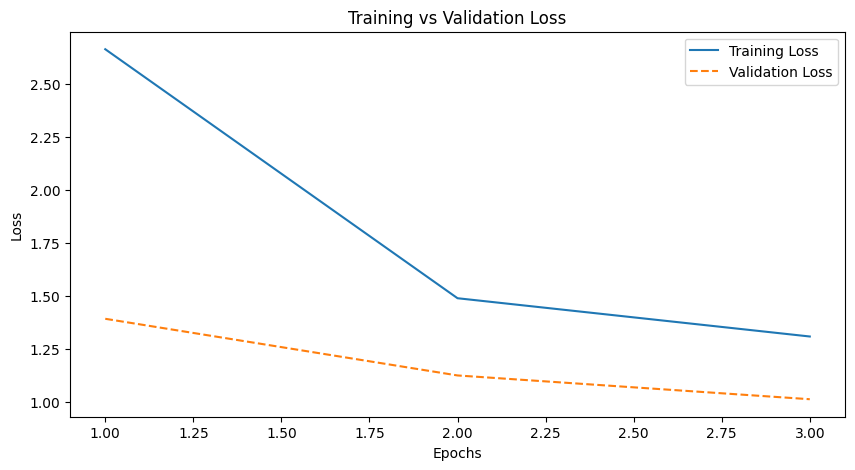

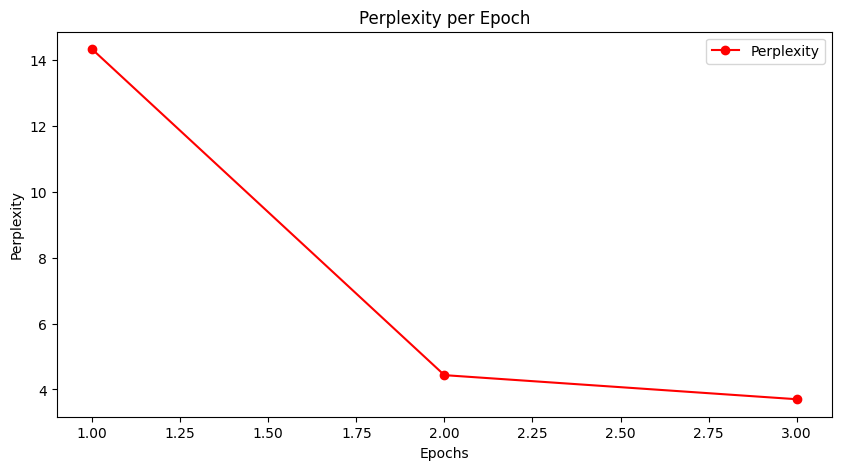

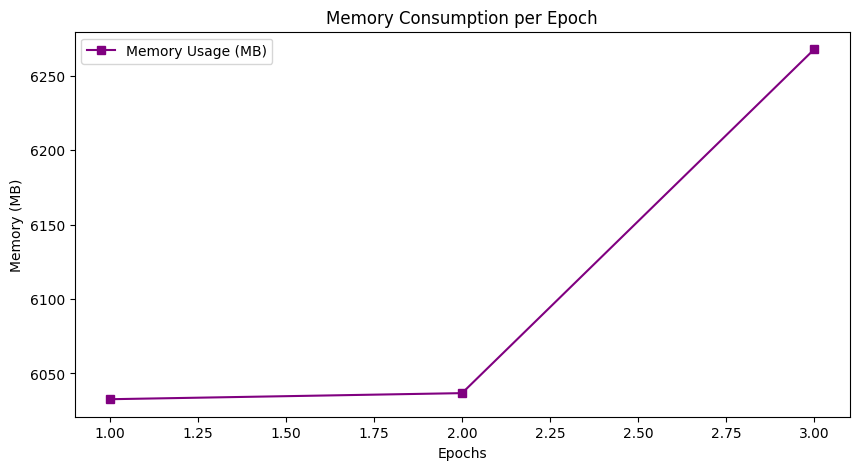

Fine-tuning complete.


In [ ]:
# Fine Tuning model -----------------------------------------------------------

# Define training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.AdamW(model.parameters(),
                        lr=2e-5,  # Adjust learning rate as needed
                        weight_decay=0.01
                        )
lr_scheduler = get_scheduler("cosine",
                             optimizer=optimizer,
                             num_warmup_steps=500,
                             num_training_steps=10000
                            )
loss_fn = nn.CrossEntropyLoss(ignore_index=TOKENIZER.pad_token_id,
                              label_smoothing=0.1
                              )

epochs = 3  # Adjust number of epochs as needed

# Mixed precision
scaler = GradScaler()

#Defining lists of metrics evaluation
train_losses = []
val_losses = []
perplexities = []
energy_consumptions = []
memory_usages = []
train_times = []

# Fine-tuning loop
for epoch in range(epochs):
    model.train()
    print(f"Epoch {epoch + 1}/{epochs}")

    #Lists and values initialization for each epochs
    loss_values = []
    nb_batch = []
    tracker = EmissionsTracker()
    tracker.start()

    start_time = time.time()
    total_loss = 0
    total_samples = 0
    i = 0

    loop = tqdm(train_dataloader, leave=True)

    for batch in loop:
        i+=1
        nb_batch.append(i)

        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        #Forward pass
        with autocast():
          outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss

        #Backward pass
        loss.backward()

        #Updates weights
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        #Loss calculation
        total_loss += loss.item()
        loss_values.append(loss.item())
        total_samples += len(labels)

        # Scale the loss
        print(f"Batch {i}/{len(train_dataloader)} - Loss: {loss.item()}")

    #Keep track
    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss}")

    # Perplexity Calculation
    perplexity = torch.exp(torch.tensor(sum(loss_values) / len(loss_values)))
    perplexities.append(perplexity.item())
    print(f"Epoch {epoch+1}/{epochs}, Perplexity: {perplexity:.2f}")

    # Validation Step
    model.eval()
    val_loss = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            total_val_samples += len(labels)

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss}")

    #Evaluate memory usage
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / 1024 / 1024  # MB
    memory_usages.append(memory_usage)
    print(f"Epoch {epoch+1}/{epochs}, Memory Usage: {memory_usage} MB")

    #Evaluate training time per step
    total_time = time.time() - start_time
    train_times.append(total_time / 60)
    print(f"Epoch {epoch+1}/{epochs}, Total Training Time: {total_time / 60:.2f} minutes")

    #Track energy consumption
    tracker.stop()
    print(f"Epoch {epoch+1}/{epochs}, Energy Consumption: {tracker}")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Plot Perplexity
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), perplexities, label="Perplexity", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Perplexity per Epoch")
plt.legend()
plt.show()

# Plot Memory Usage
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), memory_usages, label="Memory Usage (MB)", marker="s", color="purple")
plt.xlabel("Epochs")
plt.ylabel("Memory (MB)")
plt.title("Memory Consumption per Epoch")
plt.legend()
plt.show()

# Save the trained model (optional)
torch.save(model.state_dict(), "trained_model.pth")

print("Fine-tuning complete.")


#### Test and Evaluate fine-tuned model

In [ ]:
#Test and evaluate model ------------------------------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#Private out of the loop test
def generate_conversation(persona1, persona2):
    input_text = persona1 + persona2
    input_ids = TOKENIZER(input_text, return_tensors="pt").input_ids

    # Generate response

    output_ids = model.generate(input_ids, max_length=150, num_beams=5, temperature=0.7)
    output_text = TOKENIZER.decode(output_ids[0], skip_special_tokens=True)

    return output_text

### Test with new critic
persona1 = "I love hiking and nature walks. I also enjoy photography."
persona2 = "I prefer staying indoors and reading books. I love mystery novels."
generated_conversation = generate_conversation(persona1, persona2)

print("Out of the loop test : \n Generated Chatbot Conversation:\n", generated_conversation)

###Test with dataset

# Ensure predictions and references are tokenized properly before decoding
def decode_predictions(predictions):
    return [TOKENIZER.decode(p.tolist(), skip_special_tokens=True) if isinstance(p, torch.Tensor) else TOKENIZER.decode(p, skip_special_tokens=True) for p in predictions]

def decode_references(references):
    return [TOKENIZER.decode(r.tolist(), skip_special_tokens=True) if isinstance(r, torch.Tensor) else TOKENIZER.decode(r, skip_special_tokens=True) for r in references]
def calculate_rouge_score(predictions, true_labels):
    rouge = Rouge()

    # Ensure predictions and labels are converted properly
    predictions_decoded = []
    true_labels_decoded = []

    for p, t in zip(predictions, true_labels):
        # Remove any out-of-range IDs (e.g., -100 used for ignored padding)
        p = [token_id for token_id in p if token_id >= 0]
        t = [token_id for token_id in t if token_id >= 0]

        # Decode only if there are valid tokens
        pred_text = TOKENIZER.decode(p, skip_special_tokens=True) if p else ""
        true_text = TOKENIZER.decode(t, skip_special_tokens=True) if t else ""

        if pred_text.strip():
            predictions_decoded.append(pred_text)
            true_labels_decoded.append(true_text)

    # Calculate ROUGE scores only if valid predictions exist
    if predictions_decoded:
        scores = rouge.get_scores(predictions_decoded, true_labels_decoded, avg=True)
    else:
        scores = {
            'rouge-1': {'f': 0, 'p': 0, 'r': 0},
            'rouge-2': {'f': 0, 'p': 0, 'r': 0},
            'rouge-l': {'f': 0, 'p': 0, 'r': 0}
        }

    return scores

def calculate_persona_consistency_score(persona_1_statements, persona_2_statements, predicted_response_text):
    # Initialize a SentenceTransformer model
    sentence_model = SentenceTransformer('all-mpnet-base-v2')

    # Encode persona statements
    persona_1_embedding = sentence_model.encode(persona_1_statements, convert_to_tensor=True)
    persona_2_embedding = sentence_model.encode(persona_2_statements, convert_to_tensor=True)

    # Encode predicted response
    response_embedding = sentence_model.encode(predicted_response_text, convert_to_tensor=True)

    # Compute cosine similarity
    user_1_score = util.pytorch_cos_sim(response_embedding, persona_1_embedding).mean().item()
    user_2_score = util.pytorch_cos_sim(response_embedding, persona_2_embedding).mean().item()

    # Compute average consistency score
    avg_consistency_score = (user_1_score + user_2_score) / 2

    return avg_consistency_score, user_1_score, user_2_score

def calculate_mean_rouge(rouge_scores_list):
    """
    Returns:
        dict: Dictionary containing average ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    # Initialize accumulators
    total_rouge_1_f = 0
    total_rouge_2_f = 0
    total_rouge_l_f = 0
    total_rouge_1_p = 0
    total_rouge_2_p = 0
    total_rouge_l_p = 0
    total_rouge_1_r = 0
    total_rouge_2_r = 0
    total_rouge_l_r = 0
    num_samples = len(rouge_scores_list)

    # Sum up all ROUGE scores
    for scores in rouge_scores_list:
        total_rouge_1_f += scores['rouge-1']['f']
        total_rouge_2_f += scores['rouge-2']['f']
        total_rouge_l_f += scores['rouge-l']['f']
        total_rouge_1_p += scores['rouge-1']['p']
        total_rouge_2_p += scores['rouge-2']['p']
        total_rouge_l_p += scores['rouge-l']['p']
        total_rouge_1_r += scores['rouge-1']['r']
        total_rouge_2_r += scores['rouge-2']['r']
        total_rouge_l_r += scores['rouge-l']['r']

    # Compute mean values
    mean_rouge = {
        "rouge-1": {"f": total_rouge_1_f / num_samples, "p": total_rouge_1_p / num_samples, "r": total_rouge_1_r / num_samples},
        "rouge-2": {"f": total_rouge_2_f / num_samples, "p": total_rouge_2_p / num_samples, "r": total_rouge_2_r / num_samples},
        "rouge-l": {"f": total_rouge_l_f / num_samples, "p": total_rouge_l_p / num_samples, "r": total_rouge_l_r / num_samples}
    }

    return mean_rouge

def evaluate(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0

    all_predictions = []  # Store all predictions
    all_labels = []  # Store all labels
    all_rouge_scores = []
    all_consistency_scores = []
    all_user1_scores = []
    all_user2_scores = []
    all_inference_times = []

    with torch.no_grad():
      total_loss = 0
      start_time = time.time()

      for batch in test_dataloader:
            input_ids =  batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Pass labels as decoder_input_ids during evaluation
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            # Get predictions from the logits
            predictions = torch.argmax(outputs.logits, dim=2)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Compare predictions with shifted labels for accuracy calculation
            shifted_labels = labels[..., 1:]  # Shift labels to the right by one position
            predictions = predictions[..., :-1]  # Remove the last prediction
            # Calculate accuracy for valid predictions (ignoring padding)
            active_positions = shifted_labels != -100  # Ignore padding positions (-100)
            correct_predictions = (predictions == shifted_labels) * active_positions
            correct += correct_predictions.sum().item()
            total += active_positions.sum().item()

            # Rouge score is a recall-based evaluation
            rouge_score= calculate_rouge_score(shifted_labels, predictions)
            all_rouge_scores.append(rouge_score)

      total_time = time.time() - start_time
      inference_time = total_time / len(test_dataloader)

    mean_rouge_score=calculate_mean_rouge(all_rouge_scores)
    # Create a DataFrame for logging
    # Persona Consistency Score
    average_consistency_score, user_1_score, user_2_score = calculate_persona_consistency_score(
                       persona1, persona2, " ".join(generated_conversation))
    evaluation_data = {
      "Metric": ["Rouge-1 F1", "Rouge-2 F1", "Rouge-L F1",
               "Average Consistency Score", "Persona 1 Score", "Persona 2 Score", "Inference Time"],
    "Value": [
        mean_rouge_score["rouge-1"]["f"],
        mean_rouge_score["rouge-2"]["f"],
        mean_rouge_score["rouge-l"]["f"],
        average_consistency_score,
        user_1_score,
        user_2_score,
        inference_time
    ]
      }
    df = pd.DataFrame(evaluation_data)

    return df

    # Display in a tab (Colab only)
    data_table.DataTable(df)

#EValuate /calling function
evaluate(model, test_dataloader)


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Out of the loop test : 
 Generated Chatbot Conversation:
 User 1: Hi, I'm [user 1 name]. User 2: Hi, I'm [user 2 name]. User 2: Hi, I'm [user 2 name]. User 2: Hi, I'm [user 2 name]. User 1: What do you like to do for fun?


,Metric,Value
0,Rouge-1 F1,0.629109
1,Rouge-2 F1,0.409170
2,Rouge-L F1,0.616510
3,Average Consistency Score,-0.055683
4,Persona 1 Score,-0.100950
5,Persona 2 Score,-0.010415
6,Inference Time,1.700629
